In [1]:
import os
import csv
import optuna
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Input, LSTM, Dense, Activation, Dropout
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from math import sqrt
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from numpy import array
import keras.backend as K
import itertools
#!pip install pydot
    
# date-time parsing function for loading the dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
    
def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))
    
def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
    
# convert time series into a supervised learning problem
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
# Convert time series into a supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols, names = list(), list()
    df = DataFrame(data)
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
    	cols.append(df.shift(i))
    	names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df[0].shift(-i)) # df[0] for specific humidity
        if i == 0:
            names += [('var%d(t)' % (1))] # % (1) for specific humidity
        else:            
            names += [('var%d(t+%d)' % (1, i))] # % (1) for specific humidity
    
    # put it all together
    agg = concat(cols, axis=1)

    if dropnan:
        #Drop rows containing NaN
        agg.dropna(inplace=True)

    #print("Agg:")
    agg.columns = names
    #print(type(agg))
    #print(agg)

    #print("Test columns:")
    #print(agg.iloc[:, -37]) # Column containing response actual values (specific humidity) at time t-3
    #print(agg.iloc[:, -25]) # Column containing response actual values (specific humidity) at time t-2
    #print(agg.iloc[:, -13]) # Column containing response actual values (specific humidity) at time t-1
    #print(agg.iloc[:, -1]) # Column containing response actual values (specific humidity) at time t
    
    return agg
     
# create a differenced series
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
     
# transform series into training sets for supervised learning
def prepare_training_data(data, n_lag, n_seq, n_time_steps):
    
    #Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 27 time steps (the first 23 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 26-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 23 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaler_all_features =  MinMaxScaler(feature_range=(0, 1))
    scaler =  MinMaxScaler(feature_range=(0, 1))
    #diff_values_training = np.array(diff_values_for_training)
    #diff_values_training = diff_values_training.reshape(1, -1) 
    train_scaled_values = scaler_all_features.fit_transform(diff_values)
    response_train_values = []
    for i in range(len(diff_values)):
        response_train_values.append(diff_values[i][0]) # Uses first column (specific_humidity) as response variable
    response_train_values = np.array(response_train_values)
    response_train_values = response_train_values.reshape(len(response_train_values), 1)

    # Fit the scaler for just the response variable for use later when forecasting
    response_scaled_values = scaler.fit_transform(response_train_values) 
    scaled_values = scaler_all_features.transform(diff_values)

    #print("Scaled values rows:")
    #print(len(scaled_values))

    train = []

    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        train.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return scaler, scaler_all_features, train

# transform series into testing and validation sets for supervised learning
def prepare_testing_and_validation_data(data, n_lag, n_seq, n_time_steps, scaler_all_features):
    
    # Prepare data for time series forecasting.
        
    #Parameters:
    #x (array-like): Input features.
    #y (array-like): Target values.
    #n_test (int): Number of test samples (rows).
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations.
    #n_train (int): Number of training samples (rows).
        
    #Returns:
    #tuple: Training and test datasets.
    
    n_vars = len(data[0][0])

    print(n_vars)
    print(len(data))
    print(type(data))

    # Each weather station has 227 time steps (the first 180 have no nan values)
    # Loop through data, grabbing one weather station (ws) at a time, 
    # differencing on each ws and separating by training (first 226-n_lag-n_seq-n_test time steps) 
    # and testing (n_test time steps) to scale data on training only.
    # We then recombine the training and testing datasets to change each ws to a supervised learning problem by taking all the first 180 time steps for all 12 predictors
    # and changing these to (t-n_lag) to (t-1) since we lose one row through differencing. We then shift forward only one dependent variable (temperature or specific humidity)
    # for time steps t to (t+n_seq)


    diff_values = []
    
    for ws in range(len(data)):
        
        # transform data to be stationary
        diff_series = difference(data[ws], 1)
        for i in range(len(diff_series)):
            diff_values_row = []
            for j in range(len(diff_series[0])):
                diff_values_row.append(diff_series[i][j])
            diff_values.append(diff_values_row)

    #print("Diff values:")
    #print(len(diff_values))
    #print(len(diff_values[0]))
    #print(len(diff_values_for_training))
    #print(len(diff_values_for_training[0]))
    
    # rescale values to 0, 1
    scaled_values = scaler_all_features.transform(diff_values)

    validation = []
    test = []

    
    
    # Transform each weather station as a separate "batch"
    for ws in range(len(data)):
        # transform into a supervised learning problem X, y
        first = (n_time_steps-1)*ws
        last = (n_time_steps-1)*ws+(n_time_steps-2)
        #print("Batch "+str(ws+1)+":")
        #print("Range: "+str(first)+"-"+str(last))
        scaled_values_batch = scaled_values[first:last]
        supervised = series_to_supervised(scaled_values_batch, n_lag, n_seq)
        supervised_values = supervised.values
        # training/test/validation split is 80%/10%/10%
        if ws < 2:
            test.append([supervised_values])
        else:
            validation.append([supervised_values])
        #print("Supervised count:")
        #print(len(supervised_values))
        #print(len(supervised_values[0]))
    
    return validation, test
    
def plot_kfold(cv, X, y, ax, n_splits, xlim_max=105):
    
    #Plots the indices for a cross-validation object.
    #Taken from https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
    #Parameters:
    #cv: Cross-validation object
    #X: Feature set
    #y: Target variable
    #ax: Matplotlib axis object
    #n_splits: Number of folds in the cross-validation
    #xlim_max: Maximum limit for the x-axis
        
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
        
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
            
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)
    
        # Set y-ticks and labels
        y_ticks = np.arange(n_splits) + 0.5
        ax.set(yticks=y_ticks, yticklabels=range(n_splits),
               xlabel="Weather Station index (file_id)", ylabel="Fold",
               ylim=[n_splits, -0.2], xlim=[0, xlim_max])
    
        # Set plot title and create legend
        ax.set_title("KFold", fontsize=14)
        legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"), 
                          Patch(color=cmap_cv(0.02), label="Training set")]
        ax.legend(handles=legend_patches, loc=(1.03, 0.8))
    
#Main

#Configure
n_seq = 10
if n_seq > 3:
    n_lag = 25 - n_seq
else:
    n_lag = 22
n_time_steps = 27
n_test = 1

print("Model Parameters:")
print("n_lag (number of input time steps): "+str(n_lag))
print("n_seq (number of output/future prediction time steps): "+str(n_seq))

# Create 2D array with file_ids to use for sample creation
array = np.array([
    6501, 6541, 6640, 6668, 6678, 
    6687, 6697, 6714, 6744, 6772, 
    6783, 6840, 6844, 6854, 6870, 
    6891, 6895, 6899, 6901, 6909, 
    6929, 6950, 6963, 6969, 6994, 
    7032, 7057, 7094, 7095, 7100, 
    7108, 7116, 7119, 7131, 7139, 
    7152, 7155, 7156, 7182, 7193, 
    7202, 7239, 7280, 7286, 7287, 
    7311, 7321, 7329, 7347, 7350, 
    7354, 7357, 7361, 7414, 7423, 
    7424, 7432, 7463, 7482, 7489, 
    7528, 7531, 7534, 7538, 7549, 
    7553, 7555, 7562, 7571, 7573, 
    7574, 7575, 7585, 7599, 7603, 
    7606, 7622, 7652, 7671, 7704, 
    7786, 7805, 7816, 7838, 7861, 
    7862, 7863, 7870, 7892, 7907, 
    7938, 7962, 7979, 7987, 7999, 
    8000, 8034, 8083, 8120, 8133, 
    8184, 8186, 8247, 8248, 9858])
    
#Create arrays holding the 5-fold cross-validation indices gathered for consistency across models
train_array = []
test_array = []
    
train_array.append([5, 9, 21, 22, 41, 42, 45, 46, 52, 66, 68, 72, 79, 81, 82, 83, 90, 92, 95])
test_array.append([4, 10, 47, 53, 94])
    
train_array.append([4, 9, 10, 21, 41, 45, 46, 47, 52, 53, 66, 68, 81, 82, 83, 90, 92, 94, 95])
test_array.append([5, 22, 42, 72, 79])
    
train_array.append([4, 5, 10, 21, 22, 41, 42, 46, 47, 52, 53, 72, 79, 82, 83, 90, 92, 94, 95])
test_array.append([9, 45, 66, 68, 81])
    
train_array.append([4, 5, 9, 10, 21, 22, 42, 45, 47, 52, 53, 66, 68, 72, 79, 81, 82, 92, 94, 95])
test_array.append([41, 46, 83, 90])
    
train_array.append([4, 5, 9, 10, 22, 41, 42, 45, 46, 47, 53, 66, 68, 72, 79, 81, 83, 90, 94])
test_array.append([21, 52, 82, 92, 95])
    
# Equations for three Principal Components from PCA using response variables combined with other predictors
#PC1=-0.0002714X1+0.02612X2+0.03858X3-0.007658X4+0.001592X5-0.02087X6+0.8564X7-0.1468X8+0.01192X9-0.0001049X10+0.01913X11+0.02076X12
#PC2=0.0003944X1+0.002204X2+0.01052X3+0.3248X4-0.0009976X5-0.04421X6+2.3406X7+0.06103X8+0.08841X9+0.00009018X10+0.05678X11-0.002022X12
#PC3=-0.00007998X1-0.0006124X2-0.001063X3-0.01855X4+0.00001956X5+0.01170X6+0.6076X7+0.4664X8-0.002995X9+0.008185X10+0.8815X11-0.0004730X12
    
# Equations for three Principal Components from PCA omitting both response variables,
#PC-1=-0.0004514X1+0.03194X2-0.04343X3+0.002243X4-0.02252X5+0.9877X6-0.2265X7+0.006144X8-0.0001488X9+0.02943X10
#PC-2=0.0001702X1+0.005484X2+0.2057X3-0.0003188X4-0.02584X5+1.6963X6-0.05890X7+0.05809X8+1.9748X9+0.03686X10
#PC-3=-0.00006323X1-0.001180X2-0.02384X3-0.00002833X4+0.01170X5+0.5204X6+0.4791X7-0.004318X8+0.008271X9+0.8765X10
    
# Get the current working directory 
current_directory = os.getcwd() 
    
# Print the current working directory 
print(current_directory)
    
# Define the directory containing the files 
path = current_directory+"\\Modeling\\"
print(path)
    
filename = path + 'Final_Yearly_Dataset.csv'
    
# load dataset
df = read_csv(filename, header=0, parse_dates=[0], index_col=0, date_format='%Y-%m')

# Swap columns 'temperatures' and 'specific_humidity' directly
df['A'] = df['temperatures']
df['temperatures'] = df['specific_humidity']
df['specific_humidity'] = df['A']
df = df.drop(columns=['A'])
# Rename columns
df = df.rename(columns={'temperatures': 'specific_humidity', 'specific_humidity': 'temperatures'})

print(df)
    
df = df.rename(columns={'Unnamed: 0' : 'indices'})
    
#Remove unused columns
df = df.drop(['vapor_pressure'], axis=1)
    
# Round numbers in columns to reasonable precision,
df['temperatures'] = np.round(df['temperatures'], 2)
df['slp'] = np.round(df['slp'], 2)
df['wet_bulb_temperature'] = np.round(df['wet_bulb_temperature'], 2)
df['specific_humidity'] = np.round(df['specific_humidity'], 2)
df['GHI'] = np.round(df['GHI'], 2)
df['PRCP'] = np.round(df['PRCP'], 2)
df['SNDP'] = np.round(df['SNDP'], 2)
df['solar_activity'] = np.round(df['solar_activity'], 2)
df['ONI'] = np.round(df['ONI'], 2)
df['water'] = np.round(df['water'], 0)
df['region'] = np.round(df['region'], 0)

#Since the NaN values of GHI are gone which is used in data preparation, simulate these in solar activity instead
df['solar_activity'].loc[df['Year'] > 2020] = np.nan
    
df_trimmed = df[df['file_id'] != 7533] # Remove file_id 7533 so there are 105 weather stations for 5-fold CV
df_trimmed = df_trimmed.drop(['Year', 'date', 'latitude', 'longitude', 'elevation'], axis=1)

#Test model and accuracy when GHI is removed as a predictor
df_trimmed = df_trimmed.drop(['GHI'], axis=1)

n_vars = df_trimmed.shape[1]-1

X = []
y = []
    
for i in array:
    add_to_X = [] # create list to store each column to add to X
    new_df = df_trimmed[df_trimmed['file_id'] == i].drop(['file_id'], axis=1)
    add_to_y = []
    for j in range(new_df.shape[0]):
        add_to_y.append(new_df['specific_humidity'].iloc[j])
    y.append(add_to_y)
    #new_df = new_df.drop(['specific_humidity'], axis=1)
    columns_list = new_df.columns.tolist()
    for j in range(new_df.shape[0]):
        l=0
        new_row = []
        for m in columns_list:
            new_row.append(new_df.iloc[j, l])
            l += 1
        add_to_X.append(new_row)
    X.append(add_to_X)

print(df_trimmed)
print(new_df)
print(X[0])

#Perform k-fold cross-validation
#Taken from: https://www.geeksforgeeks.org/cross-validation-using-k-fold-with-scikit-learn/
    
#k = 5  # Number of folds
#kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
#for i, (train_index, test_index) in enumerate(kf.split(X)):
#    print(f"Fold {i}:")
#    print(f"  Training dataset index: {train_index}")
#    print(f"  Test dataset index: {test_index}")
    
#for train_indices, test_indices in kf.split(X):
#    print('Train: %s | test: %s' % (train_indices, test_indices))
    
# Create figure and axis
#fig, ax = plt.subplots(figsize=(6, 3))
#plot_kfold(kf, X, y, ax, k)
#plt.tight_layout()
#fig.subplots_adjust(right=0.6)
    
#Create train and test sets for each cross-validation split
train_X = []
train_y = []
val_X = []
val_y = []
for i in range(5):
    print(f"Fold {i+1}")
    #Add each corresponding sample for each entry of train index 
    train_X_rows = [] # Stores all the samples for one fold of train_X
    train_y_rows = [] # Stores all the samples for one fold of train_y
    for j in train_array[i]:
        train_X_rows.append(X[j])
        train_y_rows.append(y[j])
    # Stores one fold of the train dataset
    train_X.append(train_X_rows)
    train_y.append(train_y_rows)
    #Add each corresponding sample for each entry of the validation index 
    val_X_rows = [] # Stores all the samples for one fold of val_X
    val_y_rows = [] # Stores all the samples for one fold of val_y
    for j in test_array[i]: 
            val_X_rows.append(X[j])
            val_y_rows.append(y[j])
    # Stores one fold of the validation dataset
    val_X.append(val_X_rows)
    val_y.append(val_y_rows) 
    
    #print("Train_X Fold "+str(i)+":")
    #print(len(train_X[i]))
    #print(len(train_X[i][0]))
    #print(len(train_X[i][0][0])) 
    #print("Train_y Fold "+str(i)+":")
    #print(len(train_y[i]))
    #print(len(train_y[i][0]))
    #print(train_y[i][0][0])
    #print("Validation_X Fold "+str(i)+":")
    #print(len(val_X[i]))
    #print(len(val_X[i][0]))
    #print(len(val_X[i][0][0]))
    #print("Validation_y Fold "+str(i)+":")
    #print(len(val_y[i]))
    #print(len(val_y[i][0]))
    #print(val_y[i][0][0])
    
#Convert 3D arrays to DataFrames
df_X = []
df_y = []
val_df_X = []
val_df_y = []
dataset = []
dataset_test = []
scaler = []
scaler_all_features = []
train = []
test = []
validation = []

for i in range(5):
    dataset_scaling = [] # Holds all 84 weather station rows to train the scaling function
    dataset_testing = [] # Holds remaining 21 weather station rows for testing and validation
    print("Fold "+str(i+1)+":")
    #Transform train_X to the correct format
    df1 = []
    dataset_df = [] # captures each weather station's dataset as values for training scaler mapping
    df_X.append(pd.DataFrame(train_X[i]))
    X_t = df_X[i].transpose()
    if i==3:
        train_size = 20
        val_size = 4
    else:
        train_size = 19
        val_size = 5
        
    for k in range(train_size):
        X = np.array(X_t.iloc[:, k])
        df = pd.DataFrame()
        for j in range(n_time_steps):
            new_row = pd.DataFrame(X[j]).transpose()
            new_row.columns = new_df.columns
            # Add the new row
            df = pd.concat([df, new_row], ignore_index=True)
        df.columns = new_df.columns
        df1.append(df)
        dataset_df.append(df.values)
        dataset_scaling.append(df.values)
    df_X[i] = df1
    dataset.append(dataset_df)
     

    #print(len(dataset))
    #print(len(dataset[0]))
    #print(len(dataset_scaling))
    #print(len(dataset_scaling[:][0]))
    #print("Stop")
    
    #Transform train_y to the correct format
    df2 = []
    df_y.append(pd.DataFrame(train_y[i]))
    y_t = df_y[i].transpose()
    
    for j in range(train_size):
        y = np.array(y_t.iloc[:, j])
        y = pd.DataFrame(y)
        y.columns = ['specific_humidity']
        df2.append(y)
    df_y[i] = df2

    #Transform val_X to the correct format
    df3 = []
    dataset_vl_df = [] # captures each weather station's dataset as values for training scaler mapping
    val_df_X.append(pd.DataFrame(val_X[i]))
    val_X_t = val_df_X[i].transpose()
    for k in range(val_size):
        vl_X = np.array(val_X_t.iloc[:, k])
        vl_df = pd.DataFrame()
        for j in range(n_time_steps):
            new1_row = pd.DataFrame(vl_X[j]).transpose()
            new1_row.columns = new_df.columns
            # Add the new row
            vl_df = pd.concat([vl_df, new1_row], ignore_index=True)
        vl_df.columns = new_df.columns
        df3.append(vl_df)
        dataset_vl_df.append(vl_df.values)
        dataset_testing.append(vl_df.values)
    val_df_X[i] = df3
    dataset_test.append(dataset_vl_df)

    #Transform val_y to the correct format
    df4 = []
    val_df_y.append(pd.DataFrame(train_y[i]))
    val_y_t = val_df_y[i].transpose()
    
    for j in range(val_size):
        v_y = np.array(val_y_t.iloc[:, j])
        v_y = pd.DataFrame(v_y)
        v_y.columns = ['specific_humidity']
        df4.append(v_y)
    val_df_y[i] = df4
    
    scaler.append(MinMaxScaler(feature_range=(0, 1)))
    scaler_all_features.append(MinMaxScaler(feature_range=(0, 1)))
    train.append([1])
    test.append([1])
    validation.append([1])
    
    # prepare data
    scaler[i], scaler_all_features[i], train[i] = prepare_training_data(dataset_scaling, n_lag, n_seq, n_time_steps)

    validation[i], test[i] = prepare_testing_and_validation_data(dataset_testing, n_lag, n_seq, n_time_steps, scaler_all_features[i])

    #Reshape dimensionality
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]
    print(np.array(train1).shape)
    print(np.array(test1).shape)
    print(np.array(validation1).shape)
    train2 = []
    test2 = []
    validation2 = []

    for k in range(train_size):
        train2.append(train1[k][0])
        
    for k in range(2):
        test2.append(test1[k][0])

    for k in range(val_size-2):
        validation2.append(validation1[k][0])

    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2

    #Reshape dimensionality (again)
    dim_size = n_seq + n_vars*n_lag
    train1 = np.array(train[i]).reshape(train_size, dim_size)
    test1 = np.array(test[i]).reshape(2, dim_size)
    validation1 = np.array(validation[i]).reshape(val_size-2, dim_size)
    train2 = pd.DataFrame(train1).values
    test2 = pd.DataFrame(test1).values
    validation2 = pd.DataFrame(validation1).values
    print(np.array(train2).shape)
    print(np.array(test2).shape)
    print(np.array(validation2).shape)

    print(train2)

    train[i] = train2
    test[i] = test2
    validation[i] = validation2
    
    #X_train = train1[:][:-n_seq]
    #y_train = train1[:][-n_seq:]
    #X_test = test1[:][:-n_seq]
    #y_test = test1[:][-n_seq:]

print("Finished")

Model Parameters:
n_lag (number of input time steps): 15
n_seq (number of output/future prediction time steps): 10
C:\Users\User
C:\Users\User\Modeling\
     file_id        date  specific_humidity          slp  vapor_pressure  \
0       6678  1998-12-31          12.816968  1016.202508       20.726068   
1       6678  1999-12-31          12.330412  1017.480181       19.960131   
2       6678  2000-12-31          12.136613  1018.259826       19.655271   
3       6678  2001-12-31          11.897962  1018.414173       19.285320   
4       6678  2002-12-31          12.751085  1017.916636       20.638060   
..       ...         ...                ...          ...             ...   
643     8000  2020-12-31           5.146134  1016.944161        8.168785   
644     8000  2021-12-31           5.239193  1016.159983        8.312383   
645     8000  2022-12-31           5.362553  1017.898453        8.512894   
646     8000  2023-12-31           5.430746  1016.166709        8.612808   
647     800

C:\Users\User\AppData\Local\Temp\ipykernel_307976\3260198702.py:409: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['solar_activity'].loc[df['Year'] > 2020] = np.nan


     file_id  specific_humidity      slp  wet_bulb_temperature  temperatures  \
0       6678              12.82  1016.20                 18.08         20.84   
1       6678              12.33  1017.48                 17.71         20.69   
2       6678              12.14  1018.26                 17.29         20.47   
3       6678              11.90  1018.41                 17.20         20.30   
4       6678              12.75  1017.92                 17.75         20.46   
..       ...                ...      ...                   ...           ...   
643     8000               5.15  1016.94                  7.64         13.02   
644     8000               5.24  1016.16                  7.88         13.47   
645     8000               5.36  1017.90                  7.13         11.84   
646     8000               5.43  1016.17                  7.66         12.86   
647     8000               5.32  1015.12                  8.11         13.58   

     water      WDSP  PRCP  SNDP  regio

In [2]:
print(n_seq)
print(n_lag)
print(np.array(train[1]).shape)
print(np.array(test[1]).shape)

10
15
(19, 175)
(2, 175)


[I 2025-06-06 23:04:37,713] A new study created in memory with name: no-name-65120b47-2ae8-4c89-8b1e-bce81a9e488e
[I 2025-06-06 23:06:53,907] Trial 0 finished with value: 0.08891826868057251 and parameters: {'lr': 0.004079849821614742, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3138280631333466}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.09518235176801682, 0.0882740169763565, 0.08439131081104279, 0.10386204719543457, 0.07288161665201187]
Mean Cross Validation Accuracy:
0.08891826868057251
Standard Deviation of Cross Validation Accuracy:
0.01039844093432933


[I 2025-06-06 23:09:45,358] Trial 1 finished with value: 0.44419054985046386 and parameters: {'lr': 0.001679166406633868, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.23237225484629095}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.4012576937675476, 0.4094003438949585, 0.4109915792942047, 0.5849574208259583, 0.41434571146965027]
Mean Cross Validation Accuracy:
0.44419054985046386
Standard Deviation of Cross Validation Accuracy:
0.07051494387726139


[I 2025-06-06 23:12:14,858] Trial 2 finished with value: 0.089373280107975 and parameters: {'lr': 0.03214004284356766, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.2346795940705509}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.09392175078392029, 0.09101977944374084, 0.08349040895700455, 0.10660875588655472, 0.07182570546865463]
Mean Cross Validation Accuracy:
0.089373280107975
Standard Deviation of Cross Validation Accuracy:
0.011515092006302506


[I 2025-06-06 23:16:02,624] Trial 3 finished with value: 1.5924335241317749 and parameters: {'lr': 0.13756542772092997, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.48258625159626967}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[1.874793529510498, 1.3498212099075317, 1.5276539325714111, 1.8706399202346802, 1.3392590284347534]
Mean Cross Validation Accuracy:
1.5924335241317749
Standard Deviation of Cross Validation Accuracy:
0.23844514137950087


[I 2025-06-06 23:19:01,290] Trial 4 finished with value: 0.43983275890350343 and parameters: {'lr': 0.0019558324417145874, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.46755973215588376}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.41638997197151184, 0.39050424098968506, 0.4142058193683624, 0.5668133497238159, 0.41125041246414185]
Mean Cross Validation Accuracy:
0.43983275890350343
Standard Deviation of Cross Validation Accuracy:
0.06415703849416016


[I 2025-06-06 23:23:20,965] Trial 5 finished with value: 0.09538252651691437 and parameters: {'lr': 0.018991859776995263, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1586378375383399}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.09792792052030563, 0.09601998329162598, 0.09285223484039307, 0.11819268763065338, 0.07191980630159378]
Mean Cross Validation Accuracy:
0.09538252651691437
Standard Deviation of Cross Validation Accuracy:
0.014724744124619238


[I 2025-06-06 23:27:03,165] Trial 6 finished with value: 0.20585879683494568 and parameters: {'lr': 0.0018397470821870222, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.3357298771326016}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.09380006790161133, 0.18931721150875092, 0.12309294939041138, 0.3986169695854187, 0.22446678578853607]
Mean Cross Validation Accuracy:
0.20585879683494568
Standard Deviation of Cross Validation Accuracy:
0.10694198305012709


[I 2025-06-06 23:30:10,012] Trial 7 finished with value: 0.08958220183849334 and parameters: {'lr': 0.018442632567273482, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.19367303167565703}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.09374713897705078, 0.09431559592485428, 0.08339215070009232, 0.10463950783014297, 0.07181661576032639]
Mean Cross Validation Accuracy:
0.08958220183849334
Standard Deviation of Cross Validation Accuracy:
0.011139182792897145


[I 2025-06-06 23:33:35,420] Trial 8 finished with value: 0.09343249350786209 and parameters: {'lr': 0.019773302262221605, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 512, 'dropout_rate': 0.4428986352797021}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.10326514393091202, 0.09283469617366791, 0.08294861763715744, 0.1143585667014122, 0.07375544309616089]
Mean Cross Validation Accuracy:
0.09343249350786209
Standard Deviation of Cross Validation Accuracy:
0.014366884710844336


[I 2025-06-06 23:36:48,434] Trial 9 finished with value: 5.013444125652313 and parameters: {'lr': 0.7970954999695125, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.16845470834510923}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.6645674109458923, 5.184624671936035, 5.248389720916748, 6.2297468185424805, 7.73989200592041]
Mean Cross Validation Accuracy:
5.013444125652313
Standard Deviation of Cross Validation Accuracy:
2.3626316334302366


[I 2025-06-06 23:41:14,464] Trial 10 finished with value: 0.09006513804197311 and parameters: {'lr': 0.005724088320642694, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.35038451037931745}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.09530708938837051, 0.09277167171239853, 0.08317030966281891, 0.1047854870557785, 0.07429113239049911]
Mean Cross Validation Accuracy:
0.09006513804197311
Standard Deviation of Cross Validation Accuracy:
0.010467568640196339


[I 2025-06-06 23:44:26,535] Trial 11 finished with value: 0.9658225417137146 and parameters: {'lr': 0.12676345225325447, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.26796700174028004}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[1.0047796964645386, 1.5004960298538208, 0.5754786729812622, 0.9133155345916748, 0.8350427746772766]
Mean Cross Validation Accuracy:
0.9658225417137146
Standard Deviation of Cross Validation Accuracy:
0.30319039165060124


[I 2025-06-06 23:47:16,443] Trial 12 finished with value: 0.10386647582054138 and parameters: {'lr': 0.005926749369677711, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.3024871013745008}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.0987539142370224, 0.09841987490653992, 0.08496161550283432, 0.1620721071958542, 0.07512486726045609]
Mean Cross Validation Accuracy:
0.10386647582054138
Standard Deviation of Cross Validation Accuracy:
0.03042095684725797


[I 2025-06-06 23:50:03,741] Trial 13 finished with value: 0.09136381894350051 and parameters: {'lr': 0.14478172120294208, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.11514842508209433}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.09355960041284561, 0.09208562225103378, 0.08263156563043594, 0.10585851967334747, 0.08268378674983978]
Mean Cross Validation Accuracy:
0.09136381894350051
Standard Deviation of Cross Validation Accuracy:
0.008567776985078745


[I 2025-06-06 23:53:18,570] Trial 14 finished with value: 0.10022656321525573 and parameters: {'lr': 0.04966261493269569, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.3953041237097518}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.10404554754495621, 0.1030341163277626, 0.10335797071456909, 0.11537881940603256, 0.07531636208295822]
Mean Cross Validation Accuracy:
0.10022656321525573
Standard Deviation of Cross Validation Accuracy:
0.013284439746103346


[I 2025-06-06 23:56:54,328] Trial 15 finished with value: 0.08974097520112992 and parameters: {'lr': 0.05648319361214137, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.24769855577795796}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.09311142563819885, 0.09214405715465546, 0.08521604537963867, 0.1058785617351532, 0.07235478609800339]
Mean Cross Validation Accuracy:
0.08974097520112992
Standard Deviation of Cross Validation Accuracy:
0.010957289807121871


[I 2025-06-06 23:59:34,659] Trial 16 finished with value: 0.11346046328544616 and parameters: {'lr': 0.00621987777482583, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.38373073158533466}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.11592047661542892, 0.12600913643836975, 0.10210733860731125, 0.13363578915596008, 0.08962957561016083]
Mean Cross Validation Accuracy:
0.11346046328544616
Standard Deviation of Cross Validation Accuracy:
0.015920862318438464


[I 2025-06-07 00:03:15,499] Trial 17 finished with value: 0.09585858285427093 and parameters: {'lr': 0.4174601611593894, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.2989725068669517}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.09991103410720825, 0.09750368446111679, 0.09173300862312317, 0.11136108636856079, 0.07878410071134567]
Mean Cross Validation Accuracy:
0.09585858285427093
Standard Deviation of Cross Validation Accuracy:
0.010658467421263092


[I 2025-06-07 00:06:32,524] Trial 18 finished with value: 0.09710577428340912 and parameters: {'lr': 0.003824137481408545, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.20104915942470108}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.09071699529886246, 0.0946323573589325, 0.08672524988651276, 0.13475723564624786, 0.07869703322649002]
Mean Cross Validation Accuracy:
0.09710577428340912
Standard Deviation of Cross Validation Accuracy:
0.01955097882464339


[I 2025-06-07 00:10:00,166] Trial 19 finished with value: 0.24960832595825194 and parameters: {'lr': 0.01254500249058882, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.10203277181433631}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.21388103067874908, 0.2540387511253357, 0.10289536416530609, 0.33129850029945374, 0.34592798352241516]
Mean Cross Validation Accuracy:
0.24960832595825194
Standard Deviation of Cross Validation Accuracy:
0.08805852879804649


[I 2025-06-07 00:13:45,449] Trial 20 finished with value: 0.09648424685001374 and parameters: {'lr': 0.045349178343584526, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.294634706020916}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.08957406878471375, 0.09608277678489685, 0.09809890389442444, 0.11200351268053055, 0.08666197210550308]
Mean Cross Validation Accuracy:
0.09648424685001374
Standard Deviation of Cross Validation Accuracy:
0.008807310026941276


[I 2025-06-07 00:16:40,776] Trial 21 finished with value: 0.08960453271865845 and parameters: {'lr': 0.012238388293187685, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.2062308184237834}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.0939631313085556, 0.09516307711601257, 0.07877318561077118, 0.10642818361520767, 0.07369508594274521]
Mean Cross Validation Accuracy:
0.08960453271865845
Standard Deviation of Cross Validation Accuracy:
0.01186051098276399


[I 2025-06-07 00:19:38,128] Trial 22 finished with value: 0.08920812159776688 and parameters: {'lr': 0.02832371401390017, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.17382697223316376}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.09224224835634232, 0.0927557423710823, 0.08331664651632309, 0.105982705950737, 0.07174326479434967]
Mean Cross Validation Accuracy:
0.08920812159776688
Standard Deviation of Cross Validation Accuracy:
0.011339390815669191


[I 2025-06-07 00:22:26,875] Trial 23 finished with value: 0.1680631160736084 and parameters: {'lr': 0.06774569640490677, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.141470565709787}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.18191689252853394, 0.21350988745689392, 0.12598258256912231, 0.190684512257576, 0.12822170555591583]
Mean Cross Validation Accuracy:
0.1680631160736084
Standard Deviation of Cross Validation Accuracy:
0.035006208045434375


[I 2025-06-07 00:25:14,143] Trial 24 finished with value: 0.09199182242155075 and parameters: {'lr': 0.028777262881547146, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.24284675461913757}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.0970630869269371, 0.09196691960096359, 0.08122260123491287, 0.10505163669586182, 0.08465486764907837]
Mean Cross Validation Accuracy:
0.09199182242155075
Standard Deviation of Cross Validation Accuracy:
0.008556683037411158


[I 2025-06-07 00:28:04,482] Trial 25 finished with value: 0.09139848798513413 and parameters: {'lr': 0.0032180948697033635, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.26969106053012093}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.09119085967540741, 0.09739480167627335, 0.08073572814464569, 0.11319897323846817, 0.07447207719087601]
Mean Cross Validation Accuracy:
0.09139848798513413
Standard Deviation of Cross Validation Accuracy:
0.013501539723085581


[I 2025-06-07 00:31:01,629] Trial 26 finished with value: 0.7654710352420807 and parameters: {'lr': 0.2950379859951063, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 256, 'dropout_rate': 0.3451132360807213}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.6777085661888123, 0.6432627439498901, 0.4492962658405304, 0.9275828003883362, 1.1295047998428345]
Mean Cross Validation Accuracy:
0.7654710352420807
Standard Deviation of Cross Validation Accuracy:
0.23723591988113352


[I 2025-06-07 00:34:36,119] Trial 27 finished with value: 0.0978418156504631 and parameters: {'lr': 0.010688038695699637, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 256, 'dropout_rate': 0.21691324013232496}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[0.09610747545957565, 0.09697560220956802, 0.08818818628787994, 0.11340726166963577, 0.09453055262565613]
Mean Cross Validation Accuracy:
0.0978418156504631
Standard Deviation of Cross Validation Accuracy:
0.00836897119230643


[I 2025-06-07 00:37:55,429] Trial 28 finished with value: 1.7426833748817443 and parameters: {'lr': 0.09680958725369634, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1793562230433169}. Best is trial 0 with value: 0.08891826868057251.


Cross Validation Accuracies:
[1.7252079248428345, 0.8663514256477356, 3.232255697250366, 1.574818730354309, 1.3147830963134766]
Mean Cross Validation Accuracy:
1.7426833748817443
Standard Deviation of Cross Validation Accuracy:
0.7997957198497768


[I 2025-06-07 00:41:38,729] Trial 29 finished with value: 0.08650664240121841 and parameters: {'lr': 0.03097046321606109, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1402633037751021}. Best is trial 29 with value: 0.08650664240121841.


Cross Validation Accuracies:
[0.09224555641412735, 0.09279923886060715, 0.07985880225896835, 0.09829383343458176, 0.06933578103780746]
Mean Cross Validation Accuracy:
0.08650664240121841
Standard Deviation of Cross Validation Accuracy:
0.010492874107923583


[I 2025-06-07 00:45:01,632] Trial 30 finished with value: 0.3669306695461273 and parameters: {'lr': 0.0011174607152314715, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1332712886729589}. Best is trial 29 with value: 0.08650664240121841.


Cross Validation Accuracies:
[0.3020199239253998, 0.32726192474365234, 0.355398952960968, 0.5065383911132812, 0.3434341549873352]
Mean Cross Validation Accuracy:
0.3669306695461273
Standard Deviation of Cross Validation Accuracy:
0.0720588604076232


[I 2025-06-07 00:48:46,050] Trial 31 finished with value: 0.08608683794736863 and parameters: {'lr': 0.038844392388824124, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.23019200323725364}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09094478189945221, 0.08825353533029556, 0.07261262089014053, 0.10885557532310486, 0.06976767629384995]
Mean Cross Validation Accuracy:
0.08608683794736863
Standard Deviation of Cross Validation Accuracy:
0.01410375241597063


[I 2025-06-07 00:52:46,149] Trial 32 finished with value: 0.0898253783583641 and parameters: {'lr': 0.03245933183061391, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.14968911510409666}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09165894240140915, 0.09538212418556213, 0.08334547281265259, 0.10418029129505157, 0.07456006109714508]
Mean Cross Validation Accuracy:
0.0898253783583641
Standard Deviation of Cross Validation Accuracy:
0.010152063767283203


[I 2025-06-07 00:56:45,962] Trial 33 finished with value: 0.09457004070281982 and parameters: {'lr': 0.08675467537601138, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.12380953265439959}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09587082266807556, 0.09542102366685867, 0.09286779165267944, 0.11416091024875641, 0.07452965527772903]
Mean Cross Validation Accuracy:
0.09457004070281982
Standard Deviation of Cross Validation Accuracy:
0.012575635770067609


[I 2025-06-07 01:00:42,907] Trial 34 finished with value: 0.10202021300792694 and parameters: {'lr': 0.20724944911910903, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.17831878393656317}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.11618628352880478, 0.11785900592803955, 0.08590511977672577, 0.11324683576822281, 0.0769038200378418]
Mean Cross Validation Accuracy:
0.10202021300792694
Standard Deviation of Cross Validation Accuracy:
0.017135410117349016


[I 2025-06-07 01:04:25,501] Trial 35 finished with value: 0.08974090814590455 and parameters: {'lr': 0.03308612393527949, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.225065065590134}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09236399829387665, 0.09068247675895691, 0.07986128330230713, 0.10507252812385559, 0.08072425425052643]
Mean Cross Validation Accuracy:
0.08974090814590455
Standard Deviation of Cross Validation Accuracy:
0.009184037881509918


[I 2025-06-07 01:08:27,414] Trial 36 finished with value: 0.09043821096420288 and parameters: {'lr': 0.008205318191578178, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.282102928942072}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09388529509305954, 0.0961214080452919, 0.08418441563844681, 0.10485059022903442, 0.07314934581518173]
Mean Cross Validation Accuracy:
0.09043821096420288
Standard Deviation of Cross Validation Accuracy:
0.010861975955089821


[I 2025-06-07 01:12:56,051] Trial 37 finished with value: 0.20745611190795898 and parameters: {'lr': 0.0030274767575193353, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3230243063781111}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.23248259723186493, 0.19343747198581696, 0.21105922758579254, 0.21487955749034882, 0.18542170524597168]
Mean Cross Validation Accuracy:
0.20745611190795898
Standard Deviation of Cross Validation Accuracy:
0.016591879319611372


[I 2025-06-07 01:16:24,064] Trial 38 finished with value: 0.08961082994937897 and parameters: {'lr': 0.01924492273882157, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.2520393856072316}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09035765379667282, 0.09744357317686081, 0.08137376606464386, 0.10613565891981125, 0.0727434977889061]
Mean Cross Validation Accuracy:
0.08961082994937897
Standard Deviation of Cross Validation Accuracy:
0.011724638164834916


[I 2025-06-07 01:19:59,343] Trial 39 finished with value: 0.08917849361896515 and parameters: {'lr': 0.027670501905375622, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.15621947549267123}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09246806800365448, 0.09247562289237976, 0.0834161788225174, 0.10549581795930862, 0.07203678041696548]
Mean Cross Validation Accuracy:
0.08917849361896515
Standard Deviation of Cross Validation Accuracy:
0.011090446681887503


[I 2025-06-07 01:24:04,299] Trial 40 finished with value: 3.54227557182312 and parameters: {'lr': 0.04365415321728739, 'optimizer': 'RMSprop', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3764531811973107}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[2.6554877758026123, 4.65797758102417, 4.484875679016113, 2.987488031387329, 2.925548791885376]
Mean Cross Validation Accuracy:
3.54227557182312
Standard Deviation of Cross Validation Accuracy:
0.8494491940900979


[I 2025-06-07 01:28:13,084] Trial 41 finished with value: 0.08995472937822342 and parameters: {'lr': 0.024118155227990462, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.15843968147922693}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09245312958955765, 0.09223952144384384, 0.08376087993383408, 0.10545295476913452, 0.07586716115474701]
Mean Cross Validation Accuracy:
0.08995472937822342
Standard Deviation of Cross Validation Accuracy:
0.009884134945026428


[I 2025-06-07 01:32:17,444] Trial 42 finished with value: 0.08975246995687484 and parameters: {'lr': 0.01409563779087221, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.18821299420493562}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09399154782295227, 0.09421156346797943, 0.08287720382213593, 0.10521991550922394, 0.07246211916208267]
Mean Cross Validation Accuracy:
0.08975246995687484
Standard Deviation of Cross Validation Accuracy:
0.011165309516899067


[I 2025-06-07 01:36:36,519] Trial 43 finished with value: 0.15812396109104157 and parameters: {'lr': 0.07165627994337763, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.15293763259814339}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.15278282761573792, 0.13235345482826233, 0.1835426539182663, 0.20058788359165192, 0.12135298550128937]
Mean Cross Validation Accuracy:
0.15812396109104157
Standard Deviation of Cross Validation Accuracy:
0.029980146780313646


[I 2025-06-07 01:41:03,426] Trial 44 finished with value: 0.08895853906869888 and parameters: {'lr': 0.022253994946596058, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.10078843667245946}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.0924571305513382, 0.09205197542905807, 0.0832122415304184, 0.10500862449407578, 0.07206272333860397]
Mean Cross Validation Accuracy:
0.08895853906869888
Standard Deviation of Cross Validation Accuracy:
0.010935293847205528


[I 2025-06-07 01:45:22,825] Trial 45 finished with value: 0.08828848451375962 and parameters: {'lr': 0.008512763976594758, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.11297547768172472}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.0916793942451477, 0.09237638860940933, 0.08185519278049469, 0.10607188940048218, 0.06945955753326416]
Mean Cross Validation Accuracy:
0.08828848451375962
Standard Deviation of Cross Validation Accuracy:
0.01216860264639194


[I 2025-06-07 01:49:43,672] Trial 46 finished with value: 0.08971096277236938 and parameters: {'lr': 0.008315411443312014, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.10147924695836164}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09507475793361664, 0.09202421456575394, 0.08429130166769028, 0.10433439910411835, 0.07283014059066772]
Mean Cross Validation Accuracy:
0.08971096277236938
Standard Deviation of Cross Validation Accuracy:
0.010604727309647658


[I 2025-06-07 01:54:33,674] Trial 47 finished with value: 0.08888890147209168 and parameters: {'lr': 0.002369810720079519, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.12146419919101425}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.0923999771475792, 0.09225490689277649, 0.08337658643722534, 0.10454316437244415, 0.0718698725104332]
Mean Cross Validation Accuracy:
0.08888890147209168
Standard Deviation of Cross Validation Accuracy:
0.010851235465934882


[I 2025-06-07 01:58:53,187] Trial 48 finished with value: 0.22195531129837037 and parameters: {'lr': 0.0024018346850839707, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3241871593828709}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.22478461265563965, 0.19446074962615967, 0.1938065141439438, 0.3362337052822113, 0.1604909747838974]
Mean Cross Validation Accuracy:
0.22195531129837037
Standard Deviation of Cross Validation Accuracy:
0.06065266134910923


[I 2025-06-07 02:03:02,423] Trial 49 finished with value: 0.33902416229248045 and parameters: {'lr': 0.00136094008275425, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.12352421212404906}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.2907107174396515, 0.29682090878486633, 0.3204559087753296, 0.48142051696777344, 0.3057127594947815]
Mean Cross Validation Accuracy:
0.33902416229248045
Standard Deviation of Cross Validation Accuracy:
0.07189778157914867


[I 2025-06-07 02:06:30,619] Trial 50 finished with value: 0.08910643160343171 and parameters: {'lr': 0.003899647382476922, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.41346890912175627}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09250065684318542, 0.09262783080339432, 0.08329299092292786, 0.10516101121902466, 0.07194966822862625]
Mean Cross Validation Accuracy:
0.08910643160343171
Standard Deviation of Cross Validation Accuracy:
0.01104374181137801


[I 2025-06-07 02:11:06,169] Trial 51 finished with value: 0.08906802088022232 and parameters: {'lr': 0.004376451018378803, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.11621826598009162}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.0923248827457428, 0.09221222251653671, 0.0835246816277504, 0.10506362468004227, 0.07221469283103943]
Mean Cross Validation Accuracy:
0.08906802088022232
Standard Deviation of Cross Validation Accuracy:
0.010873047139262008


[I 2025-06-07 02:15:29,548] Trial 52 finished with value: 0.10524318516254424 and parameters: {'lr': 0.0017867157795243168, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.13476770671661764}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09342005848884583, 0.0985662117600441, 0.08366414159536362, 0.176703080534935, 0.07386243343353271]
Mean Cross Validation Accuracy:
0.10524318516254424
Standard Deviation of Cross Validation Accuracy:
0.03671863735256303


[I 2025-06-07 02:19:50,710] Trial 53 finished with value: 0.08887062221765518 and parameters: {'lr': 0.015791944834322107, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.10564079928902415}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09245497733354568, 0.09207557141780853, 0.08360605686903, 0.10551438480615616, 0.07070212066173553]
Mean Cross Validation Accuracy:
0.08887062221765518
Standard Deviation of Cross Validation Accuracy:
0.011471218166979115


[I 2025-06-07 02:24:02,977] Trial 54 finished with value: 0.08897876739501953 and parameters: {'lr': 0.015580174603572045, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.12126326047810565}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09221033751964569, 0.09200494736433029, 0.08356970548629761, 0.1051439419388771, 0.07196490466594696]
Mean Cross Validation Accuracy:
0.08897876739501953
Standard Deviation of Cross Validation Accuracy:
0.01095119312592492


[I 2025-06-07 02:28:36,462] Trial 55 finished with value: 0.09074243158102036 and parameters: {'lr': 0.008275141048513917, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.13239055634329103}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09280934184789658, 0.09679808467626572, 0.08302010595798492, 0.10826237499713898, 0.07282225042581558]
Mean Cross Validation Accuracy:
0.09074243158102036
Standard Deviation of Cross Validation Accuracy:
0.012071939988492464


[I 2025-06-07 02:32:45,572] Trial 56 finished with value: 0.23716667294502258 and parameters: {'lr': 0.0023122796763485175, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4885396157827926}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.20427560806274414, 0.18805846571922302, 0.21530771255493164, 0.32627344131469727, 0.25191813707351685]
Mean Cross Validation Accuracy:
0.23716667294502258
Standard Deviation of Cross Validation Accuracy:
0.049252155645370485


[I 2025-06-07 02:37:09,282] Trial 57 finished with value: 0.12794808745384217 and parameters: {'lr': 0.005393759413105305, 'optimizer': 'RMSprop', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1674764294977892}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.08956488221883774, 0.11610522121191025, 0.11092104762792587, 0.22544802725315094, 0.09770125895738602]
Mean Cross Validation Accuracy:
0.12794808745384217
Standard Deviation of Cross Validation Accuracy:
0.04964786582549741


[I 2025-06-07 02:40:15,402] Trial 58 finished with value: 0.09238422214984894 and parameters: {'lr': 0.004974112858237137, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.1419699707400894}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09306065738201141, 0.09788627177476883, 0.08703488856554031, 0.11064893752336502, 0.07329035550355911]
Mean Cross Validation Accuracy:
0.09238422214984894
Standard Deviation of Cross Validation Accuracy:
0.012308704689580117


[I 2025-06-07 02:44:10,402] Trial 59 finished with value: 0.0902298703789711 and parameters: {'lr': 0.007703815781629918, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.11260521764748604}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09369770437479019, 0.0907442569732666, 0.08853212743997574, 0.10467948019504547, 0.0734957829117775]
Mean Cross Validation Accuracy:
0.0902298703789711
Standard Deviation of Cross Validation Accuracy:
0.010039857613276566


[I 2025-06-07 02:47:59,224] Trial 60 finished with value: 0.09672700613737106 and parameters: {'lr': 0.04063543940785451, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.20890332940268067}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.08786221593618393, 0.10676618665456772, 0.100776307284832, 0.10516923666000366, 0.083061084151268]
Mean Cross Validation Accuracy:
0.09672700613737106
Standard Deviation of Cross Validation Accuracy:
0.009526753596879446


[I 2025-06-07 02:51:54,876] Trial 61 finished with value: 0.08892841339111328 and parameters: {'lr': 0.021048325783656105, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.11050055334644462}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.0917438492178917, 0.09232676774263382, 0.08360669761896133, 0.10503910481929779, 0.07192564755678177]
Mean Cross Validation Accuracy:
0.08892841339111328
Standard Deviation of Cross Validation Accuracy:
0.010921946477291175


[I 2025-06-07 02:55:49,346] Trial 62 finished with value: 0.08875925689935685 and parameters: {'lr': 0.01658680698129871, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.10966375141328245}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09236465394496918, 0.09165515750646591, 0.0838092565536499, 0.10531367361545563, 0.07065354287624359]
Mean Cross Validation Accuracy:
0.08875925689935685
Standard Deviation of Cross Validation Accuracy:
0.01138203167015691


[I 2025-06-07 02:59:54,389] Trial 63 finished with value: 0.08947508037090302 and parameters: {'lr': 0.009642594549790344, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.1899924613038662}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.0956990122795105, 0.09253881126642227, 0.08354215323925018, 0.10377926379442215, 0.07181616127490997]
Mean Cross Validation Accuracy:
0.08947508037090302
Standard Deviation of Cross Validation Accuracy:
0.010952355790469475


[I 2025-06-07 03:03:59,979] Trial 64 finished with value: 0.08837278932332993 and parameters: {'lr': 0.01650515080018616, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.14428311157779278}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09188541024923325, 0.08924385905265808, 0.08368460088968277, 0.10438531637191772, 0.0726647600531578]
Mean Cross Validation Accuracy:
0.08837278932332993
Standard Deviation of Cross Validation Accuracy:
0.010375158650027175


[I 2025-06-07 03:07:53,607] Trial 65 finished with value: 0.08898546993732452 and parameters: {'lr': 0.013299534551004815, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.14472047471847926}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.0922396183013916, 0.09226977825164795, 0.08335728198289871, 0.10458436608314514, 0.07247630506753922]
Mean Cross Validation Accuracy:
0.08898546993732452
Standard Deviation of Cross Validation Accuracy:
0.010667059088568779


[I 2025-06-07 03:11:52,869] Trial 66 finished with value: 0.08908930718898773 and parameters: {'lr': 0.016836774952665126, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.13178981189153968}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09245769679546356, 0.09189952909946442, 0.08377118408679962, 0.10525831580162048, 0.07205981016159058]
Mean Cross Validation Accuracy:
0.08908930718898773
Standard Deviation of Cross Validation Accuracy:
0.010945011992489411


[I 2025-06-07 03:16:09,596] Trial 67 finished with value: 0.08937354832887649 and parameters: {'lr': 0.011003588916064018, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.16549967756684333}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09251271933317184, 0.09142667800188065, 0.08259370923042297, 0.10563158988952637, 0.07470304518938065]
Mean Cross Validation Accuracy:
0.08937354832887649
Standard Deviation of Cross Validation Accuracy:
0.010388296607269875


[I 2025-06-07 03:19:04,166] Trial 68 finished with value: 0.09268520921468734 and parameters: {'lr': 0.03616347705329701, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 512, 'dropout_rate': 0.10025892793173856}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.089454784989357, 0.10692296177148819, 0.08295048773288727, 0.10507964342832565, 0.07901816815137863]
Mean Cross Validation Accuracy:
0.09268520921468734
Standard Deviation of Cross Validation Accuracy:
0.011387045725515329


[I 2025-06-07 03:22:53,342] Trial 69 finished with value: 0.10604944974184036 and parameters: {'lr': 0.0531911210678166, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.11419389305594468}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.1009790450334549, 0.12220679223537445, 0.10414241999387741, 0.12972846627235413, 0.07319052517414093]
Mean Cross Validation Accuracy:
0.10604944974184036
Standard Deviation of Cross Validation Accuracy:
0.019651006235905075


[I 2025-06-07 03:27:30,891] Trial 70 finished with value: 0.5076819062232971 and parameters: {'lr': 0.02469939930561527, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.12929601882996486}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.37331074476242065, 0.4459821581840515, 0.4986433684825897, 0.7419688105583191, 0.4785044491291046]
Mean Cross Validation Accuracy:
0.5076819062232971
Standard Deviation of Cross Validation Accuracy:
0.12464817740369306


[I 2025-06-07 03:32:08,442] Trial 71 finished with value: 0.10253241658210754 and parameters: {'lr': 0.006613976183281858, 'optimizer': 'Adam', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.1441305896443962}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.0894441232085228, 0.11101333796977997, 0.10357829183340073, 0.1309106945991516, 0.07771563529968262]
Mean Cross Validation Accuracy:
0.10253241658210754
Standard Deviation of Cross Validation Accuracy:
0.018251151210214287


[I 2025-06-07 03:35:59,612] Trial 72 finished with value: 0.09763000756502152 and parameters: {'lr': 0.003095286311687003, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3603000966153646}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.07397343218326569, 0.12644612789154053, 0.08970479667186737, 0.12065800279378891, 0.07736767828464508]
Mean Cross Validation Accuracy:
0.09763000756502152
Standard Deviation of Cross Validation Accuracy:
0.021879953698710708


[I 2025-06-07 03:39:33,916] Trial 73 finished with value: 6.136317157745362 and parameters: {'lr': 0.9500933710662245, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3110731561383142}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[9.249764442443848, 4.146789073944092, 5.214112758636475, 5.3099284172058105, 6.760991096496582]
Mean Cross Validation Accuracy:
6.136317157745362
Standard Deviation of Cross Validation Accuracy:
1.7649573833275194


[I 2025-06-07 03:42:51,340] Trial 74 finished with value: 0.08915664106607438 and parameters: {'lr': 0.01724225075702362, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.2564926064233436}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09233427047729492, 0.09147819876670837, 0.08379039913415909, 0.10613016039133072, 0.07205017656087875]
Mean Cross Validation Accuracy:
0.08915664106607438
Standard Deviation of Cross Validation Accuracy:
0.011180474028024403


[I 2025-06-07 03:46:09,940] Trial 75 finished with value: 0.08980564177036285 and parameters: {'lr': 0.009812724350083532, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.28164567953150355}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09154831618070602, 0.09436902403831482, 0.0803132876753807, 0.10594305396080017, 0.07685452699661255]
Mean Cross Validation Accuracy:
0.08980564177036285
Standard Deviation of Cross Validation Accuracy:
0.010412623148615107


[I 2025-06-07 03:49:19,183] Trial 76 finished with value: 0.09047980308532715 and parameters: {'lr': 0.0025581110756223427, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.10971026541022269}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09448736160993576, 0.09211688488721848, 0.08732853084802628, 0.10528625547885895, 0.07317998260259628]
Mean Cross Validation Accuracy:
0.09047980308532715
Standard Deviation of Cross Validation Accuracy:
0.010461222682693148


[I 2025-06-07 03:52:37,400] Trial 77 finished with value: 0.08974512815475463 and parameters: {'lr': 0.0014435795939334375, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.16094068697042152}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09358930587768555, 0.09031424671411514, 0.08637963235378265, 0.10687190294265747, 0.07157055288553238]
Mean Cross Validation Accuracy:
0.08974512815475463
Standard Deviation of Cross Validation Accuracy:
0.011402366080236297


[I 2025-06-07 03:55:19,013] Trial 78 finished with value: 0.08778384625911713 and parameters: {'lr': 0.0070264475545299245, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.46082509436477015}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.08774812519550323, 0.09693853557109833, 0.08448000997304916, 0.1007923111319542, 0.06896024942398071]
Mean Cross Validation Accuracy:
0.08778384625911713
Standard Deviation of Cross Validation Accuracy:
0.011120008118324566


[I 2025-06-07 03:58:02,613] Trial 79 finished with value: 0.09244726151227951 and parameters: {'lr': 0.012083007388333726, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.4276091266197674}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09253527224063873, 0.10463055968284607, 0.0865369588136673, 0.10869527608156204, 0.06983824074268341]
Mean Cross Validation Accuracy:
0.09244726151227951
Standard Deviation of Cross Validation Accuracy:
0.013845851189393197


[I 2025-06-07 04:00:54,289] Trial 80 finished with value: 0.09038471579551696 and parameters: {'lr': 0.01432974073844478, 'optimizer': 'SGD', 'activation_function': 'relu', 'lstm_units': 1024, 'dropout_rate': 0.46208865858894044}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09477201849222183, 0.09883660823106766, 0.08073262870311737, 0.10527962446212769, 0.07230269908905029]
Mean Cross Validation Accuracy:
0.09038471579551696
Standard Deviation of Cross Validation Accuracy:
0.01210506776762125


[I 2025-06-07 04:03:59,326] Trial 81 finished with value: 0.09022853225469589 and parameters: {'lr': 0.00670683372720993, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.2258289417740756}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09527790546417236, 0.09237061440944672, 0.08473077416419983, 0.10475372523069382, 0.07400964200496674]
Mean Cross Validation Accuracy:
0.09022853225469589
Standard Deviation of Cross Validation Accuracy:
0.010337733423827822


[I 2025-06-07 04:07:33,004] Trial 82 finished with value: 0.1107452467083931 and parameters: {'lr': 0.004170215169114392, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.12415763957145573}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.10546644777059555, 0.09757404774427414, 0.09491946548223495, 0.18259169161319733, 0.07317458093166351]
Mean Cross Validation Accuracy:
0.1107452467083931
Standard Deviation of Cross Validation Accuracy:
0.03748404493691178


[I 2025-06-07 04:10:22,149] Trial 83 finished with value: 0.09176176190376281 and parameters: {'lr': 0.028189541117187918, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.3985437721104808}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.1112435832619667, 0.0933007299900055, 0.08101395517587662, 0.10562256723642349, 0.06762797385454178]
Mean Cross Validation Accuracy:
0.09176176190376281
Standard Deviation of Cross Validation Accuracy:
0.01594983878124213


[I 2025-06-07 04:12:09,699] Trial 84 finished with value: 0.4000509440898895 and parameters: {'lr': 0.06247486111760859, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 512, 'dropout_rate': 0.18040697103069236}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.2785032093524933, 0.2942074239253998, 0.3332924246788025, 0.6721868515014648, 0.42206481099128723]
Mean Cross Validation Accuracy:
0.4000509440898895
Standard Deviation of Cross Validation Accuracy:
0.14489718074085337


[I 2025-06-07 04:14:45,926] Trial 85 finished with value: 0.09347342699766159 and parameters: {'lr': 0.004790073477573765, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.1518301389494137}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.10180515050888062, 0.09333226084709167, 0.08429519832134247, 0.11497728526592255, 0.07295724004507065]
Mean Cross Validation Accuracy:
0.09347342699766159
Standard Deviation of Cross Validation Accuracy:
0.01440143932861845


[I 2025-06-07 04:17:14,105] Trial 86 finished with value: 0.08982668817043304 and parameters: {'lr': 0.035844216425273835, 'optimizer': 'Adam', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.46360644759731545}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09211918711662292, 0.09246458858251572, 0.08724846690893173, 0.10513720661401749, 0.07216399163007736]
Mean Cross Validation Accuracy:
0.08982668817043304
Standard Deviation of Cross Validation Accuracy:
0.01063244204276362


[I 2025-06-07 04:19:46,018] Trial 87 finished with value: 0.08998018205165863 and parameters: {'lr': 0.0196021124601686, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.13880497370470435}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09575072675943375, 0.09310080111026764, 0.08472201973199844, 0.10390022397041321, 0.07242713868618011]
Mean Cross Validation Accuracy:
0.08998018205165863
Standard Deviation of Cross Validation Accuracy:
0.010701052461543521


[I 2025-06-07 04:22:41,316] Trial 88 finished with value: 0.12094794660806656 and parameters: {'lr': 0.0020647888365598215, 'optimizer': 'RMSprop', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4517594336862737}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.12792044878005981, 0.13172119855880737, 0.08335354924201965, 0.14335714280605316, 0.11838739365339279]
Mean Cross Validation Accuracy:
0.12094794660806656
Standard Deviation of Cross Validation Accuracy:
0.020429126085676656


[I 2025-06-07 04:24:34,635] Trial 89 finished with value: 0.09313133656978607 and parameters: {'lr': 0.0035831284466216104, 'optimizer': 'Adam', 'activation_function': 'tanh', 'lstm_units': 256, 'dropout_rate': 0.10943415816329102}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09359544515609741, 0.09614729136228561, 0.08911186456680298, 0.10908158123493195, 0.07772050052881241]
Mean Cross Validation Accuracy:
0.09313133656978607
Standard Deviation of Cross Validation Accuracy:
0.010172233851350852


[I 2025-06-07 04:26:53,933] Trial 90 finished with value: 0.08889071345329284 and parameters: {'lr': 0.006202442489791322, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.19610832203252448}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09185323864221573, 0.09222544729709625, 0.08326644450426102, 0.10506314784288406, 0.07204528898000717]
Mean Cross Validation Accuracy:
0.08889071345329284
Standard Deviation of Cross Validation Accuracy:
0.010925615463541252


[I 2025-06-07 04:29:28,004] Trial 91 finished with value: 0.08910043388605118 and parameters: {'lr': 0.005943769155091885, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.12173303567874794}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09230494499206543, 0.0921364277601242, 0.08365324884653091, 0.10514744371175766, 0.07226010411977768]
Mean Cross Validation Accuracy:
0.08910043388605118
Standard Deviation of Cross Validation Accuracy:
0.010865184821897036


[I 2025-06-07 04:31:46,444] Trial 92 finished with value: 0.08886036574840546 and parameters: {'lr': 0.007114355846592432, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4981326057366438}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09246247261762619, 0.09184224158525467, 0.0834772065281868, 0.10442199558019638, 0.07209791243076324]
Mean Cross Validation Accuracy:
0.08886036574840546
Standard Deviation of Cross Validation Accuracy:
0.010714376555280453


[I 2025-06-07 04:33:55,759] Trial 93 finished with value: 0.08905105292797089 and parameters: {'lr': 0.010204372459824695, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.19842681333452994}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09226788580417633, 0.09202524274587631, 0.08386582881212234, 0.10515139997005463, 0.07194490730762482]
Mean Cross Validation Accuracy:
0.08905105292797089
Standard Deviation of Cross Validation Accuracy:
0.010935463052088517


[I 2025-06-07 04:36:04,706] Trial 94 finished with value: 0.08920170068740844 and parameters: {'lr': 0.009151674066896704, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4854345318897452}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09203886240720749, 0.09222755581140518, 0.08434952050447464, 0.10501519590616226, 0.07237736880779266]
Mean Cross Validation Accuracy:
0.08920170068740844
Standard Deviation of Cross Validation Accuracy:
0.010713297462615061


[I 2025-06-07 04:39:02,646] Trial 95 finished with value: 0.0887379840016365 and parameters: {'lr': 0.007728718057881694, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.49539121982526996}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09202438592910767, 0.09168032556772232, 0.08314068615436554, 0.10472129285335541, 0.07212322950363159]
Mean Cross Validation Accuracy:
0.0887379840016365
Standard Deviation of Cross Validation Accuracy:
0.010791698509408768


[I 2025-06-07 04:42:30,667] Trial 96 finished with value: 0.08918487727642059 and parameters: {'lr': 0.01558817429697716, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4966025771314329}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09165876358747482, 0.09237969666719437, 0.08461891859769821, 0.1053655669093132, 0.07190144062042236]
Mean Cross Validation Accuracy:
0.08918487727642059
Standard Deviation of Cross Validation Accuracy:
0.01093349772683369


[I 2025-06-07 04:46:06,083] Trial 97 finished with value: 0.08884311765432358 and parameters: {'lr': 0.012137138981114093, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4741351709945361}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09155108034610748, 0.09248867630958557, 0.08446662127971649, 0.10427092015743256, 0.07143829017877579]
Mean Cross Validation Accuracy:
0.08884311765432358
Standard Deviation of Cross Validation Accuracy:
0.010777031037298882


[I 2025-06-07 04:47:22,095] Trial 98 finished with value: 0.08912158012390137 and parameters: {'lr': 0.007629109234299477, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.4717525688557694}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09261415898799896, 0.09201586991548538, 0.08342651277780533, 0.10510596632957458, 0.07244539260864258]
Mean Cross Validation Accuracy:
0.08912158012390137
Standard Deviation of Cross Validation Accuracy:
0.010831478615704944


[I 2025-06-07 04:48:32,703] Trial 99 finished with value: 0.08898137658834457 and parameters: {'lr': 0.010888345885226476, 'optimizer': 'SGD', 'activation_function': 'sigmoid', 'lstm_units': 1024, 'dropout_rate': 0.446366068371222}. Best is trial 31 with value: 0.08608683794736863.


Cross Validation Accuracies:
[0.09213648736476898, 0.0919775664806366, 0.08376326411962509, 0.10501912981271744, 0.07201043516397476]
Mean Cross Validation Accuracy:
0.08898137658834457
Standard Deviation of Cross Validation Accuracy:
0.010875504190001137
Number of finished trials: 100
Best trial: {'lr': 0.038844392388824124, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.23019200323725364}
Best hyperparameters:  {'lr': 0.038844392388824124, 'optimizer': 'SGD', 'activation_function': 'tanh', 'lstm_units': 1024, 'dropout_rate': 0.23019200323725364}
Fold 1:
Epoch 1/100
19/19 [==============================] - 5s 88ms/step - loss: 0.2114 - val_loss: 0.0741
Epoch 2/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0918 - val_loss: 0.0834
Epoch 3/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0956 - val_loss: 0.0756
Epoch 4/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0959 - val_loss: 0.0

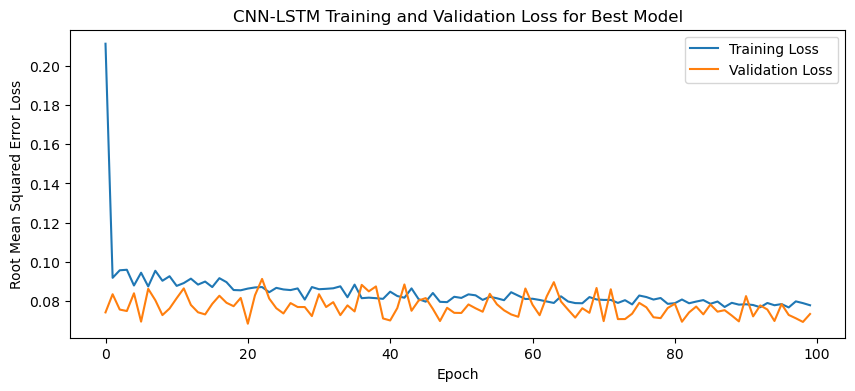

1/1 - 1s - loss: 0.0960 - 869ms/epoch - 869ms/step
Test Loss: 0.09603211283683777
Fold 2:
Epoch 1/100
19/19 [==============================] - 5s 80ms/step - loss: 0.2187 - val_loss: 0.0682
Epoch 2/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0930 - val_loss: 0.0714
Epoch 3/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0958 - val_loss: 0.0774
Epoch 4/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0977 - val_loss: 0.0740
Epoch 5/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0947 - val_loss: 0.0747
Epoch 6/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0906 - val_loss: 0.0991
Epoch 7/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0910 - val_loss: 0.0838
Epoch 8/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0944 - val_loss: 0.0779
Epoch 9/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0932 - val_loss: 0.0689
Epoch 10/1

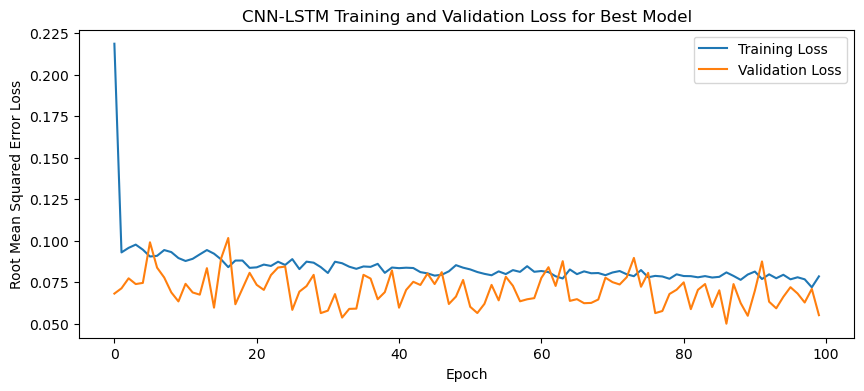

1/1 - 1s - loss: 0.0961 - 882ms/epoch - 882ms/step
Test Loss: 0.0961136743426323
Fold 3:
Epoch 1/100
19/19 [==============================] - 5s 85ms/step - loss: 0.2064 - val_loss: 0.0833
Epoch 2/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0959 - val_loss: 0.0844
Epoch 3/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0970 - val_loss: 0.0714
Epoch 4/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0945 - val_loss: 0.0757
Epoch 5/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0958 - val_loss: 0.0945
Epoch 6/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0916 - val_loss: 0.0653
Epoch 7/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0899 - val_loss: 0.0703
Epoch 8/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0974 - val_loss: 0.0908
Epoch 9/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0956 - val_loss: 0.0661
Epoch 10/10

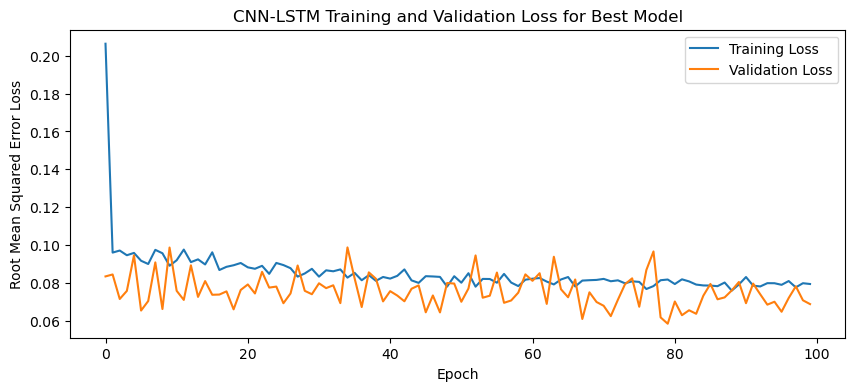

1/1 - 1s - loss: 0.0932 - 916ms/epoch - 916ms/step
Test Loss: 0.09321828186511993
Fold 4:
Epoch 1/100
20/20 [==============================] - 5s 77ms/step - loss: 0.3154 - val_loss: 0.1173
Epoch 2/100
20/20 [==============================] - 1s 27ms/step - loss: 0.1249 - val_loss: 0.0975
Epoch 3/100
20/20 [==============================] - 1s 27ms/step - loss: 0.1291 - val_loss: 0.1191
Epoch 4/100
20/20 [==============================] - 1s 27ms/step - loss: 0.1276 - val_loss: 0.1053
Epoch 5/100
20/20 [==============================] - 1s 28ms/step - loss: 0.1243 - val_loss: 0.0967
Epoch 6/100
20/20 [==============================] - 1s 28ms/step - loss: 0.1277 - val_loss: 0.0868
Epoch 7/100
20/20 [==============================] - 1s 28ms/step - loss: 0.1225 - val_loss: 0.0714
Epoch 8/100
20/20 [==============================] - 1s 27ms/step - loss: 0.1244 - val_loss: 0.1076
Epoch 9/100
20/20 [==============================] - 1s 27ms/step - loss: 0.1261 - val_loss: 0.0789
Epoch 10/1

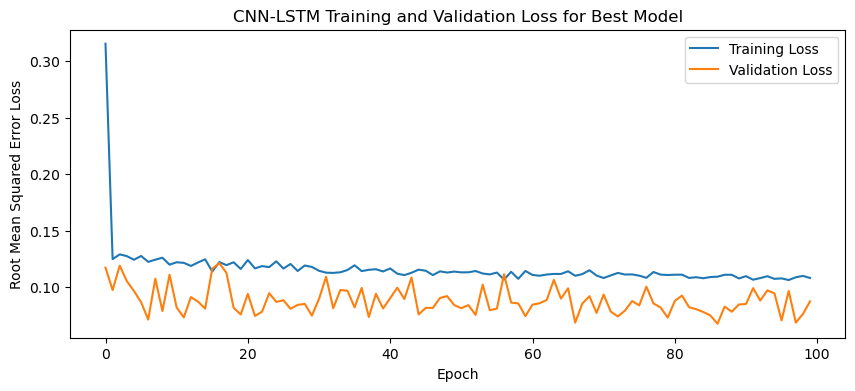

1/1 - 1s - loss: 0.1063 - 1s/epoch - 1s/step
Test Loss: 0.10626128315925598
Fold 5:
Epoch 1/100
19/19 [==============================] - 5s 83ms/step - loss: 0.2010 - val_loss: 0.0953
Epoch 2/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0903 - val_loss: 0.1024
Epoch 3/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0916 - val_loss: 0.0717
Epoch 4/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0952 - val_loss: 0.0961
Epoch 5/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0915 - val_loss: 0.0762
Epoch 6/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0958 - val_loss: 0.0706
Epoch 7/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0949 - val_loss: 0.1112
Epoch 8/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0915 - val_loss: 0.1051
Epoch 9/100
19/19 [==============================] - 1s 27ms/step - loss: 0.0899 - val_loss: 0.1128
Epoch 10/100
19/

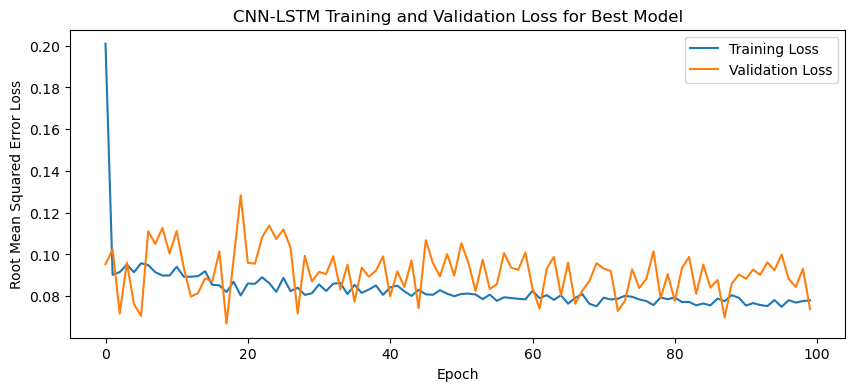

1/1 - 1s - loss: 0.0751 - 949ms/epoch - 949ms/step
Test Loss: 0.07506825774908066


In [3]:
n_batch = 1
nb_epoch = 100

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def mape (y_true, y_pred):
    return 100*K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def pearson (y_true, y_pred):
    return (K.square(K.mean((y_true - K.mean(y_true))*(y_pred - K.mean(y_pred)))))/(K.mean(K.square(y_true - K.mean(y_true)))*K.mean(K.square(y_pred - K.mean(y_pred))))
 
# fit an LSTM network to training data
#Adapted from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch):

    cv_accuracies = []
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters to be tuned by Optuna (taken from Javier Leon's dissertation 'Fruit Prices')
    lr = trial.suggest_float('lr', 1e-3, 1, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'RMSprop', 'SGD'])
    if optimizer_name == 'Adam':
        optimizer = Adam(learning_rate=lr)
    elif optimizer_name == 'RMSprop':
        optimizer = RMSprop(learning_rate=lr)
    else:
        optimizer = SGD(learning_rate=lr)
    
    #Optuna will try either Rectified Linear Unit (ReLU) = max(0, x), tanh, or sigmoid functions
    activation_function = trial.suggest_categorical('activation_function', ['relu', 'tanh', 'sigmoid'])
    
    lstm_units = trial.suggest_categorical('lstm_units', [256, 512, 1024])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # design network
    model = Sequential()
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer)
        
    return model
    
def objective(trial):
    
    cv_accuracies = []
        
    for i in range(5):
        train1 = train[i]
        test1 = test[i]
        validation1 = validation[i]

        X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
        X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
        X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
        X = X.reshape(X.shape[0], 1, X.shape[1])
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
        X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])
    
        model = create_model(trial, X, y, n_lag, n_seq, n_batch, nb_epoch)

        history = model.fit(X, y, validation_data=(X_val, y_val), epochs=nb_epoch, verbose=0)

        cv_accuracy = model.evaluate(X_test, y_test, verbose=0)
    
        loss = history.history['val_loss'][-1]
    
        # Plotting the training and validation loss
        #plt.figure(figsize=(10, 4))
        #plt.plot(history.history['loss'], label='Training Loss')
        #plt.plot(history.history['val_loss'], label='Validation Loss')
        #title1 = "LSTM Training and Validation Loss for Fold " + str(i+1)
        #plt.title(title1)
        #plt.xlabel('Epoch')
        #plt.ylabel('Root Mean Squared Error Loss')
        #plt.legend()
        #plt.show()
            
        cv_accuracies.append(cv_accuracy)
    
    print("Cross Validation Accuracies:")
    print(cv_accuracies)
    print("Mean Cross Validation Accuracy:")
    print(np.mean(cv_accuracies))
    print("Standard Deviation of Cross Validation Accuracy:")
    print(np.std(cv_accuracies))
        
    return np.mean(cv_accuracies)

n_batch = 1
nb_epoch = 100

# optimize and fit model
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)
print('Number of finished trials:', len(study.trials))

print('Best trial:', study.best_trial.params)
best_params = study.best_params
print("Best hyperparameters: ", best_params)

for i in range(5):
    print("Fold "+str(i+1)+":")
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X, y = train1[:, 0:-n_seq], train1[:, -n_seq:]
    X_test, y_test = test1[:, 0:-n_seq], test1[:, -n_seq:]
    X_val, y_val = validation1[:, 0:-n_seq], validation1[:, -n_seq:]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_model(optuna.trial.FixedTrial(best_params), X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 4))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title1 = "CNN-LSTM Training and Validation Loss for Best Model"
    plt.title(title1)
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error Loss')
    plt.legend()
    plt.show()

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

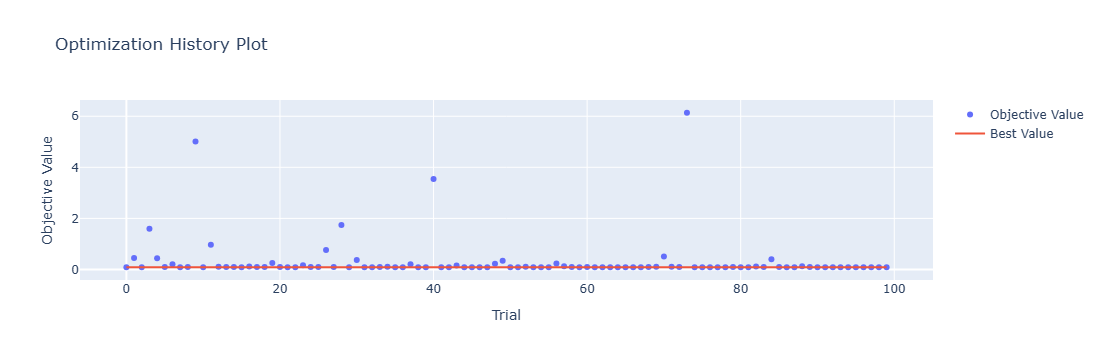

In [4]:
optuna.visualization.plot_optimization_history(study)

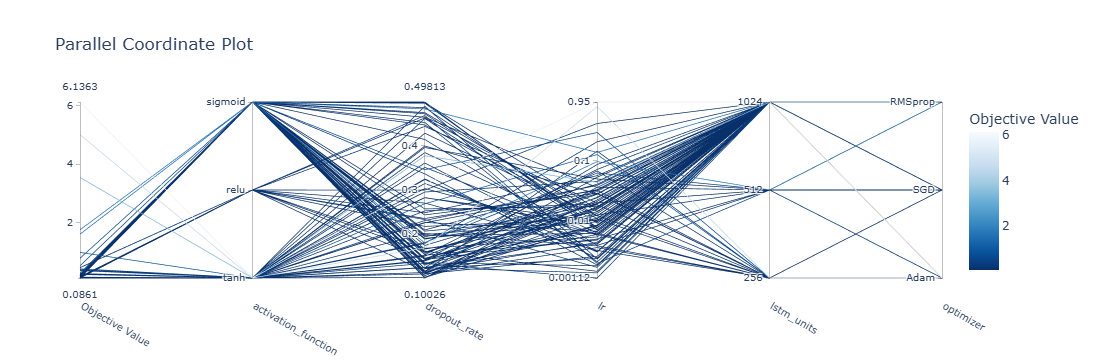

In [5]:
optuna.visualization.plot_parallel_coordinate(study)

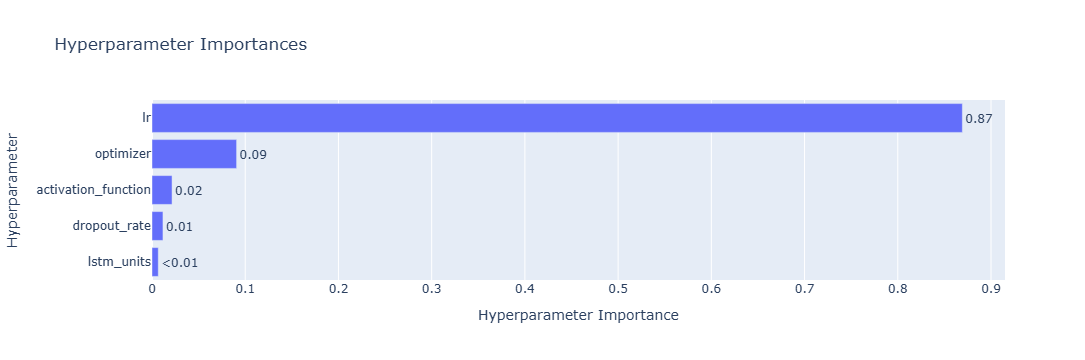

In [6]:
optuna.visualization.plot_param_importances(study)

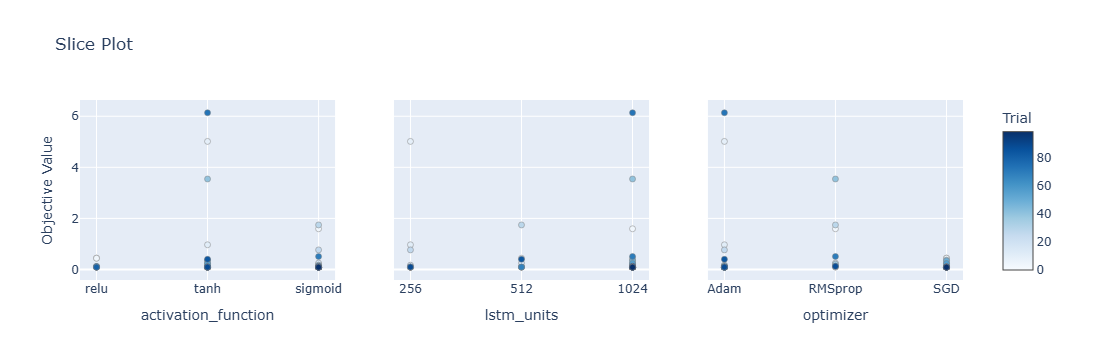

In [7]:
optuna.visualization.plot_slice(study, params=['optimizer', 'activation_function', 'lstm_units'])

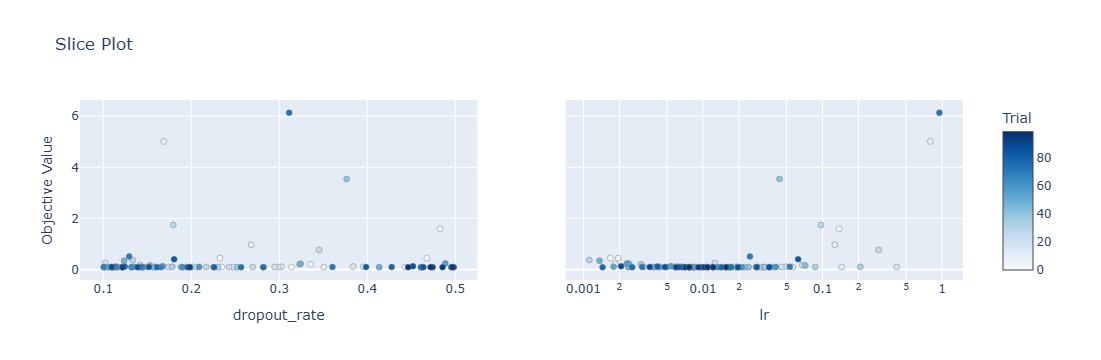

In [8]:
optuna.visualization.plot_slice(study, params=['lr', 'dropout_rate'])

[[12.82 12.33 12.14 11.9  12.75 12.05 11.96 11.88 11.66 11.6  11.21 11.85
  11.29 12.12 12.23 11.95 11.91 12.96 13.05 13.43 12.59 12.54 12.66 12.47
  12.18 12.49 13.25]
 [10.07  9.17  8.73  9.1   9.64  9.62  9.38  9.31  8.9   8.65  8.67  9.09
   8.97  9.33  9.58  9.53  9.17 10.25  9.66 10.33 10.45 10.26 10.47 10.03
   9.51  9.7  10.33]]
Epoch 1/100
19/19 [==============================] - 6s 120ms/step - loss: 0.2147 - accuracy: 0.2105 - mae: 0.2000 - rmse: 0.2147 - mape: 46.7454 - pearson: 0.1731 - val_loss: 0.0858 - val_accuracy: 0.3333 - val_mae: 0.0726 - val_rmse: 0.0858 - val_mape: 17.4156 - val_pearson: 0.2829
Epoch 2/100
19/19 [==============================] - 1s 34ms/step - loss: 0.1002 - accuracy: 0.2105 - mae: 0.0837 - rmse: 0.1002 - mape: 20.1556 - pearson: 0.2055 - val_loss: 0.0893 - val_accuracy: 0.0000e+00 - val_mae: 0.0718 - val_rmse: 0.0893 - val_mape: 17.9797 - val_pearson: 0.3010
Epoch 3/100
19/19 [==============================] - 1s 39ms/step - loss: 0.0909 - accur

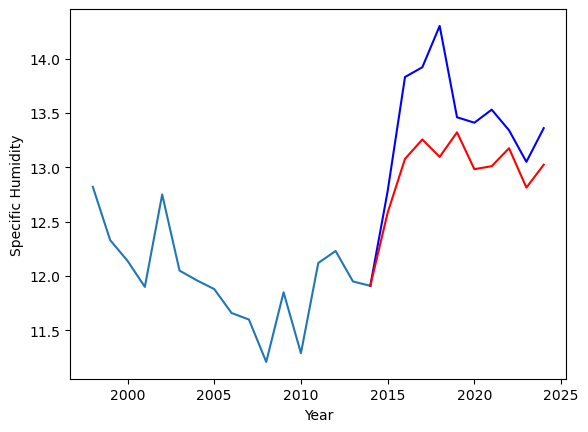

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
9.71		9.83		0.12
10.79		10.33		-0.46
10.20		10.51		0.31
10.87		10.36		-0.51
10.99		10.59		-0.40
10.80		10.25		-0.55
11.01		10.28		-0.73
10.57		10.44		-0.13
10.05		10.08		0.03
10.24		10.29		0.05


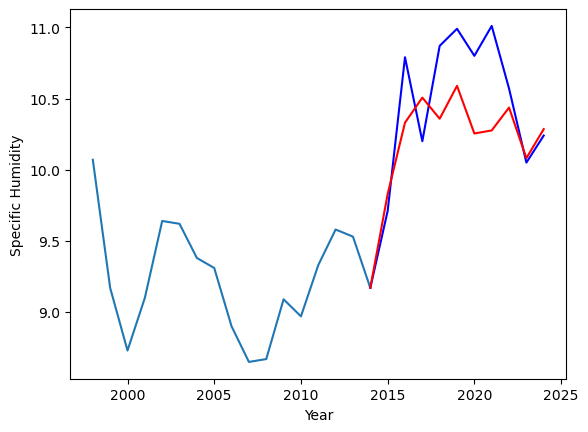

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   12.78  12.582256
1                1    9.71   9.828859


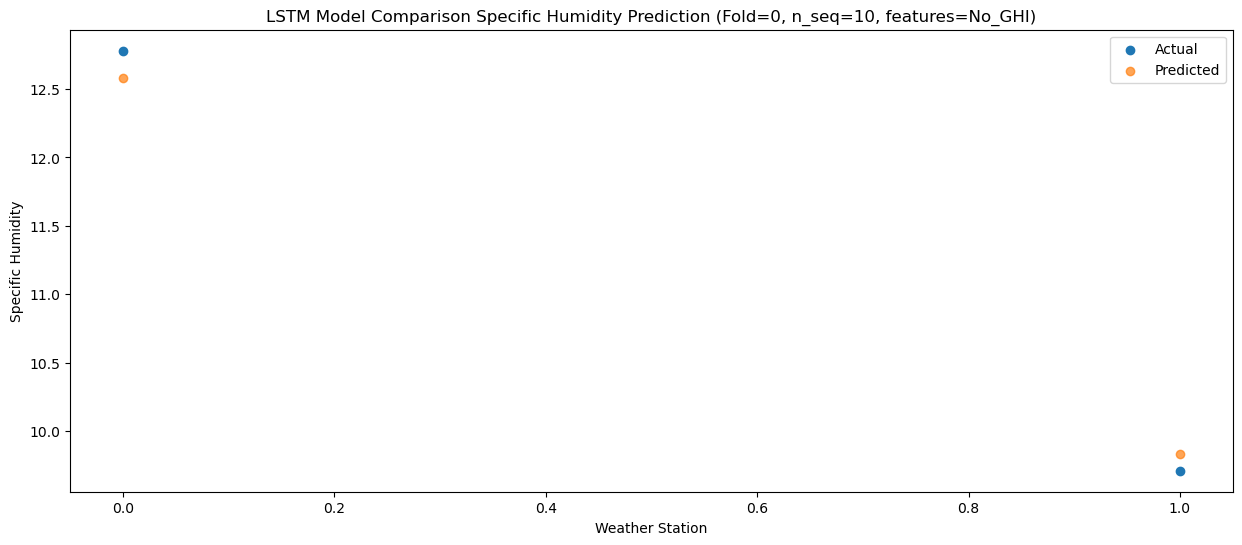

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   13.83  13.076971
1                1   10.79  10.330345


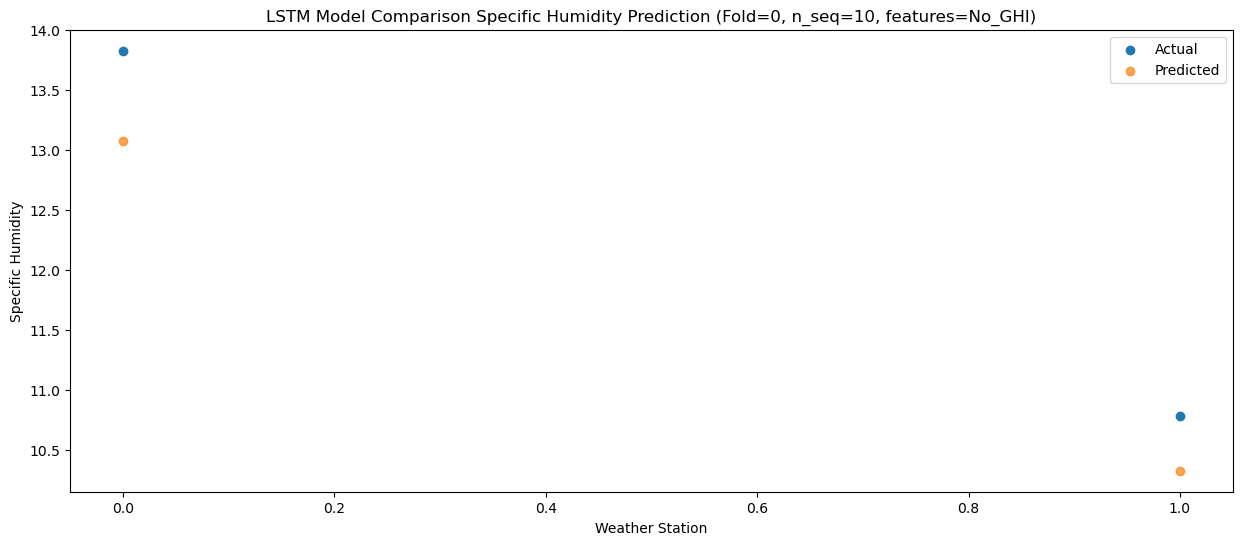

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   13.92  13.255753
1                1   10.20  10.506441


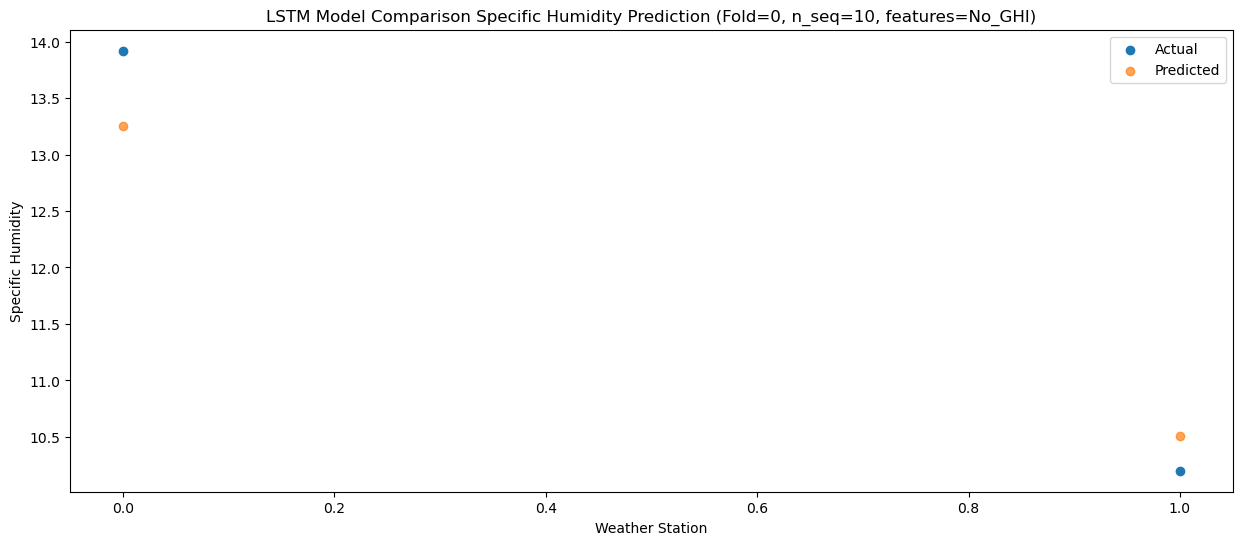

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   14.30  13.095503
1                1   10.87  10.358212


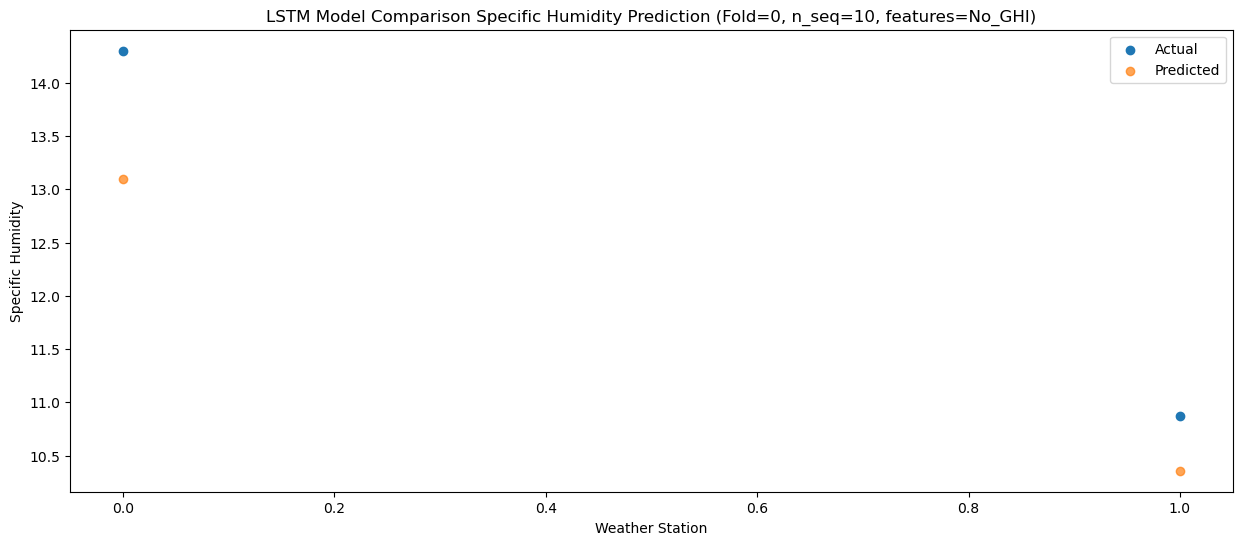

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   13.46  13.321596
1                1   10.99  10.589014


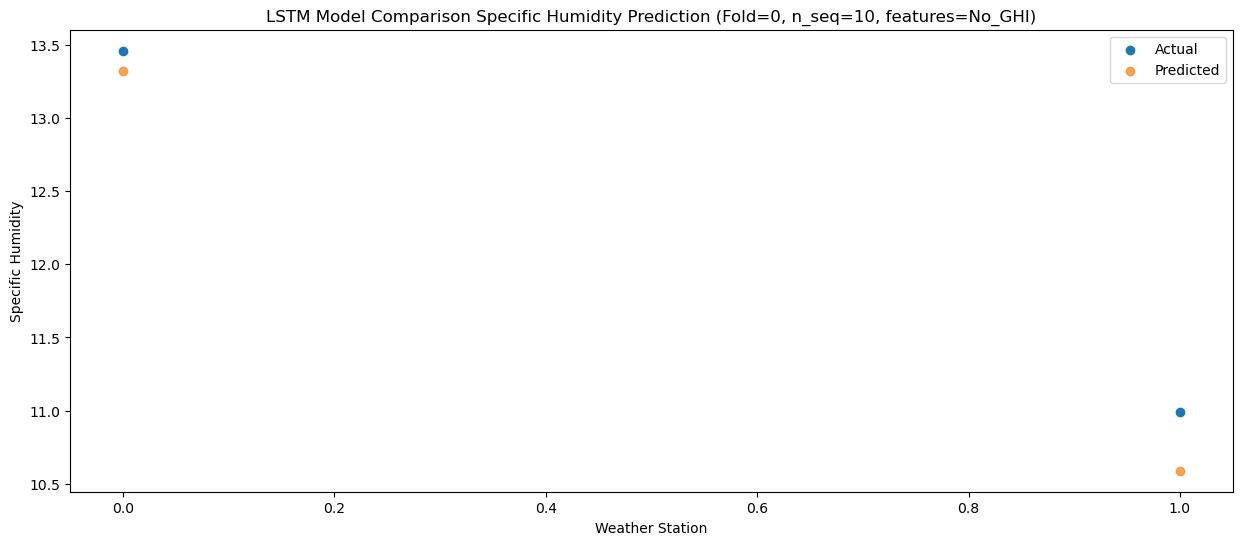

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   13.41  12.982477
1                1   10.80  10.254549


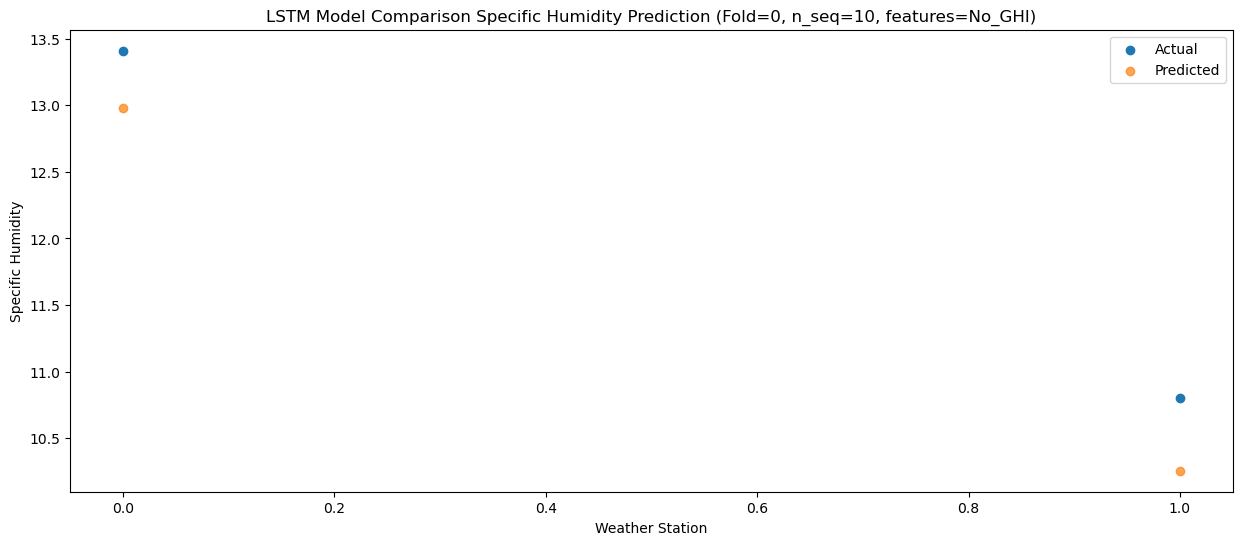

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   13.53  13.010050
1                1   11.01  10.275939


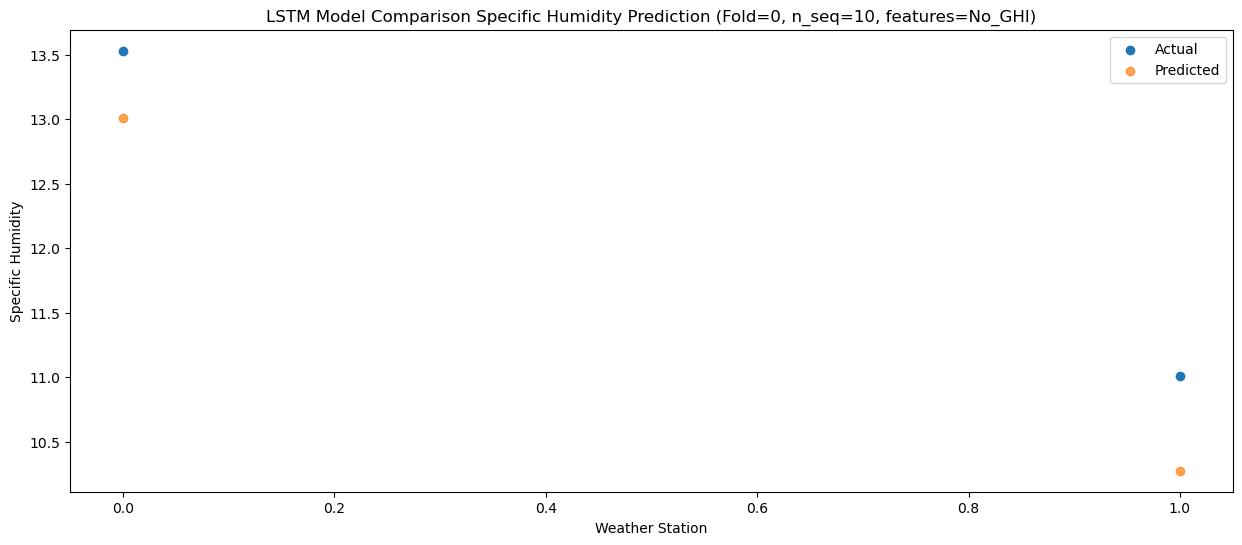

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   13.34  13.175134
1                1   10.57  10.436601


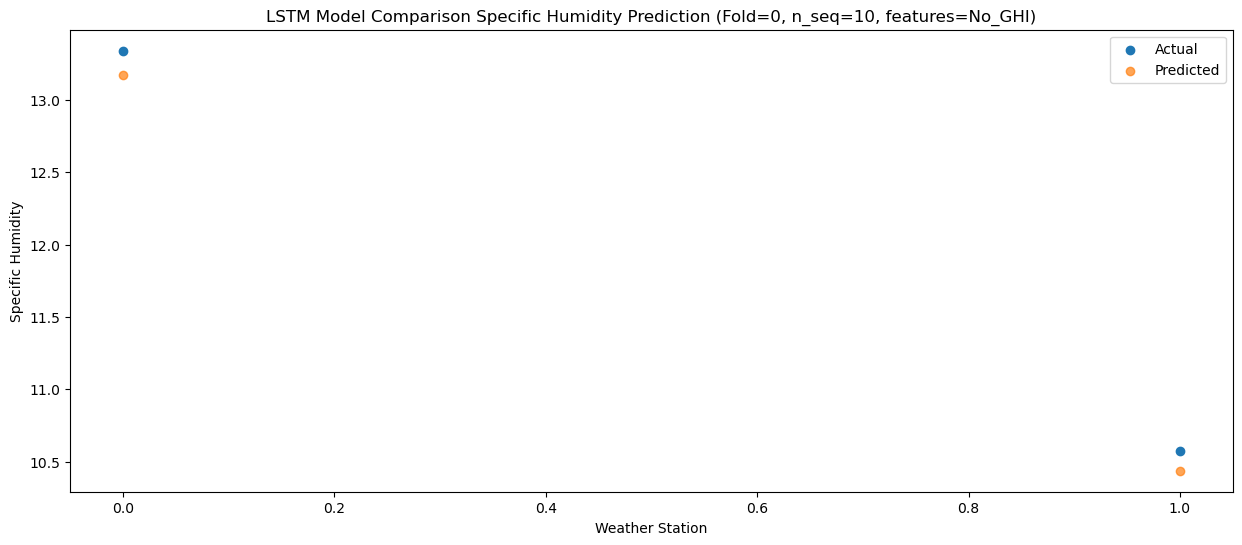

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   13.05  12.813253
1                1   10.05  10.081375


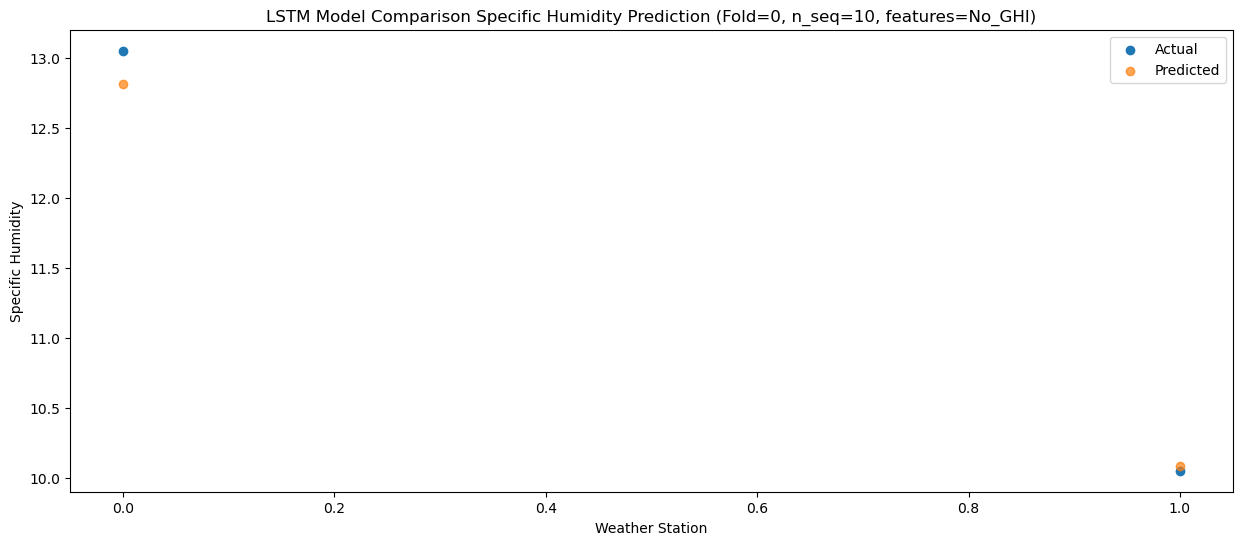

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   13.36  13.023565
1                1   10.24  10.285239


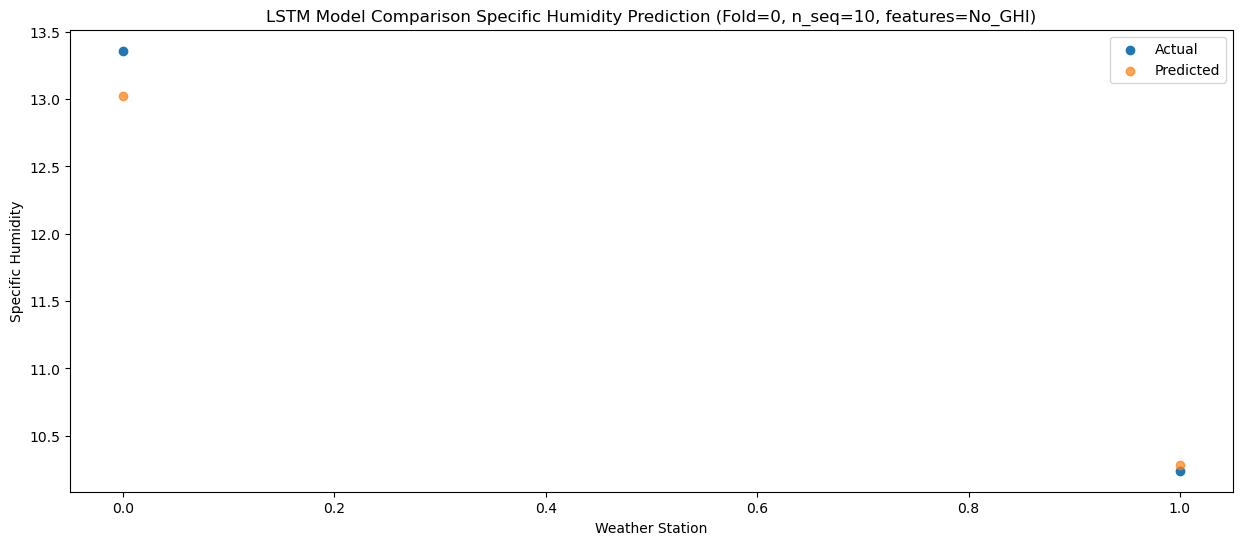

f, t:
[[12.78  9.71]
 [13.83 10.79]
 [13.92 10.2 ]
 [14.3  10.87]
 [13.46 10.99]
 [13.41 10.8 ]
 [13.53 11.01]
 [13.34 10.57]
 [13.05 10.05]
 [13.36 10.24]]
[[12.58225577  9.82885895]
 [13.07697108 10.33034465]
 [13.25575336 10.50644118]
 [13.09550326 10.35821172]
 [13.321596   10.58901439]
 [12.98247711 10.25454948]
 [13.01004974 10.27593905]
 [13.17513405 10.43660098]
 [12.81325312 10.08137456]
 [13.02356535 10.28523864]]
Year at t+1:
t+1 SKRMSE: 0.163141
t+1 KRMSE: 0.163141
t+1 MAE: 0.158302
t+1 SKMAPE: 0.013857
t+1 R2_SCORE: 0.988704
t+1 KMAPE: 0.013857
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 11.245000
Year at t+2:
t+2 SKRMSE: 0.623833
t+2 KRMSE: 0.623833
t+2 MAE: 0.606342
t+2 SKMAPE: 0.048525
t+2 R2_SCORE: 0.831558
t+2 KMAPE: 0.048525
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 12.310000
Year at t+3:
t+3 SKRMSE: 0.517267
t+3 KRMSE: 0.517267
t+3 MAE: 0.485344
t+3 SKMAPE: 0.038881
t+3 R2_SCORE: 0.922660
t+3 KMAPE: 0.038881
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 12.060000
Year at 

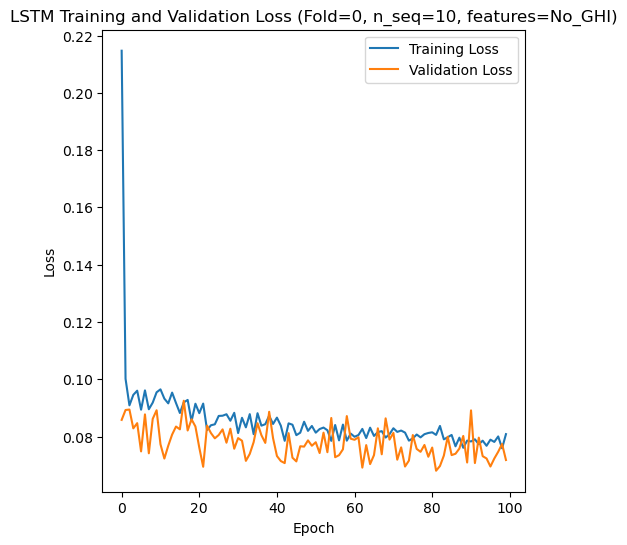

[[11.47 10.69 10.49 10.89 11.27 10.87 11.1  11.03 10.18 10.34 10.24 10.68
  10.6  10.94 10.76 10.47 10.42 11.26 10.81 11.26 11.81 11.14 11.5  10.83
  10.88 10.74 11.48]
 [ 7.63  7.36  7.16  7.53  7.72  7.87  8.49  7.73  6.89  8.03  6.62  6.93
   7.69  5.78  7.04  6.89  7.21  8.34  8.32  7.95  7.79  7.82  7.08  7.52
   6.95  7.1   7.65]]
Epoch 1/100
19/19 [==============================] - 7s 111ms/step - loss: 0.2279 - accuracy: 0.1579 - mae: 0.2110 - rmse: 0.2279 - mape: 47.2130 - pearson: 0.1132 - val_loss: 0.0817 - val_accuracy: 0.0000e+00 - val_mae: 0.0682 - val_rmse: 0.0817 - val_mape: 16.3940 - val_pearson: 0.2990
Epoch 2/100
19/19 [==============================] - 1s 29ms/step - loss: 0.0967 - accuracy: 0.3158 - mae: 0.0794 - rmse: 0.0967 - mape: 18.8906 - pearson: 0.2270 - val_loss: 0.0808 - val_accuracy: 0.0000e+00 - val_mae: 0.0684 - val_rmse: 0.0808 - val_mape: 16.3792 - val_pearson: 0.2822
Epoch 3/100
19/19 [==============================] - 1s 29ms/step - loss: 0.0948 - a

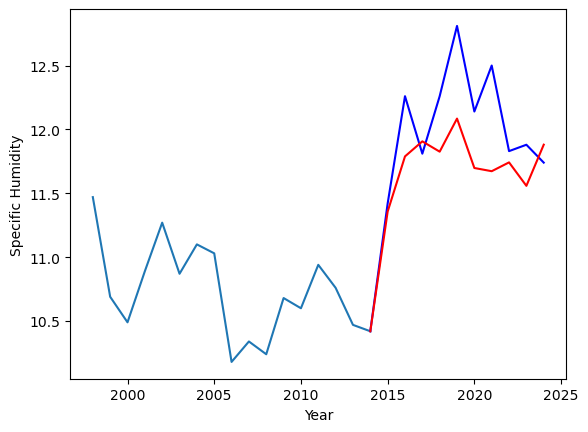

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.95		7.56		-0.39
9.08		8.00		-1.08
9.06		8.12		-0.94
8.69		8.04		-0.65
8.53		8.28		-0.25
8.56		7.93		-0.63
7.82		7.91		0.09
8.26		7.99		-0.27
7.69		7.80		0.11
7.84		8.15		0.31


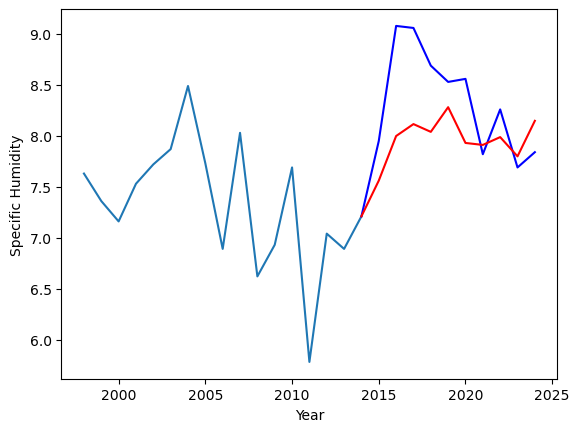

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.42  11.356635
1                1    7.95   7.560466


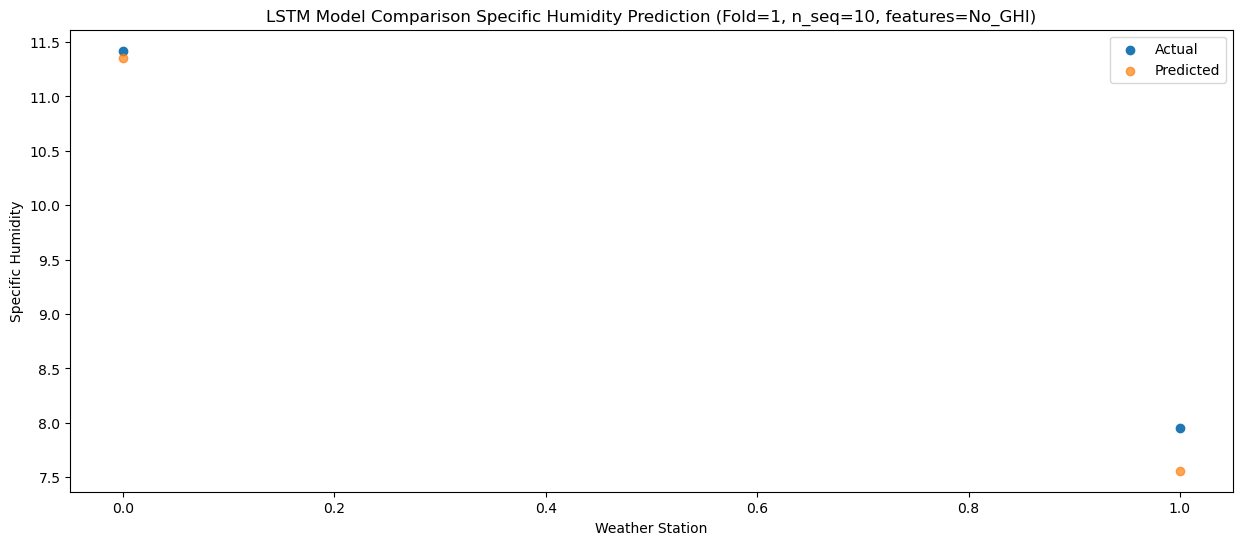

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.26  11.788717
1                1    9.08   7.998673


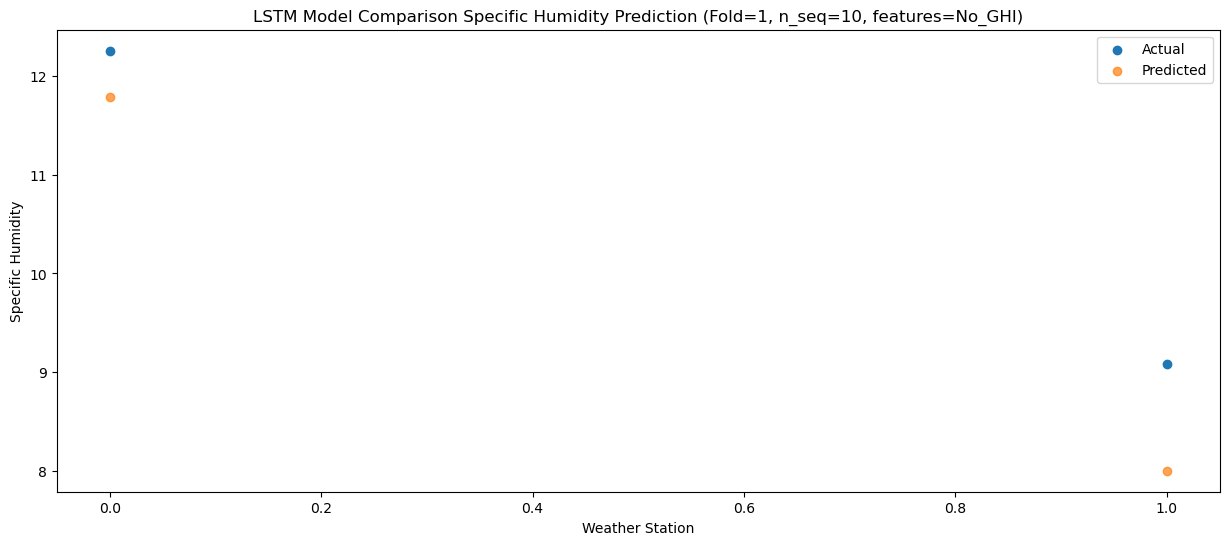

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   11.81  11.906424
1                1    9.06   8.115828


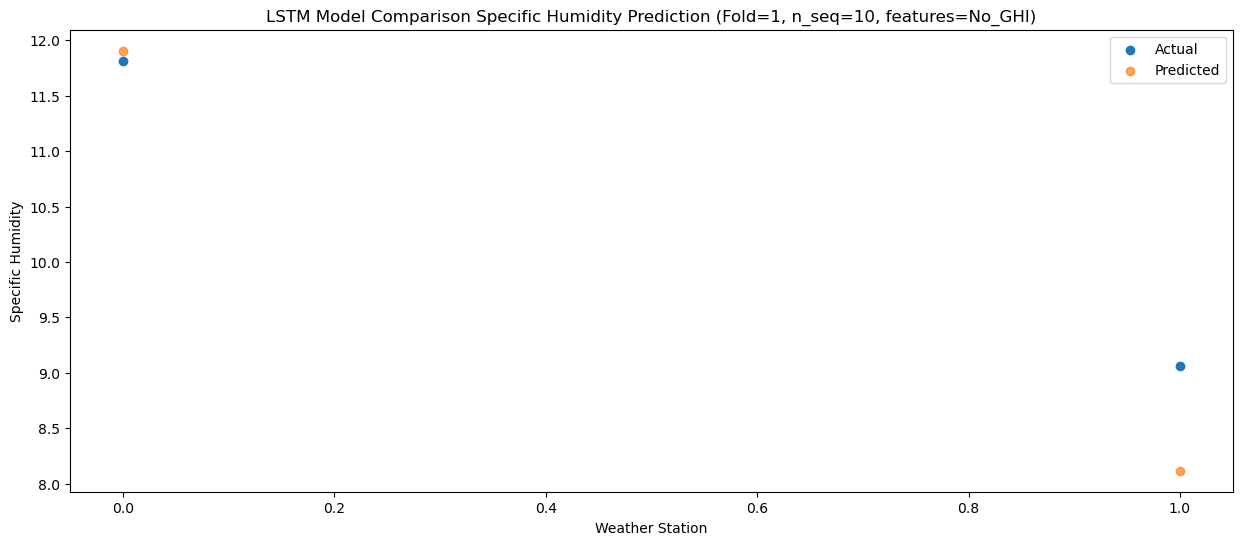

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.26  11.825735
1                1    8.69   8.039464


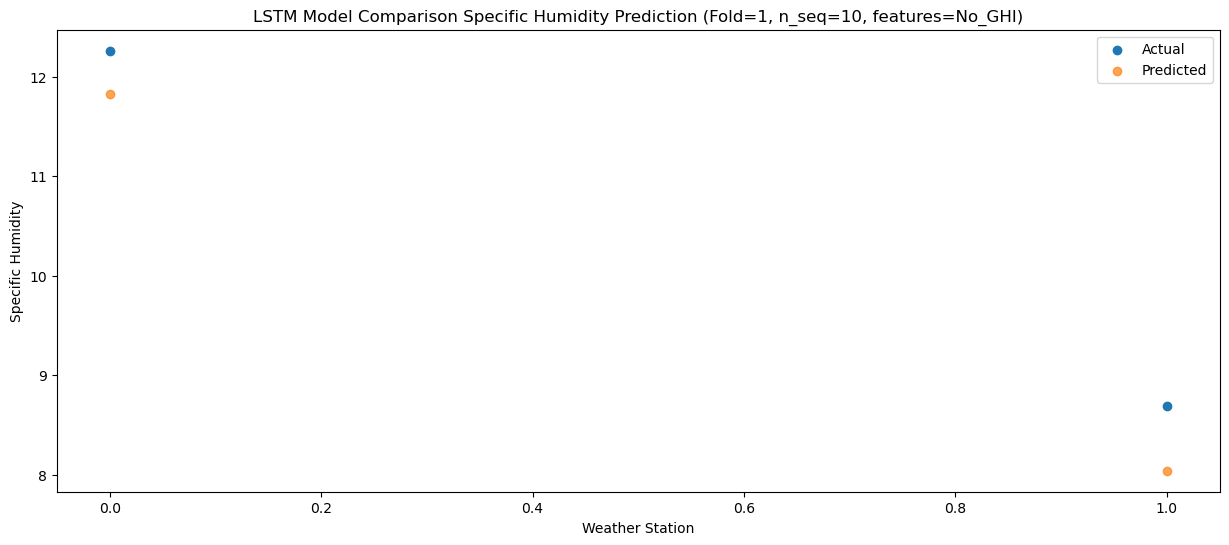

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   12.81  12.084667
1                1    8.53   8.281882


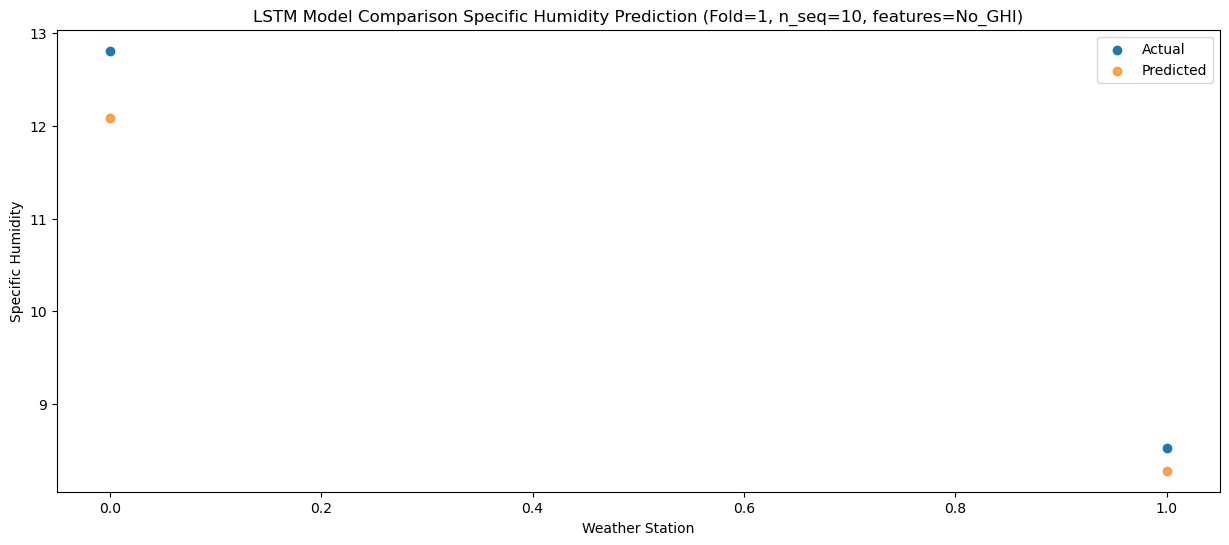

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   12.14  11.697938
1                1    8.56   7.930642


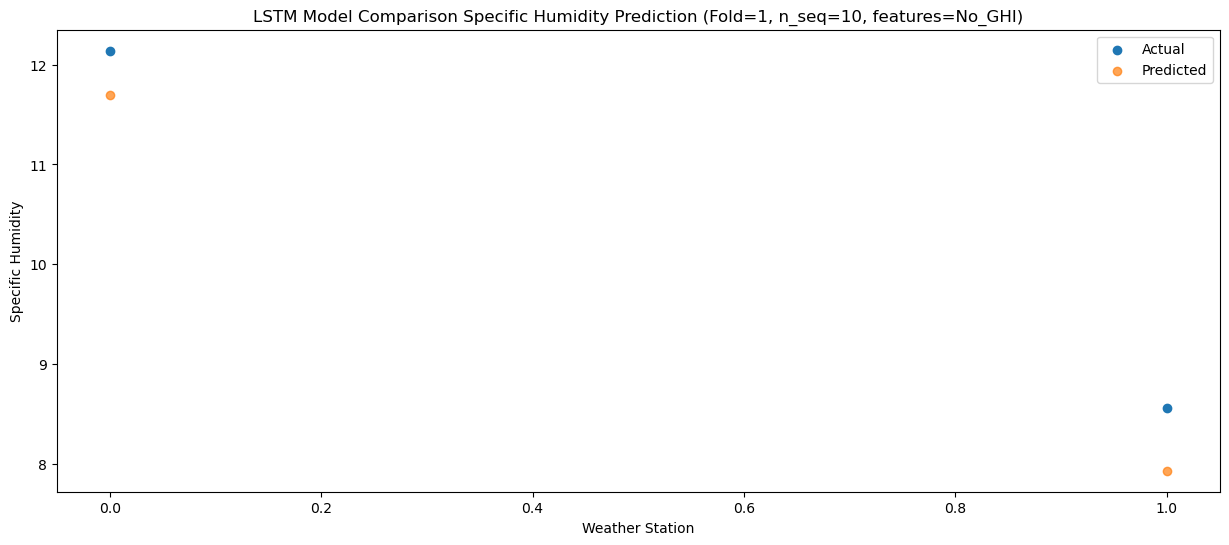

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   12.50  11.672809
1                1    7.82   7.911222


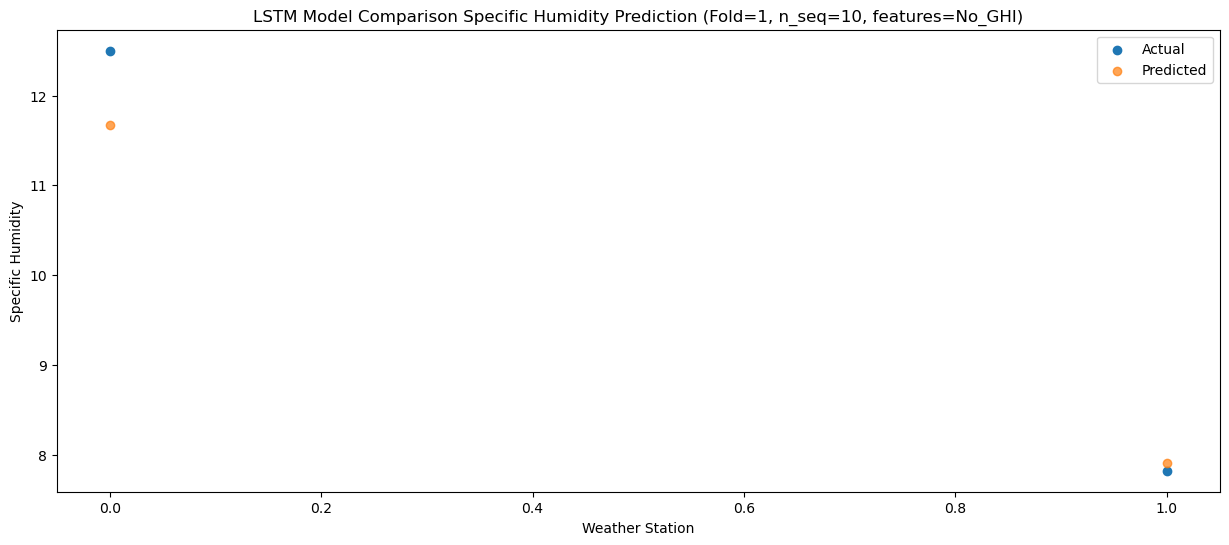

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   11.83  11.741871
1                1    8.26   7.988004


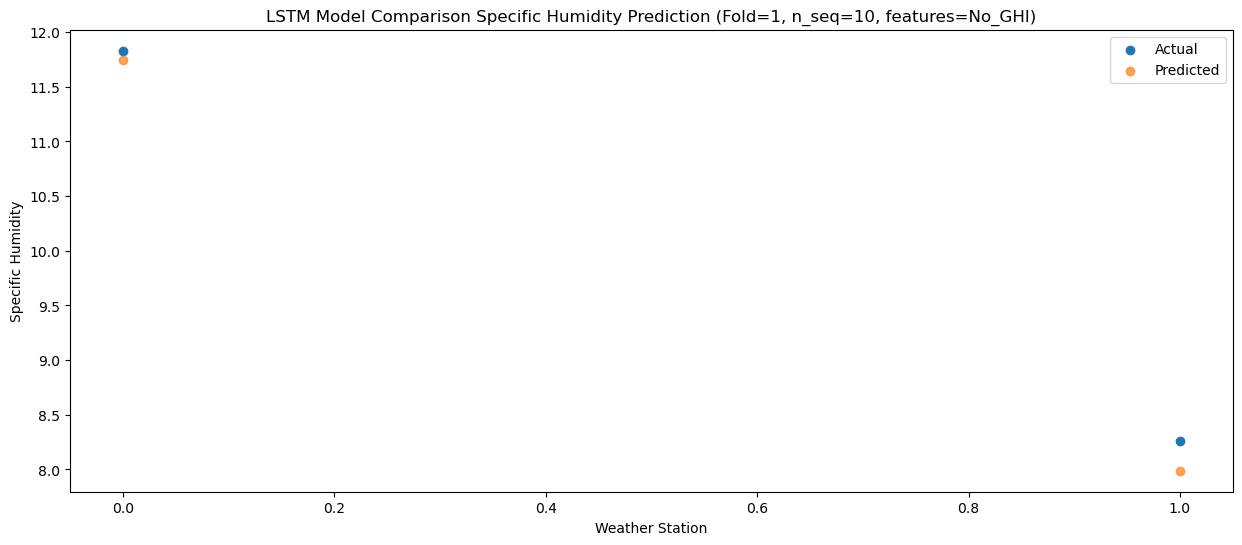

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   11.88  11.558262
1                1    7.69   7.799023


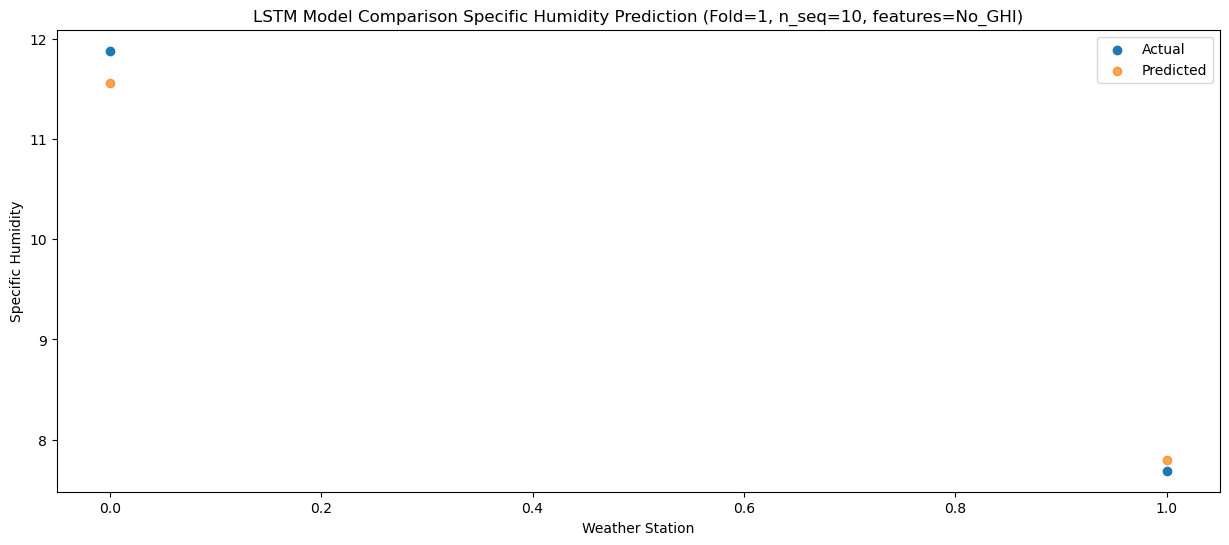

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   11.74  11.880372
1                1    7.84   8.147944


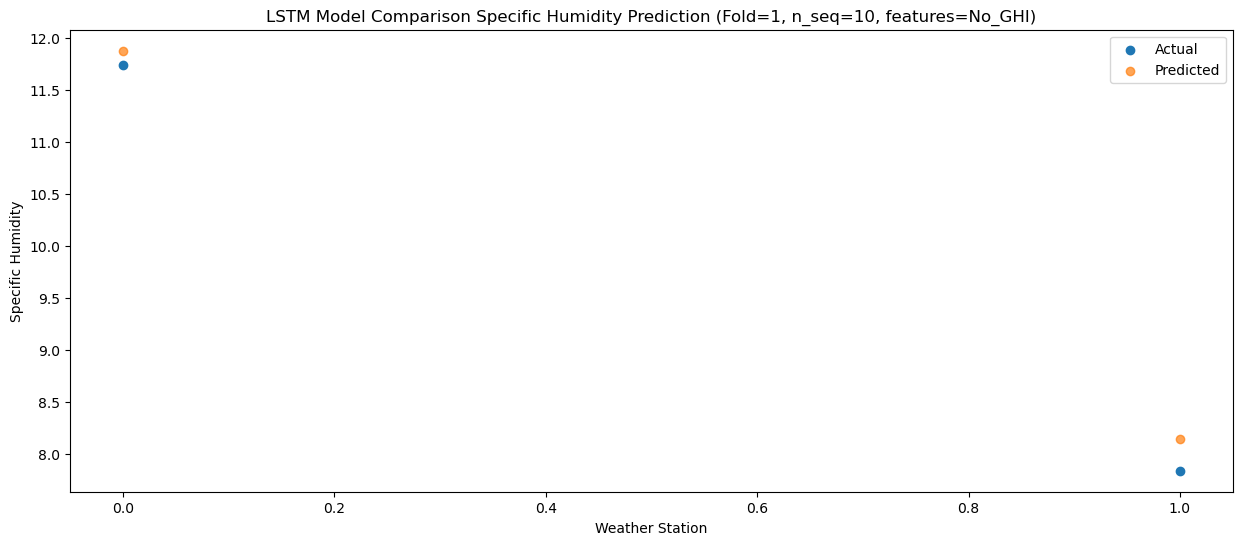

f, t:
[[11.42  7.95]
 [12.26  9.08]
 [11.81  9.06]
 [12.26  8.69]
 [12.81  8.53]
 [12.14  8.56]
 [12.5   7.82]
 [11.83  8.26]
 [11.88  7.69]
 [11.74  7.84]]
[[11.3566346   7.56046571]
 [11.78871735  7.99867318]
 [11.90642376  8.11582777]
 [11.82573485  8.03946396]
 [12.08466654  8.28188233]
 [11.69793784  7.93064187]
 [11.67280877  7.91122185]
 [11.74187103  7.98800413]
 [11.5582622   7.79902318]
 [11.88037237  8.14794445]]
Year at t+1:
t+1 SKRMSE: 0.279063
t+1 KRMSE: 0.279063
t+1 MAE: 0.226450
t+1 SKMAPE: 0.027273
t+1 R2_SCORE: 0.974129
t+1 KMAPE: 0.027273
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.685000
Year at t+2:
t+2 SKRMSE: 0.834079
t+2 KRMSE: 0.834079
t+2 MAE: 0.776305
t+2 SKMAPE: 0.078765
t+2 R2_SCORE: 0.724818
t+2 KMAPE: 0.078765
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 10.670000
Year at t+3:
t+3 SKRMSE: 0.671103
t+3 KRMSE: 0.671103
t+3 MAE: 0.520298
t+3 SKMAPE: 0.056189
t+3 R2_SCORE: 0.761783
t+3 KMAPE: 0.056189
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 10.435000
Year at t

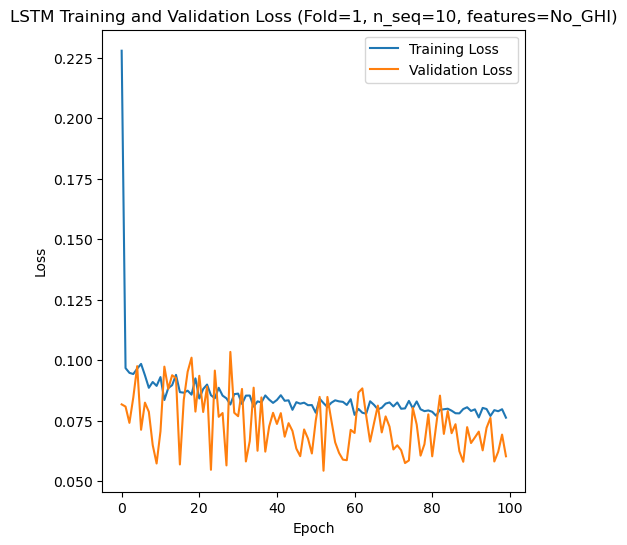

[[ 9.91  9.14  8.93  8.85  8.98  9.08  8.94  8.84  8.35  8.13  8.01  8.88
   8.79  8.86  9.22  8.7   8.51  9.48  9.05  9.73 10.13  9.86  9.33  8.92
   8.82  9.09  9.65]
 [ 8.49  7.33  7.71  7.76  7.77  7.75  7.45  7.41  7.43  7.25  7.05  7.35
   7.52  7.92  7.47  7.81  7.    7.75  8.3   8.25  8.35  7.7   7.52  7.59
   7.86  7.87  8.55]]
Epoch 1/100
19/19 [==============================] - 6s 95ms/step - loss: 0.2337 - accuracy: 0.1053 - mae: 0.2150 - rmse: 0.2337 - mape: 47.4965 - pearson: 0.0812 - val_loss: 0.0820 - val_accuracy: 0.3333 - val_mae: 0.0631 - val_rmse: 0.0820 - val_mape: 16.2304 - val_pearson: 0.2491
Epoch 2/100
19/19 [==============================] - 1s 29ms/step - loss: 0.1021 - accuracy: 0.2632 - mae: 0.0839 - rmse: 0.1021 - mape: 19.9925 - pearson: 0.1524 - val_loss: 0.0949 - val_accuracy: 0.3333 - val_mae: 0.0777 - val_rmse: 0.0949 - val_mape: 18.6761 - val_pearson: 0.1233
Epoch 3/100
19/19 [==============================] - 1s 29ms/step - loss: 0.0919 - accuracy: 

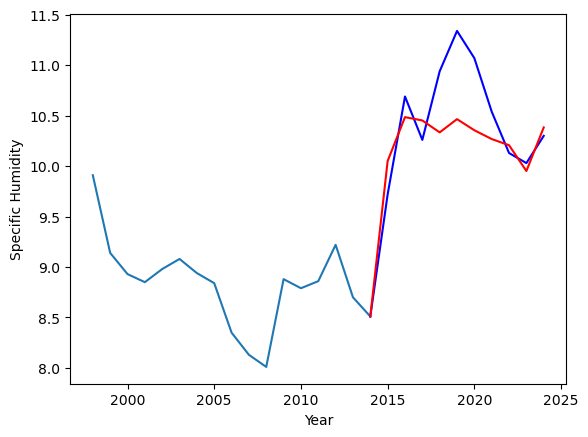

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.68		8.60		0.92
8.43		9.02		0.59
8.98		9.01		0.03
8.93		8.88		-0.05
9.03		9.03		0.00
8.38		8.91		0.53
8.20		8.81		0.61
8.27		8.78		0.51
8.54		8.51		-0.03
8.55		8.94		0.39


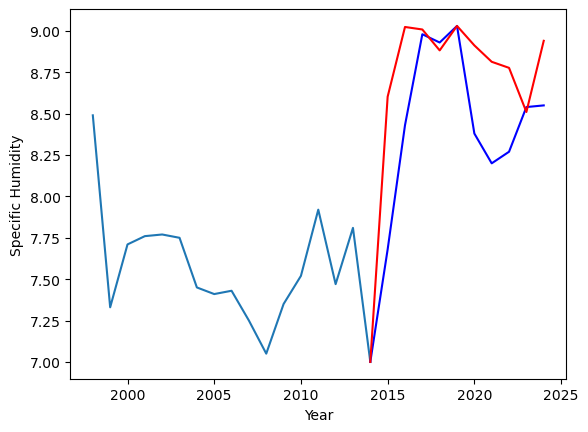

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    9.72  10.050949
1                1    7.68   8.602564


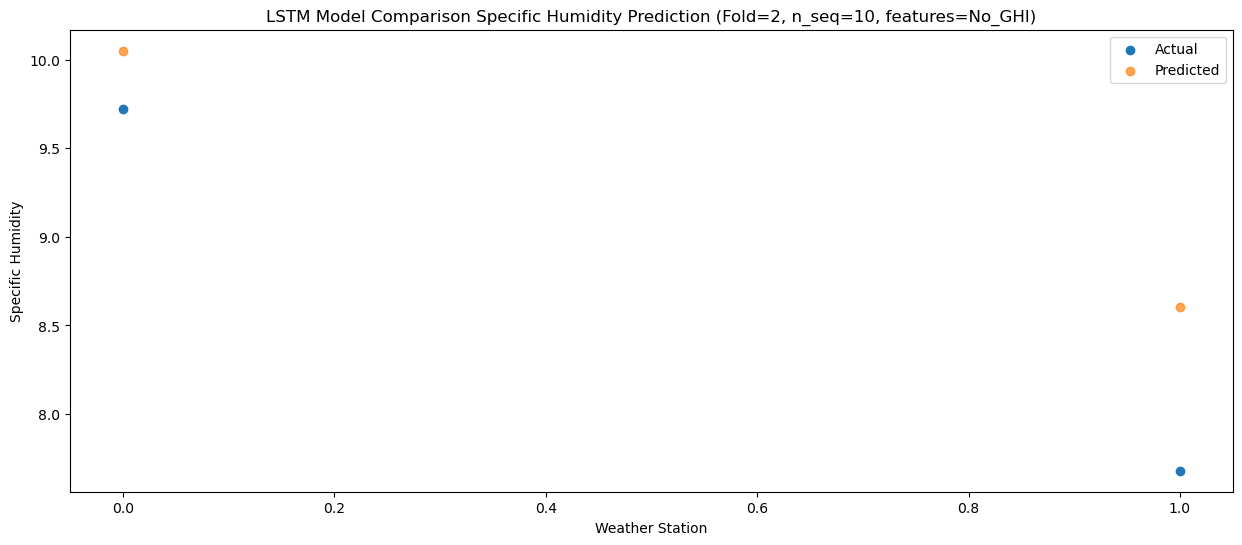

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   10.69  10.485583
1                1    8.43   9.023892


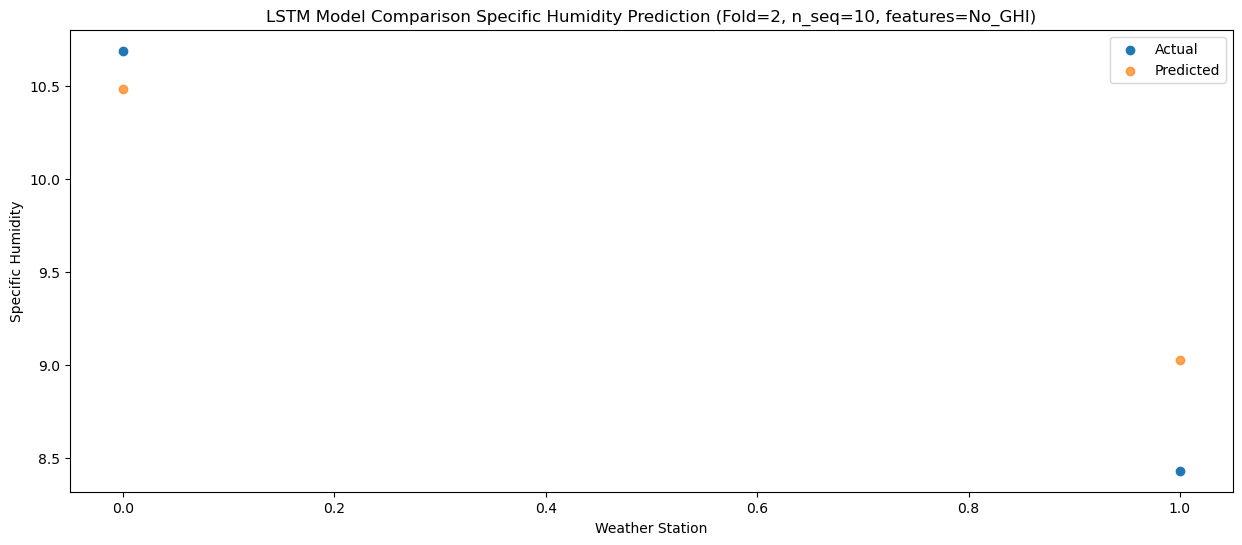

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   10.26  10.452706
1                1    8.98   9.008688


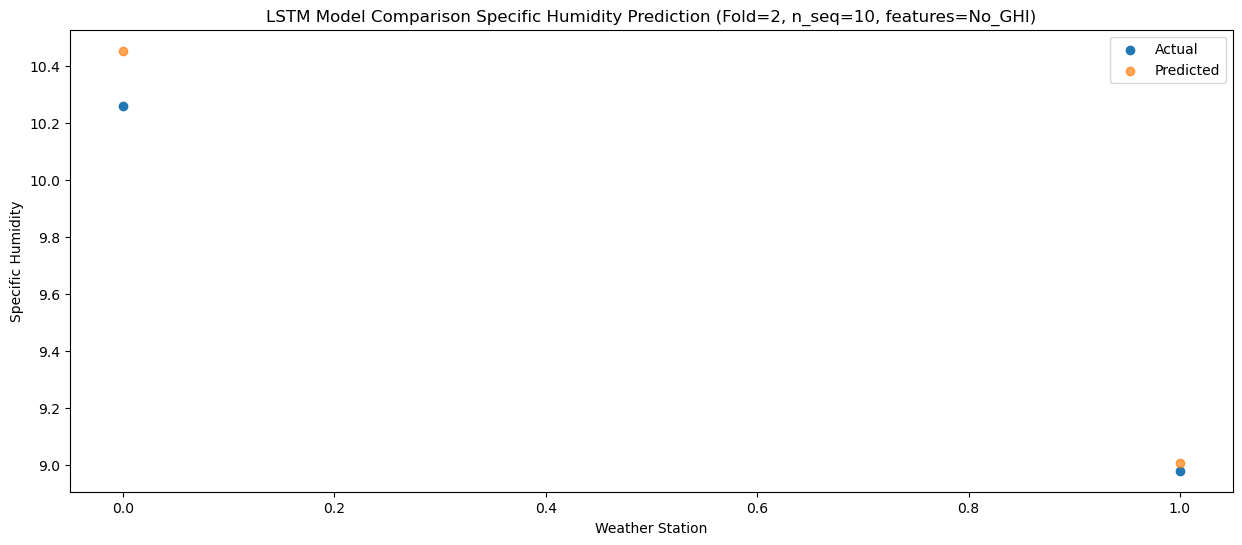

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   10.94  10.334425
1                1    8.93   8.882346


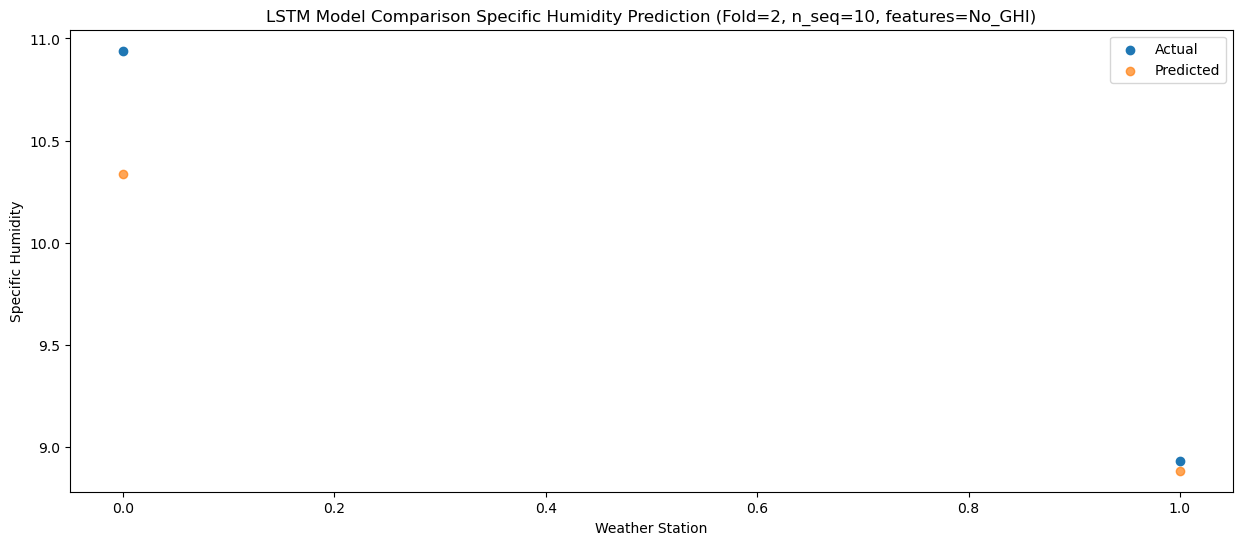

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.34  10.465647
1                1    9.03   9.030241


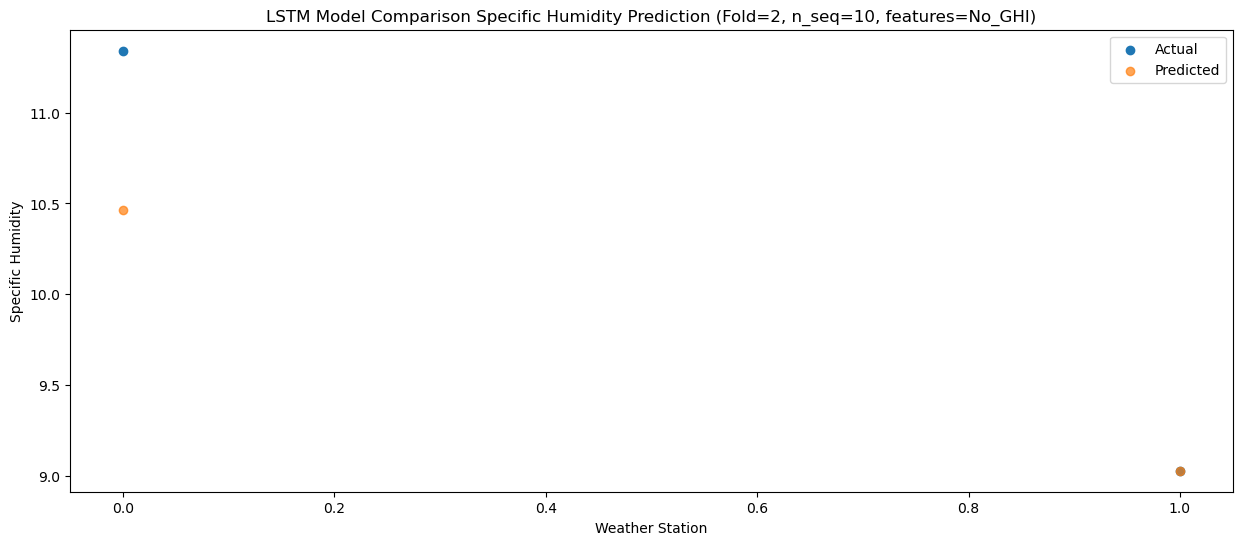

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   11.07  10.355490
1                1    8.38   8.912548


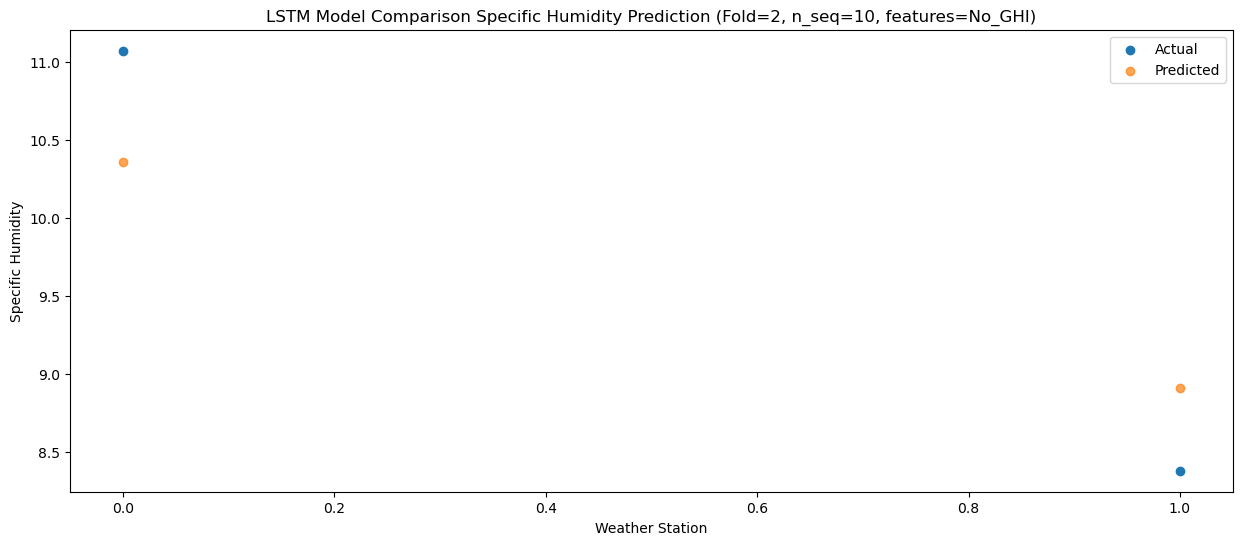

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   10.54  10.268473
1                1    8.20   8.813508


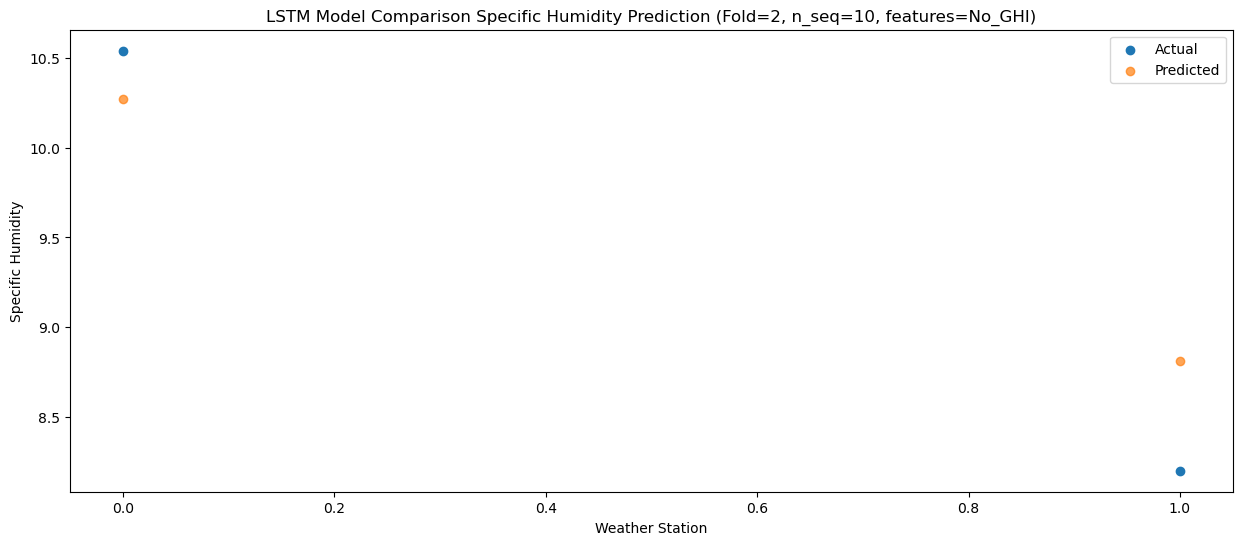

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   10.13  10.207294
1                1    8.27   8.776845


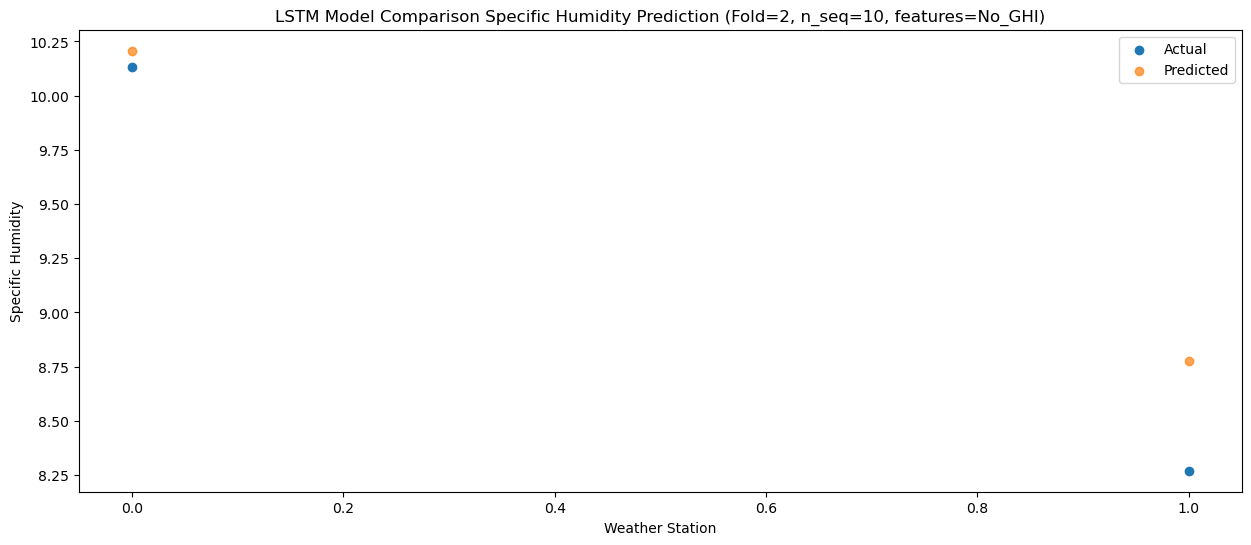

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   10.03   9.951555
1                1    8.54   8.510153


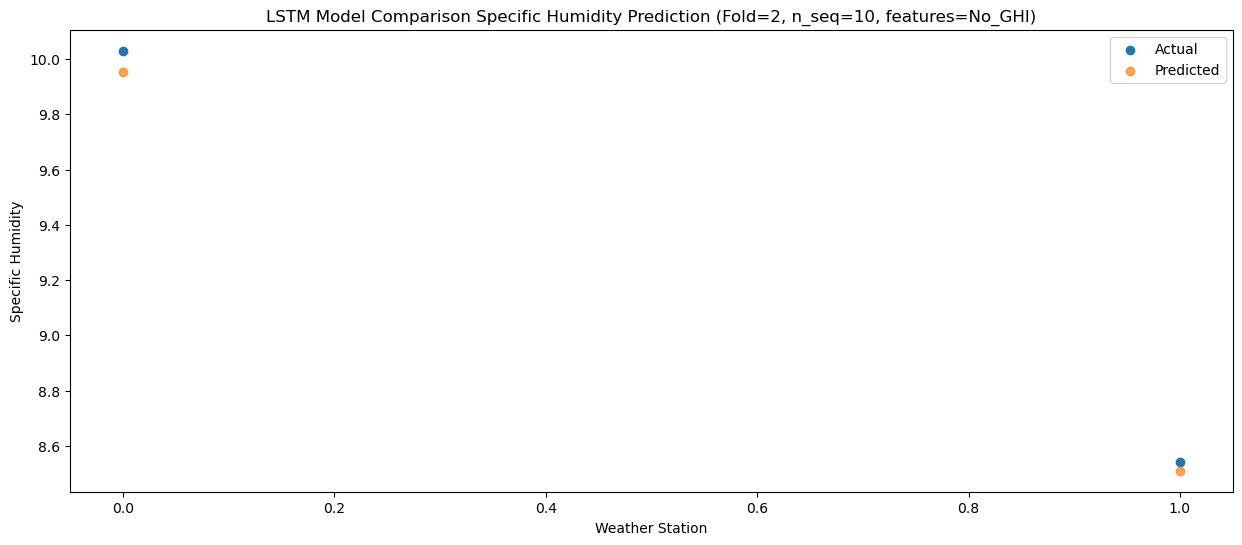

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   10.30  10.383561
1                1    8.55   8.940293


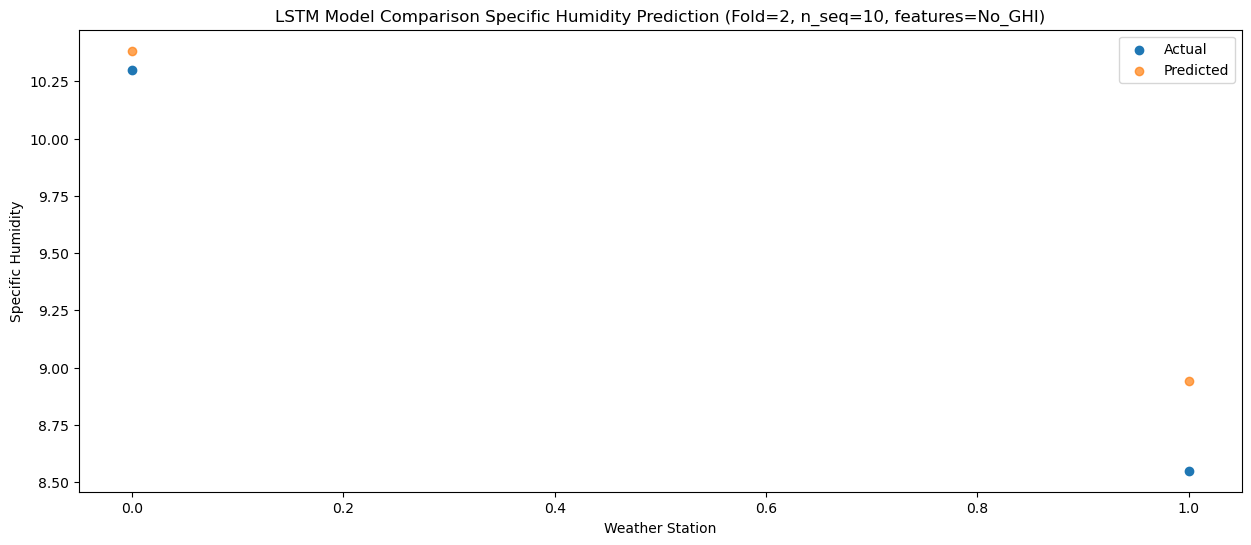

f, t:
[[ 9.72  7.68]
 [10.69  8.43]
 [10.26  8.98]
 [10.94  8.93]
 [11.34  9.03]
 [11.07  8.38]
 [10.54  8.2 ]
 [10.13  8.27]
 [10.03  8.54]
 [10.3   8.55]]
[[10.05094898  8.60256383]
 [10.48558262  9.02389166]
 [10.45270562  9.00868758]
 [10.33442458  8.88234618]
 [10.46564692  9.03024053]
 [10.35548986  8.91254838]
 [10.26847279  8.81350777]
 [10.20729379  8.77684517]
 [ 9.95155515  8.51015256]
 [10.38356073  8.94029285]]
Year at t+1:
t+1 SKRMSE: 0.693055
t+1 KRMSE: 0.693055
t+1 MAE: 0.626756
t+1 SKMAPE: 0.077087
t+1 R2_SCORE: 0.538326
t+1 KMAPE: 0.077087
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 8.700000
Year at t+2:
t+2 SKRMSE: 0.444125
t+2 KRMSE: 0.444125
t+2 MAE: 0.399155
t+2 SKMAPE: 0.044786
t+2 R2_SCORE: 0.845527
t+2 KMAPE: 0.044786
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 9.560000
Year at t+3:
t+3 SKRMSE: 0.137765
t+3 KRMSE: 0.137765
t+3 MAE: 0.110697
t+3 SKMAPE: 0.010988
t+3 R2_SCORE: 0.953664
t+3 KMAPE: 0.010988
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 9.620000
Year at t+4

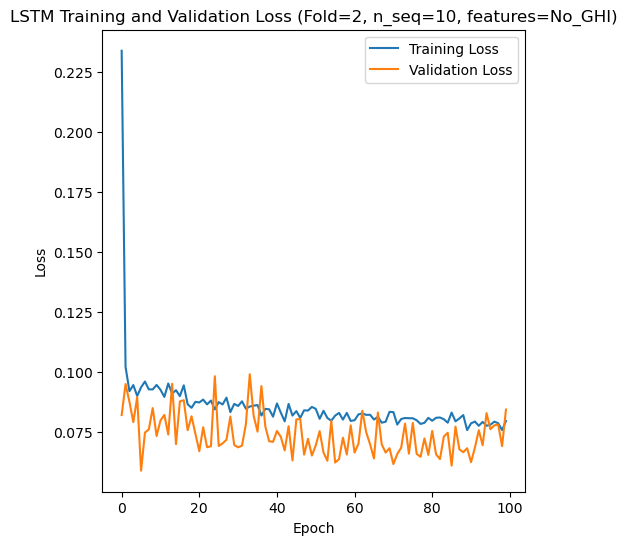

[[4.45 7.03 7.66 7.5  7.   7.5  6.8  7.19 6.85 6.32 6.46 6.61 7.06 6.53
  6.68 6.3  6.77 6.95 6.79 7.44 7.02 7.12 7.47 7.01 6.62 7.19 7.31]
 [8.33 7.39 7.85 8.23 8.15 7.91 8.01 7.7  7.52 7.54 7.12 7.57 7.71 8.23
  7.93 7.83 7.45 8.09 8.19 8.01 8.37 8.25 8.16 8.13 7.66 7.68 8.3 ]]
Epoch 1/100
20/20 [==============================] - 6s 93ms/step - loss: 0.3426 - accuracy: 0.0500 - mae: 0.3156 - rmse: 0.3426 - mape: 50.7372 - pearson: 0.0949 - val_loss: 0.0895 - val_accuracy: 0.5000 - val_mae: 0.0688 - val_rmse: 0.0895 - val_mape: 11.5779 - val_pearson: 0.4199
Epoch 2/100
20/20 [==============================] - 1s 28ms/step - loss: 0.1257 - accuracy: 0.4500 - mae: 0.1040 - rmse: 0.1257 - mape: 18.3034 - pearson: 0.2629 - val_loss: 0.1033 - val_accuracy: 0.5000 - val_mae: 0.0844 - val_rmse: 0.1033 - val_mape: 13.8719 - val_pearson: 0.1797
Epoch 3/100
20/20 [==============================] - 1s 27ms/step - loss: 0.1197 - accuracy: 0.6000 - mae: 0.0982 - rmse: 0.1197 - mape: 16.9493 - pear

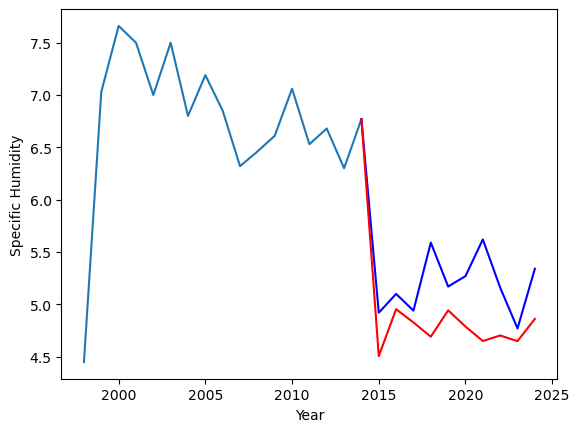

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
7.95		8.34		0.39
8.59		8.78		0.19
8.69		8.68		-0.01
8.51		8.55		0.04
8.87		8.81		-0.06
8.75		8.65		-0.10
8.66		8.52		-0.14
8.63		8.57		-0.06
8.16		8.52		0.36
8.18		8.74		0.56


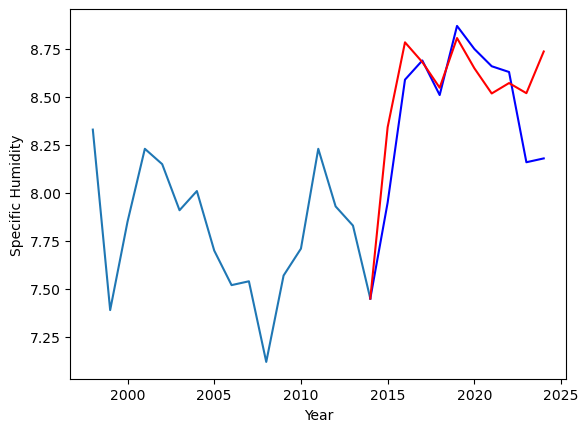

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0    4.92   4.505641
1                1    7.95   8.342493


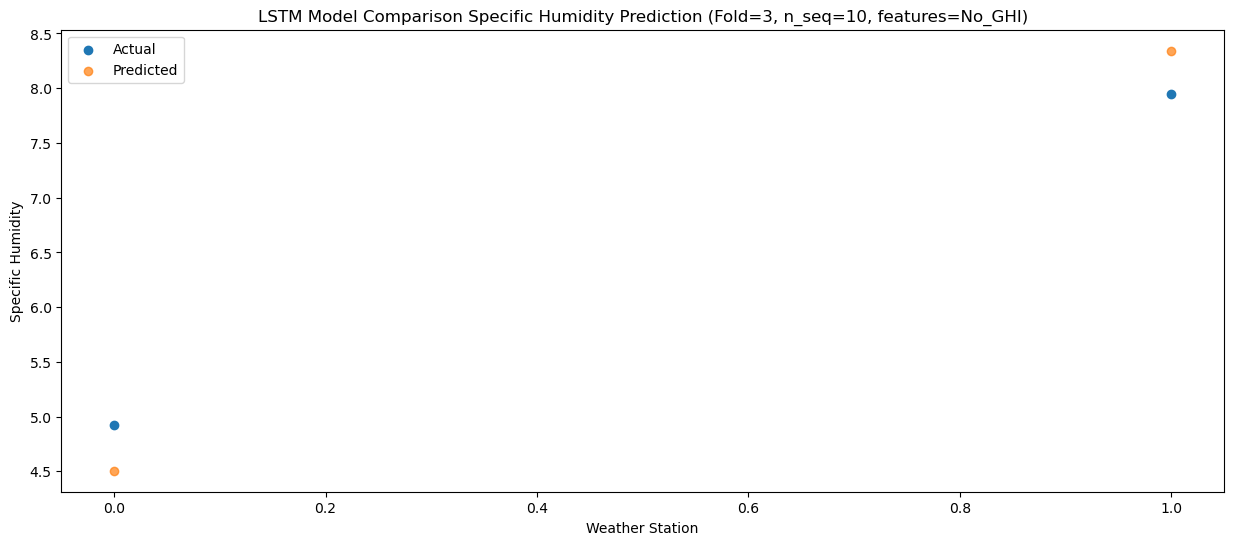

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0    5.10   4.953781
1                1    8.59   8.784553


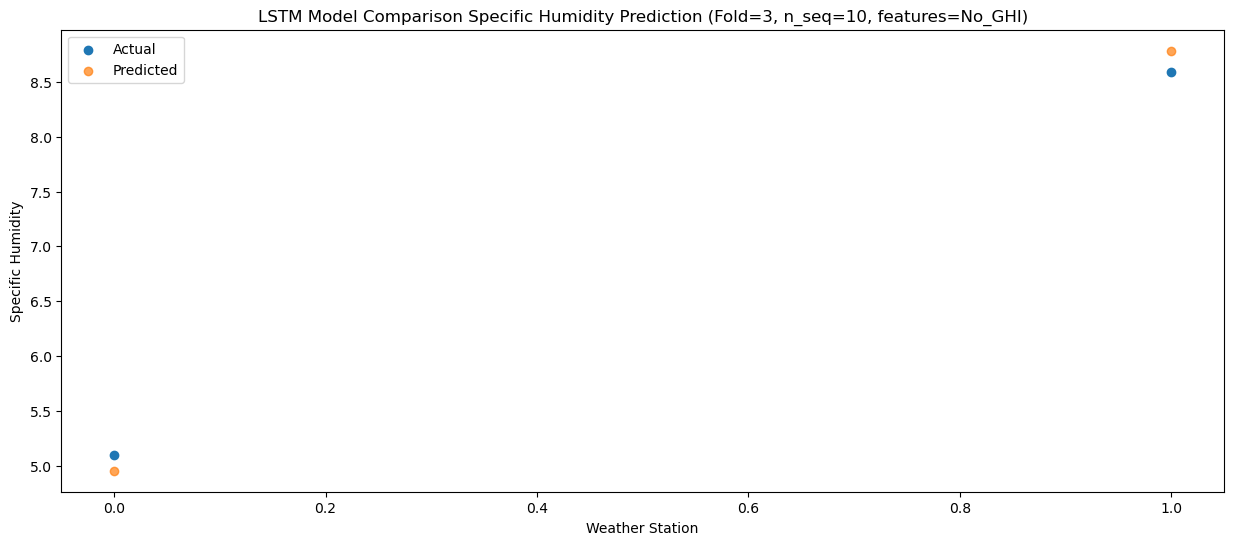

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0    4.94   4.826792
1                1    8.69   8.681469


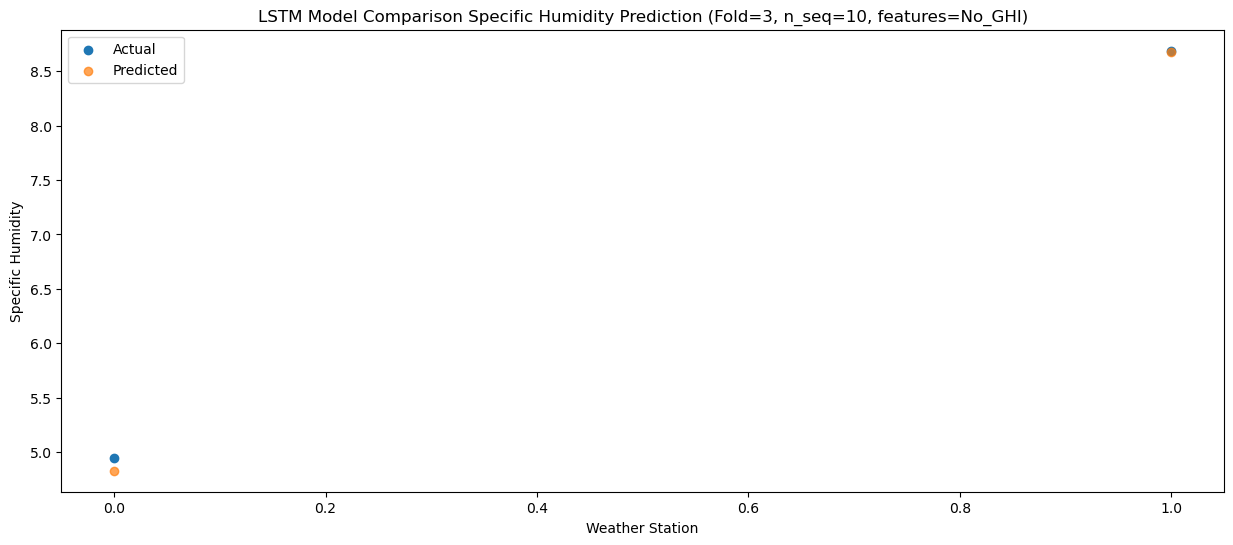

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0    5.59   4.690877
1                1    8.51   8.548107


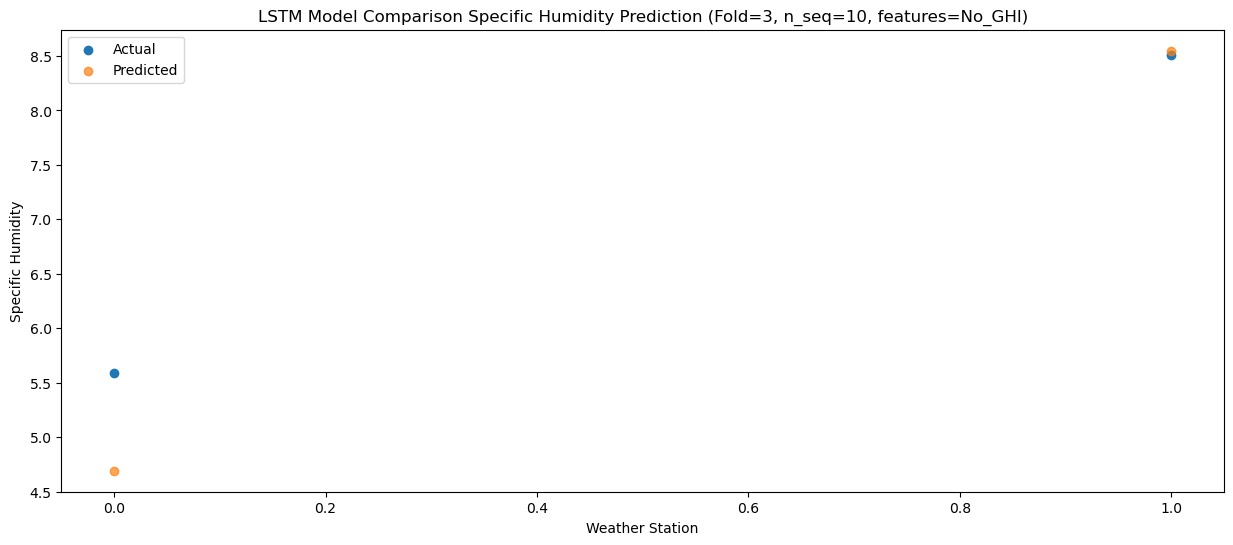

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0    5.17   4.942809
1                1    8.87   8.806902


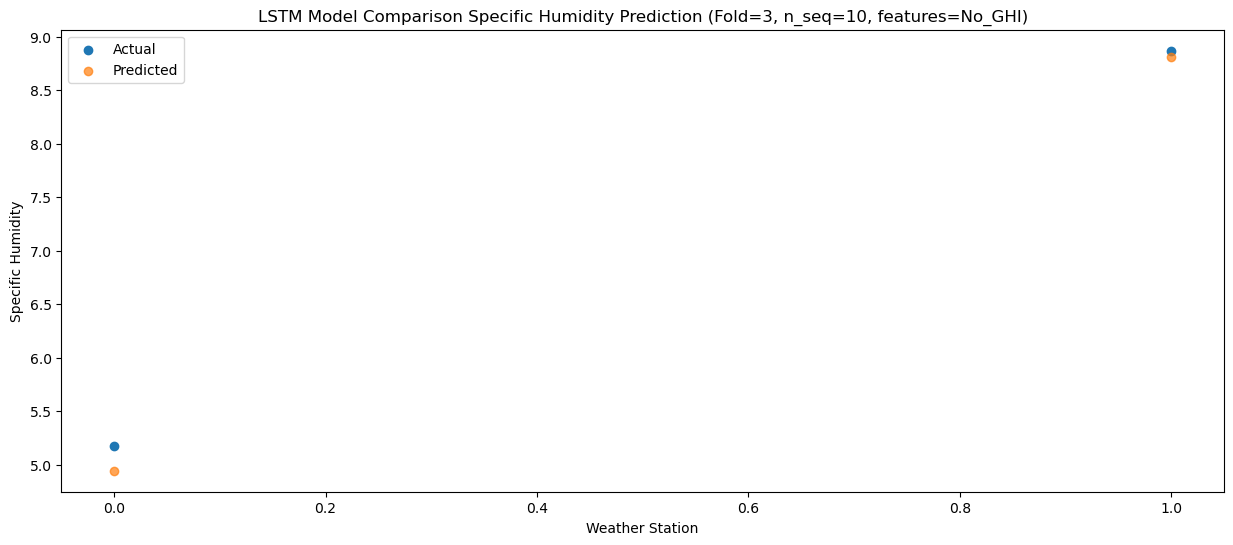

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0    5.27   4.788027
1                1    8.75   8.649543


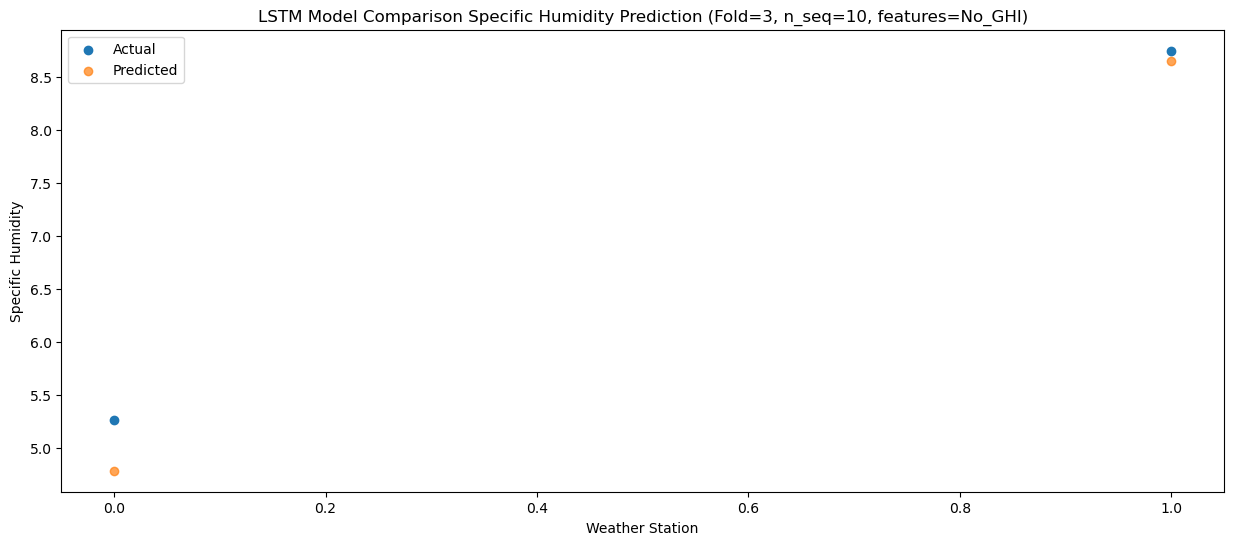

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0    5.62   4.649692
1                1    8.66   8.518181


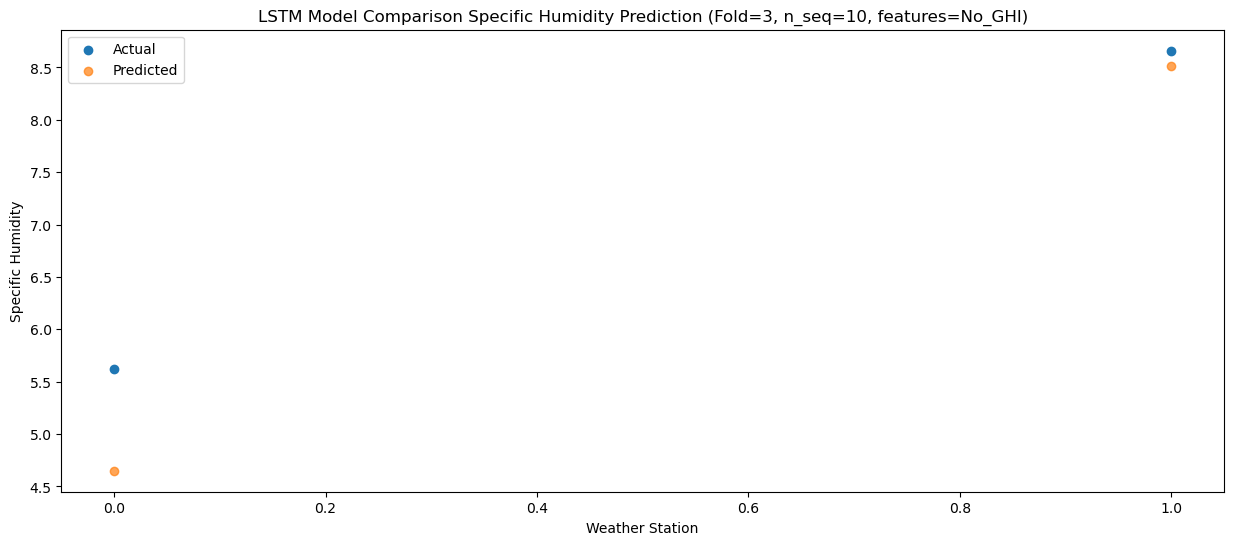

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0    5.16   4.702742
1                1    8.63   8.572421


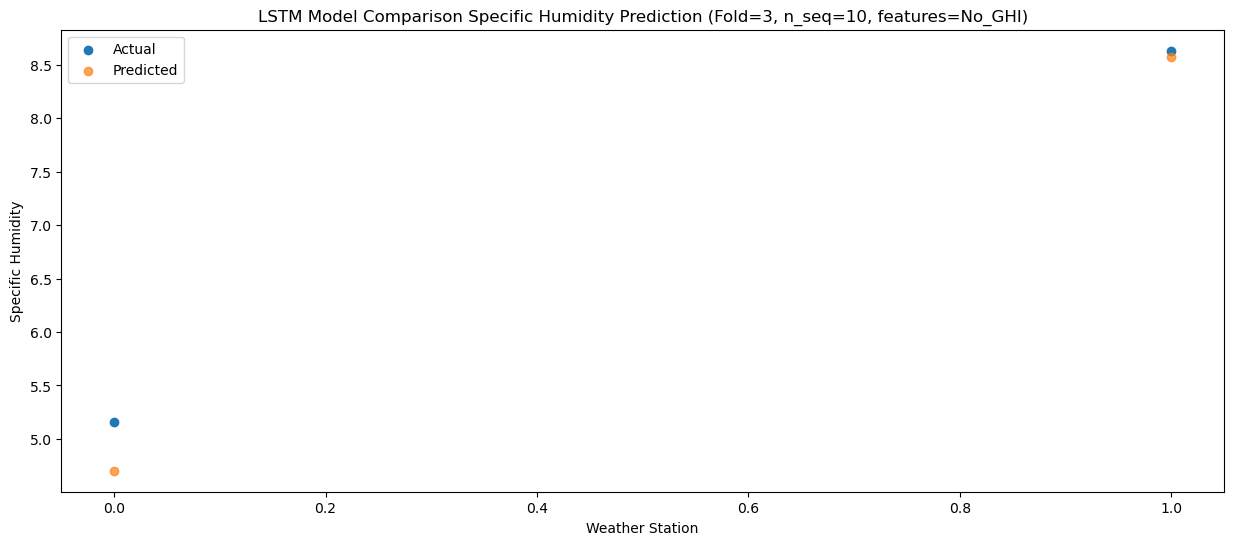

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0    4.77   4.648408
1                1    8.16   8.519680


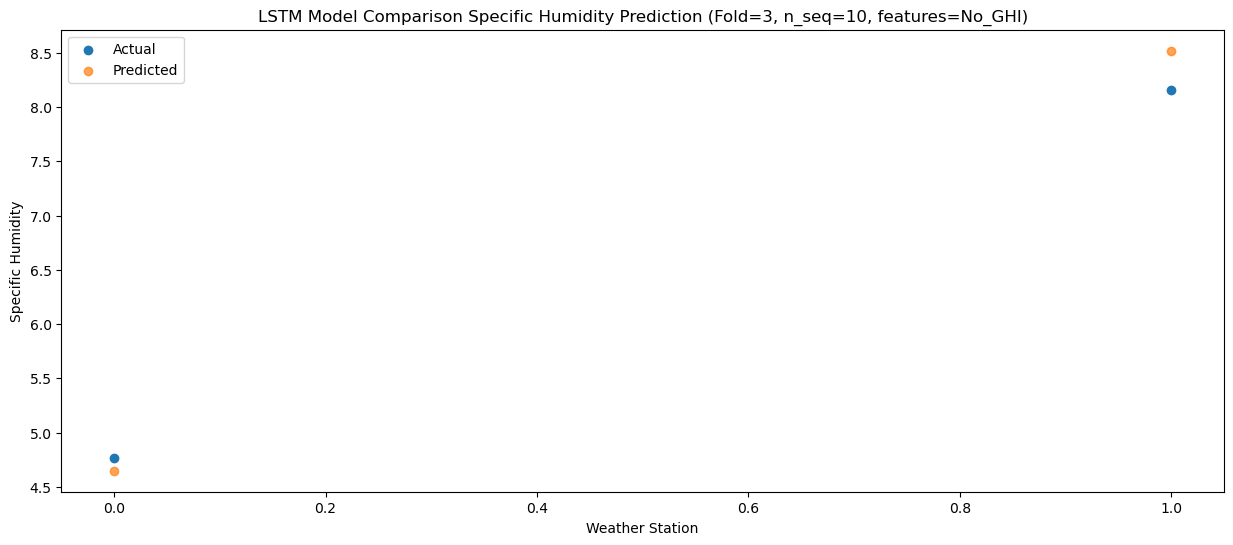

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0    5.34   4.861109
1                1    8.18   8.736812


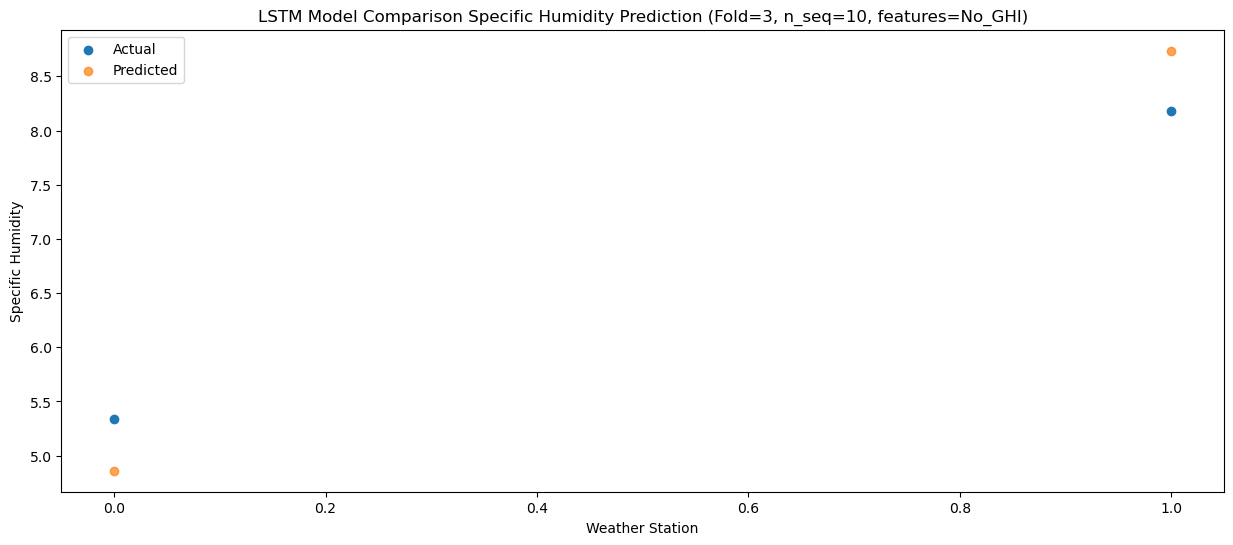

f, t:
[[4.92 7.95]
 [5.1  8.59]
 [4.94 8.69]
 [5.59 8.51]
 [5.17 8.87]
 [5.27 8.75]
 [5.62 8.66]
 [5.16 8.63]
 [4.77 8.16]
 [5.34 8.18]]
[[4.50564111 8.34249334]
 [4.95378081 8.78455316]
 [4.82679161 8.68146857]
 [4.6908767  8.5481072 ]
 [4.94280909 8.80690154]
 [4.7880274  8.64954295]
 [4.64969194 8.51818144]
 [4.70274191 8.57242072]
 [4.64840788 8.51968047]
 [4.86110868 8.73681177]]
Year at t+1:
t+1 SKRMSE: 0.403574
t+1 KRMSE: 0.403574
t+1 MAE: 0.403426
t+1 SKMAPE: 0.066795
t+1 R2_SCORE: 0.929039
t+1 KMAPE: 0.066795
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 6.435000
Year at t+2:
t+2 SKRMSE: 0.172092
t+2 KRMSE: 0.172092
t+2 MAE: 0.170386
t+2 SKMAPE: 0.025660
t+2 R2_SCORE: 0.990274
t+2 KMAPE: 0.025660
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 6.845000
Year at t+3:
t+3 SKRMSE: 0.080277
t+3 KRMSE: 0.080277
t+3 MAE: 0.060870
t+3 SKMAPE: 0.011949
t+3 R2_SCORE: 0.998167
t+3 KMAPE: 0.011949
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 6.815000
Year at t+4:
t+4 SKRMSE: 0.636347
t+4 KRMSE: 0.6363

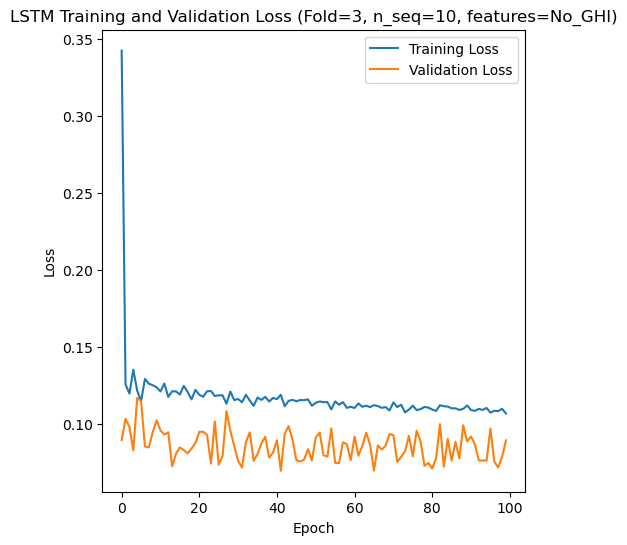

[[11.16  9.55  9.55 10.04  9.82  9.68 10.08  8.81  8.71 10.02  8.91  9.32
   9.71  8.86  9.35  8.98  8.99  9.85 10.25 10.41  9.69  9.69  9.59  9.94
   9.15  9.7  10.89]
 [ 8.33  7.32  7.52  7.52  7.95  7.22  7.21  7.13  7.15  7.14  7.22  7.24
   7.84  7.63  7.34  7.44  7.18  7.84  8.31  7.98  8.38  7.84  7.57  7.9
   7.3   7.53  8.43]]
Epoch 1/100
19/19 [==============================] - 6s 95ms/step - loss: 0.1945 - accuracy: 0.2632 - mae: 0.1766 - rmse: 0.1945 - mape: 39.3713 - pearson: 0.1826 - val_loss: 0.0974 - val_accuracy: 0.0000e+00 - val_mae: 0.0834 - val_rmse: 0.0974 - val_mape: 18.9170 - val_pearson: 0.0512
Epoch 2/100
19/19 [==============================] - 1s 28ms/step - loss: 0.0952 - accuracy: 0.3158 - mae: 0.0765 - rmse: 0.0952 - mape: 18.0228 - pearson: 0.2269 - val_loss: 0.1030 - val_accuracy: 0.0000e+00 - val_mae: 0.0847 - val_rmse: 0.1030 - val_mape: 20.0223 - val_pearson: 0.0677
Epoch 3/100
19/19 [==============================] - 1s 29ms/step - loss: 0.0930 - acc

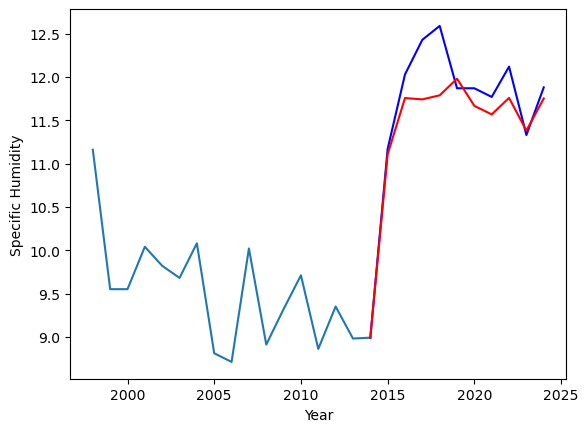

Weather Station 2:
Actual S.H.	Predicted S.H.	Difference
-----------	--------------	----------
8.07		8.26		0.19
8.73		8.90		0.17
9.20		8.87		-0.33
8.87		8.92		0.05
9.27		9.11		-0.16
8.73		8.80		0.07
8.46		8.70		0.24
8.79		8.88		0.09
8.19		8.52		0.33
8.42		8.90		0.48


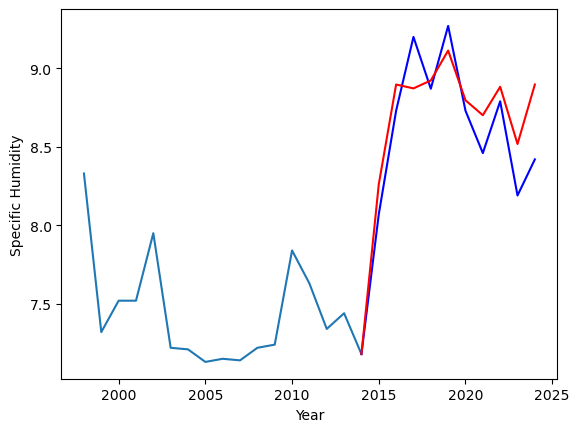

Predictions for (t+0):
   Weather_Station  Actual  Predicted
0                0   11.17  11.108845
1                1    8.07   8.261196


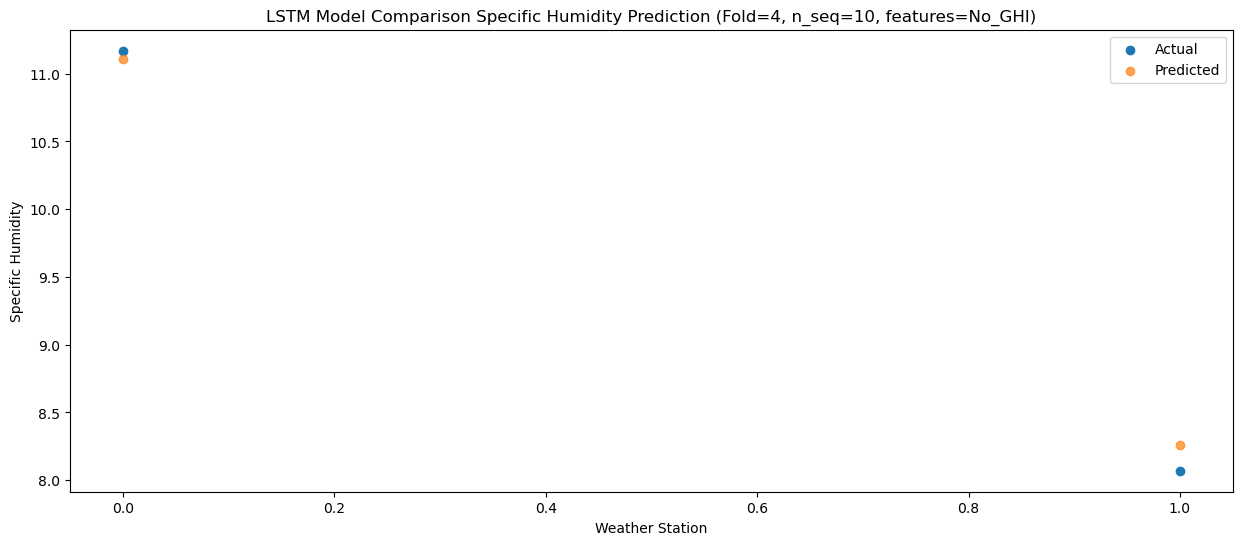

Predictions for (t+1):
   Weather_Station  Actual  Predicted
0                0   12.03  11.757145
1                1    8.73   8.896962


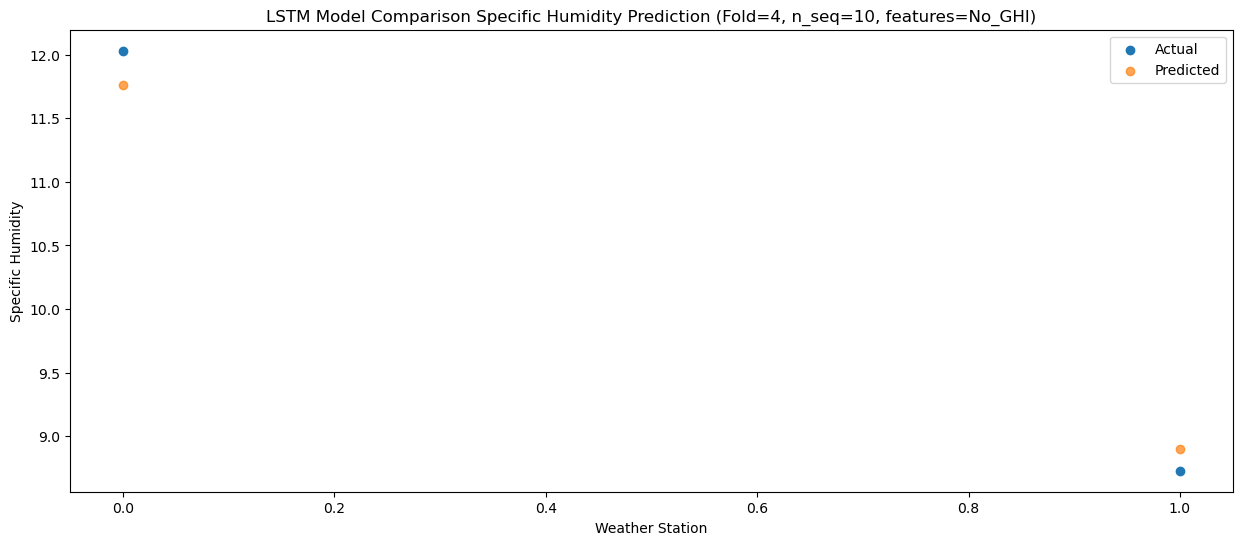

Predictions for (t+2):
   Weather_Station  Actual  Predicted
0                0   12.43  11.741736
1                1    9.20   8.872134


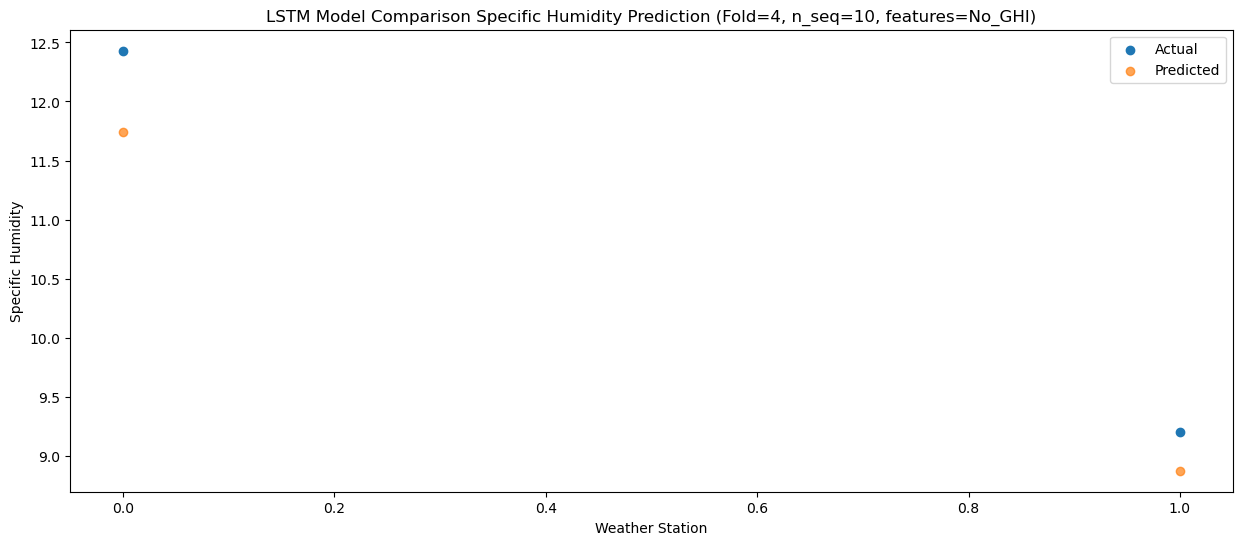

Predictions for (t+3):
   Weather_Station  Actual  Predicted
0                0   12.59  11.788708
1                1    8.87   8.922594


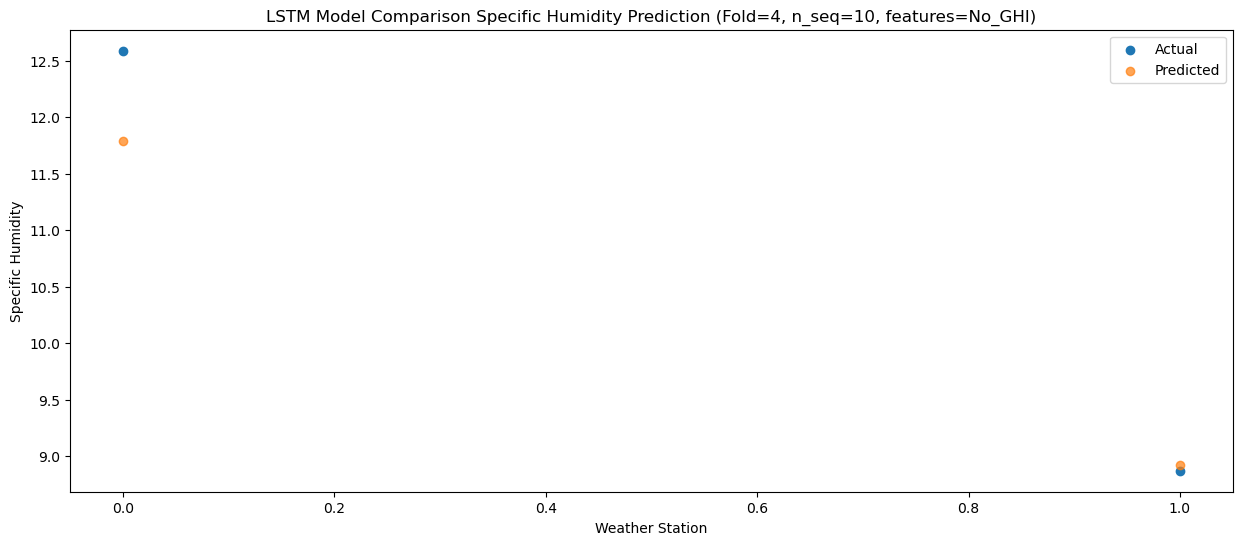

Predictions for (t+4):
   Weather_Station  Actual  Predicted
0                0   11.87  11.980393
1                1    9.27   9.113165


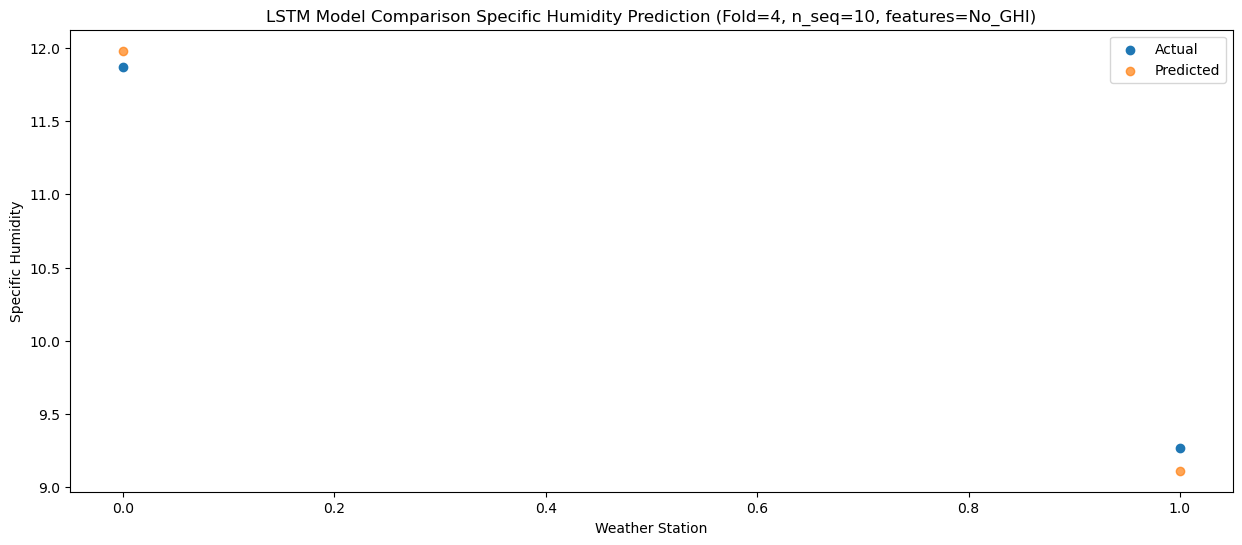

Predictions for (t+5):
   Weather_Station  Actual  Predicted
0                0   11.87  11.666891
1                1    8.73   8.796484


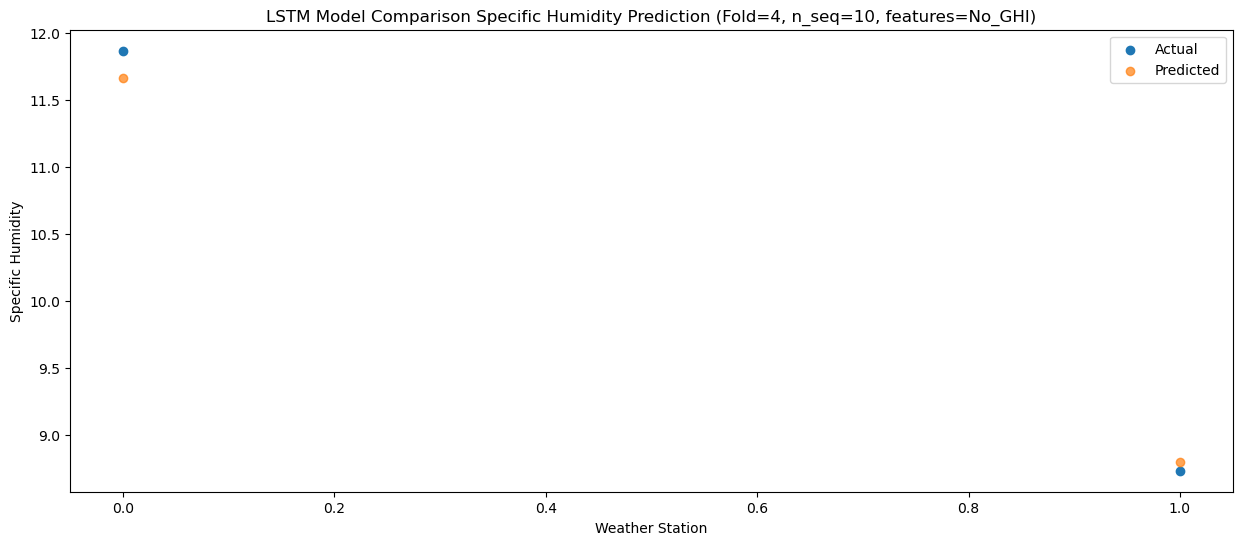

Predictions for (t+6):
   Weather_Station  Actual  Predicted
0                0   11.77  11.568130
1                1    8.46   8.701265


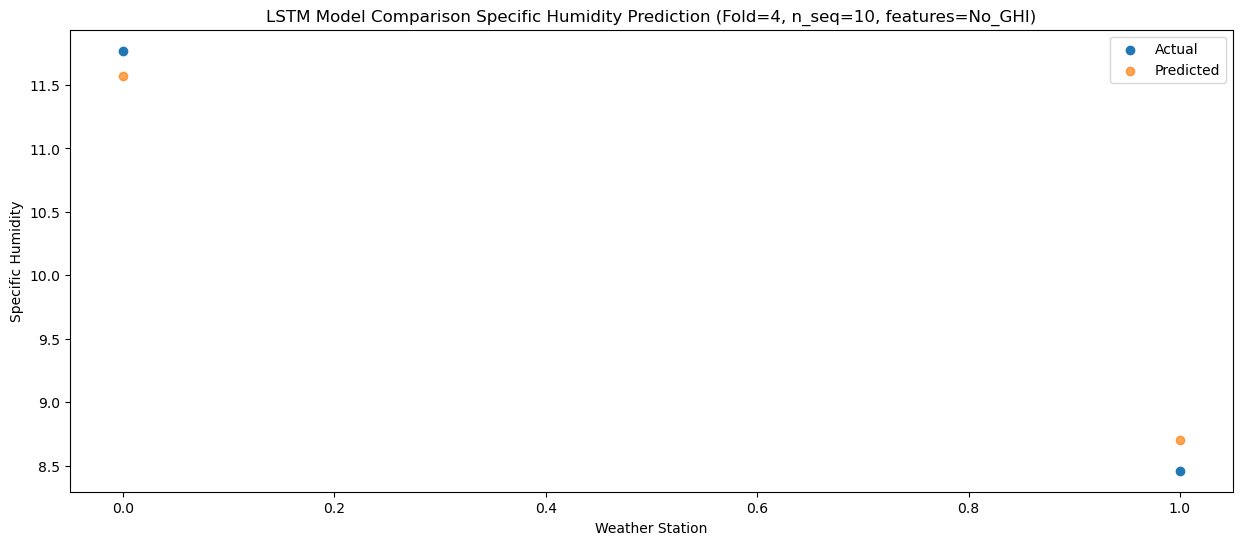

Predictions for (t+7):
   Weather_Station  Actual  Predicted
0                0   12.12  11.759157
1                1    8.79   8.882351


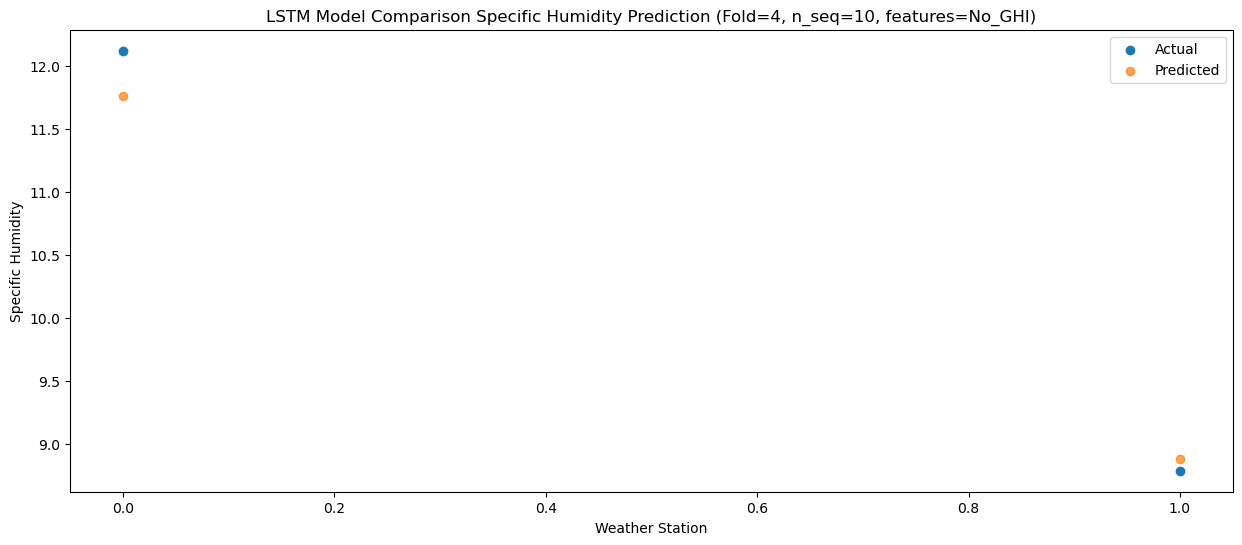

Predictions for (t+8):
   Weather_Station  Actual  Predicted
0                0   11.33  11.380967
1                1    8.19   8.518108


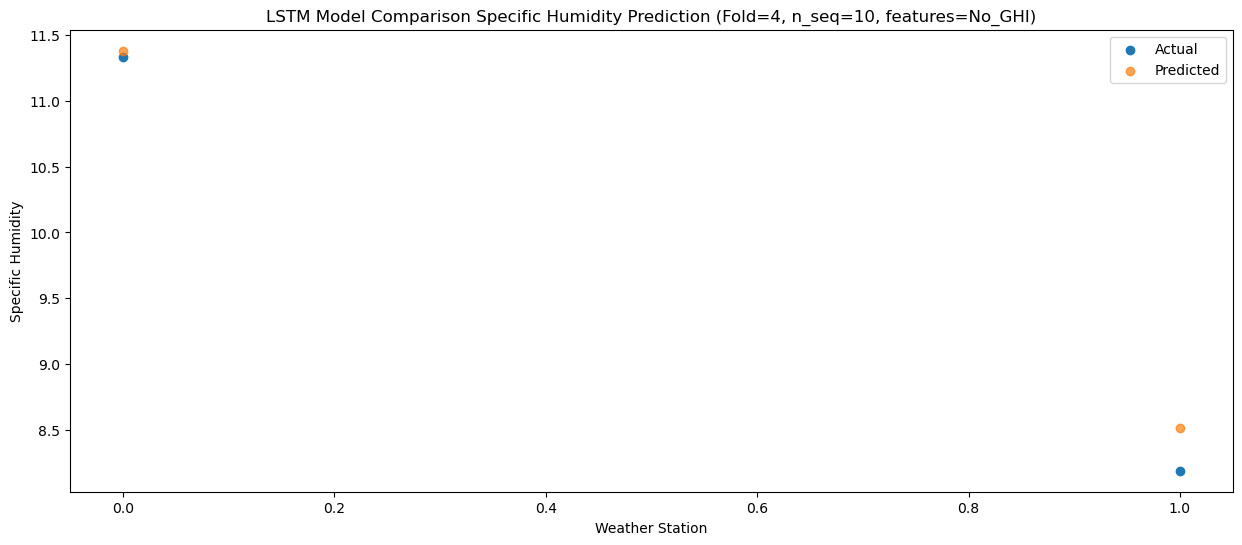

Predictions for (t+9):
   Weather_Station  Actual  Predicted
0                0   11.88  11.752177
1                1    8.42   8.896885


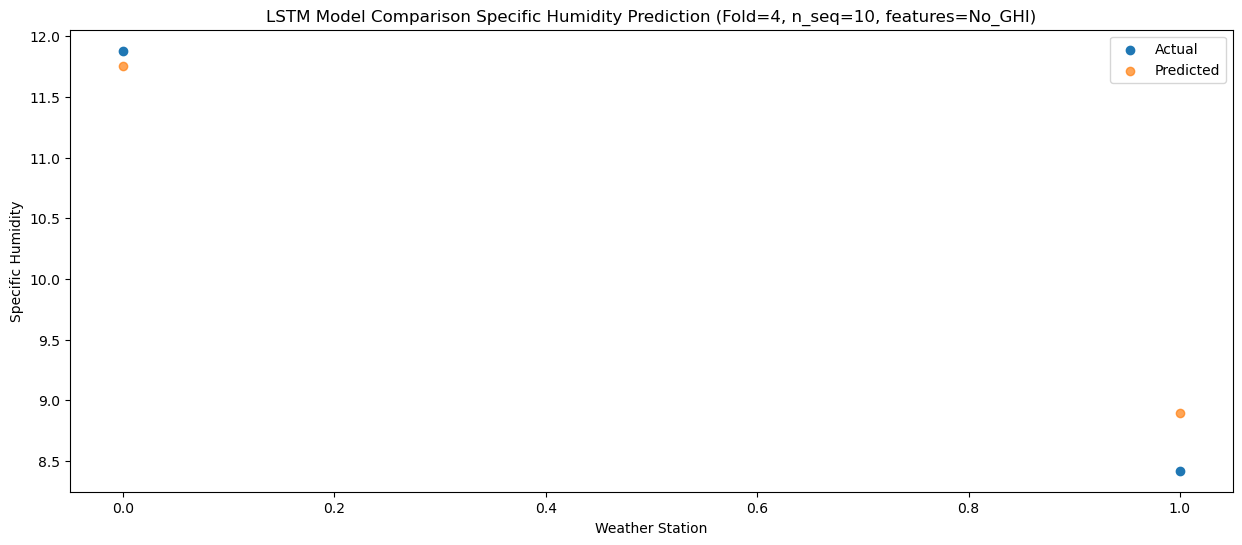

f, t:
[[11.17  8.07]
 [12.03  8.73]
 [12.43  9.2 ]
 [12.59  8.87]
 [11.87  9.27]
 [11.87  8.73]
 [11.77  8.46]
 [12.12  8.79]
 [11.33  8.19]
 [11.88  8.42]]
[[11.1088449   8.26119591]
 [11.75714513  8.89696235]
 [11.74173573  8.87213409]
 [11.78870802  8.92259405]
 [11.98039326  9.1131647 ]
 [11.66689143  8.79648421]
 [11.56812961  8.70126545]
 [11.75915743  8.88235064]
 [11.38096703  8.51810764]
 [11.75217677  8.89688529]]
Year at t+1:
t+1 SKRMSE: 0.141943
t+1 KRMSE: 0.141943
t+1 MAE: 0.126176
t+1 SKMAPE: 0.014584
t+1 R2_SCORE: 0.991614
t+1 KMAPE: 0.014584
t+1 PEARSON: 1.000000
t+1 AVERAGE ACTUAL: 9.620000
Year at t+2:
t+2 SKRMSE: 0.226193
t+2 KRMSE: 0.226193
t+2 MAE: 0.219909
t+2 SKMAPE: 0.020903
t+2 R2_SCORE: 0.981207
t+2 KMAPE: 0.020903
t+2 PEARSON: 1.000000
t+2 AVERAGE ACTUAL: 10.380000
Year at t+3:
t+3 SKRMSE: 0.539075
t+3 KRMSE: 0.539075
t+3 MAE: 0.508065
t+3 SKMAPE: 0.045504
t+3 R2_SCORE: 0.888583
t+3 KMAPE: 0.045504
t+3 PEARSON: 1.000000
t+3 AVERAGE ACTUAL: 10.815000
Year at t

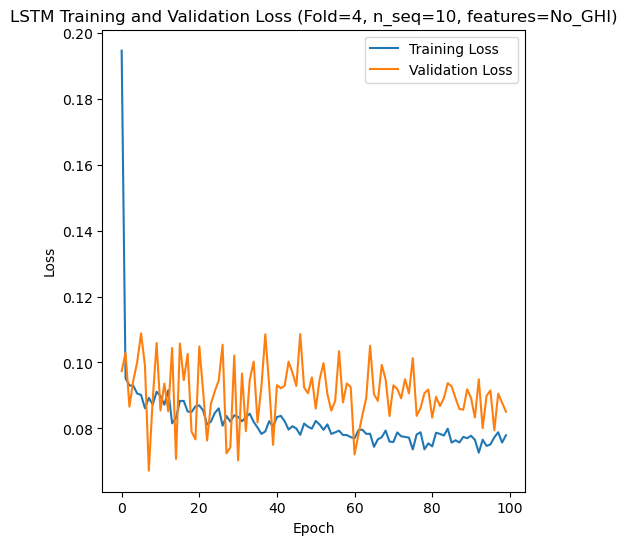

[[0.4881654722704929], [0.5120108179841882], [0.4582609699948973], [0.4100772438094855], [0.31959547036361613]]
[[array(0.48816547)], [array(0.51201082)], [array(0.45826097)], [array(0.41007724)], [array(0.31959547)]]
[[0.3965347108095889], [0.41666967392712834], [0.35497081132978175], [0.31116267964988953], [0.24895590186864167]]
[[0.03219685869754547], [0.04205484658874962], [0.038310601854557216], [0.051988041083263145], [0.024020393825743645]]
[[0.9001863647320185], [0.92813362535321], [0.824415743386026], [0.940277871106014], [0.9630990507888669]]
[[array(0.03219686)], [array(0.04205485)], [array(0.0383106)], [array(0.05198804)], [array(0.02402039)]]
[[array(0.95719077)], [array(0.96039826)], [array(0.90230816)], [array(0.9761605)], [array(0.97871389)]]
[12.78 13.83 13.92 14.3  13.46 13.41 13.53 13.34 13.05 13.36  9.71 10.79
 10.2  10.87 10.99 10.8  11.01 10.57 10.05 10.24 11.42 12.26 11.81 12.26
 12.81 12.14 12.5  11.83 11.88 11.74  7.95  9.08  9.06  8.69  8.53  8.56
  7.82  8.26

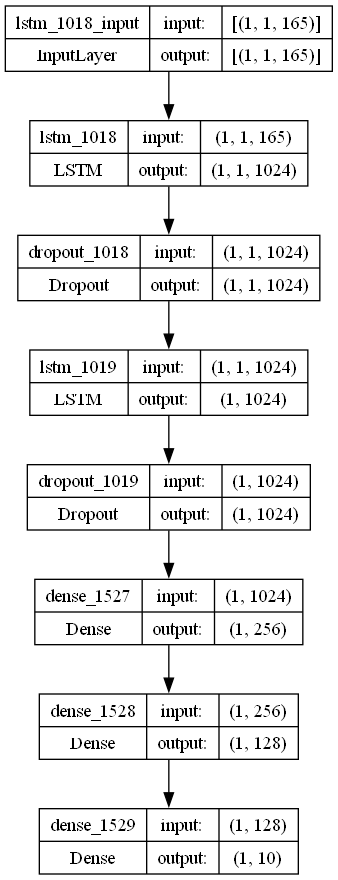

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.utils import plot_model

def rmse (y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def kmape (y_true, y_pred):
    return K.mean(K.sqrt(K.square(y_true - y_pred))/y_true)
    
def kpearson (y_true, y_pred):
    mean_true = K.mean(y_true)
    mean_pred = K.mean(y_pred)
    return (K.square(K.mean((y_true - mean_true)*(y_pred - mean_pred))))/(K.mean(K.square(y_true - mean_true))*K.mean(K.square(y_pred - mean_pred)))

# fit the best LSTM model using parameters found by Optuna
def create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch):
    
    #Parameters:
    #trial (array-like): Optuna parameters.
    #train (array-like): Target values.
    #n_lag (int): Number of lag observations.
    #n_seq (int): Number of sequence observations
    #nb_epoch (int): Maximum number of epochs
    
    # Hyperparameters from the best model
    lr = 0.038844392388824124
    optimizer = SGD(learning_rate = lr)
    activation_function = 'tanh'
    lstm_units = 1024
    dropout_rate = 0.23019200323725364

    # design network
    model = Sequential()
    #model.add(Conv1D(filters=filters, kernel_size=1, activation='relu', input_shape=(X.shape[1], X.shape[2]))) # CNN-LSTM only
    model.add(LSTM(lstm_units, return_sequences=True, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(lstm_units))
    model.add(Dropout(dropout_rate))
    model.add(Dense(256, input_dim=y.shape[1], activation=activation_function))
    model.add(Dense(128, activation=activation_function))
    model.add(Dense(n_seq))
    model.compile(loss=rmse, optimizer=optimizer, metrics=['accuracy', 'mae', rmse, mape, pearson])
        
    return model

# make one forecast with an LSTM,
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def forecast_lstm(model, X, n_seq, n_test):
    # reshape input pattern to [samples, timesteps, features]
    X = X.reshape(1, 1, X.shape[1])
    # make forecast
    forecast = model.predict(X)
    # convert to array
    return forecast
     
# evaluate the persistence model
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def make_forecasts(model, X_test, y_test, n_lag, n_seq, n_test):
    forecasts = list()
    for i in range(len(X_test)):
        X, y = X_test[i, :], y_test[i, :]
        # make forecast
        forecast = forecast_lstm(model, X, n_seq, n_test)
        # store the forecast
        forecasts.append(forecast)
    return forecasts
     
# Invert differenced forecast
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_difference(last_ob, forecast):
    # Invert the first forecast
    inverted = list()
    inverted.append(forecast[0] + last_ob)
    # Propagate the difference forecast using the inverted first value
    for i in range(1, len(forecast)):
        inverted.append(forecast[i] + inverted[i-1])
    return inverted
     
# Inverse data transform on forecasts
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def inverse_transform(series, forecasts, scaler, n_test, n_seq):
    inverted = list()
    for i in range(len(forecasts)):
        # create an array from the forecast
        forecast = forecasts[i]
        forecast = forecast.reshape(1, n_seq)
        # invert scaling
        inv_scale = scaler.inverse_transform(forecast)
        inv_scale = inv_scale[0, :]
        # invert differencing
        index = len(series) - n_test + i
        last_ob = series.values[index]
        inv_diff = inverse_difference(last_ob, inv_scale)
        # store
        inverted.append(inv_diff)
    return inverted
     
# Evaluate the RMSE for each forecast time step
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def evaluate_forecasts(actual, forecasts, n_lag, n_seq):

    t = np.array(actual).transpose()
    f = np.array(forecasts).transpose()

    print("f, t:")
    print(t)
    print(f)
    rmse_list = []
    mae_list = []
    skmape_list = []
    mape_list = []
    r2_list = []
    pearson_list = []
    actual_list = []

    for i in range(n_seq):
        act = [row for row in t[i]]
        predicted = [forecast for forecast in f[i]]
        rmse1 = sqrt(mean_squared_error(act, predicted))
        rmse2 = np.array(rmse(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        mae = mean_absolute_error(act, predicted)
        mse = mean_squared_error(act, predicted)
        skmape = mean_absolute_percentage_error(act, predicted)
        kmape1 = np.array(kmape(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        kpearson1 = np.array(kpearson(tf.convert_to_tensor(np.array(act)), tf.convert_to_tensor(np.array(predicted))))
        r2 = r2_score(act, predicted) 
        avg_actual = np.mean(act)
        print("Year at t+"+str(i+1)+":")
        print('t+%d SKRMSE: %f' % ((i+1), rmse1))
        print('t+%d KRMSE: %f' % ((i+1), rmse2))        
        print('t+%d MAE: %f' % ((i+1), mae))
        print('t+%d SKMAPE: %f' % ((i+1), skmape))
        print('t+%d R2_SCORE: %f' % ((i+1), r2))
        print('t+%d KMAPE: %f' % ((i+1), kmape1))
        print('t+%d PEARSON: %f' % ((i+1), kpearson1))
        print('t+%d AVERAGE ACTUAL: %f' % ((i+1), avg_actual))

    y_true = tf.convert_to_tensor(np.array(actual).flatten())
    y_pred = tf.convert_to_tensor(np.array(forecasts).flatten())

    rmse1 = sqrt(mean_squared_error(np.array(y_true), np.array(y_pred)))
    rmse2 = np.array(rmse(y_true, y_pred))
    mae = mean_absolute_error(np.array(y_true), np.array(y_pred))
    mse = mean_squared_error(np.array(y_true), np.array(y_pred))
    skmape = mean_absolute_percentage_error(np.array(y_true), np.array(y_pred))
    kmape1 = np.array(kmape(y_true, y_pred))
    kpearson1 = np.array(kpearson(y_true, y_pred))
    r2 = r2_score(np.array(y_true), np.array(y_pred)) 
    avg_actual = np.mean(np.array(y_true))
    rmse1_list.append(rmse1)
    rmse2_list.append(rmse2)
    mae_list.append(mae)
    skmape_list.append(skmape)
    pearson_list.append(kpearson1)
    mape_list.append(kmape1)
    r2_list.append(r2)
    actual_list.append(avg_actual)
    print("Metrics for this Fold:")
    print('SKRMSE: %f' % (rmse1))
    print('KRMSE: %f' % (rmse2))        
    print('MAE: %f' % (mae))
    print('SKMAPE: %f' % (skmape))
    print('R2_SCORE: %f' % (r2))
    print('KMAPE: %f' % (kmape1))
    print('PEARSON: %f' % (kpearson1))
    print('AVERAGE ACTUAL: %f' % (avg_actual))

    return rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list
     
# Plot the forecasts in the context of the original dataset
#Taken from: https://machinelearningmastery.com/multi-step-time-series-forecasting-long-short-term-memory-networks-python/
def plot_forecasts(series, forecasts, actual, n_test, n_seq, n_lag):
    # Plot the actual data in blue
    plt.plot(series[:n_lag+2].index, series[:n_lag+2].values)
    off_s = n_lag + 1
    off_e = off_s + len(actual) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + actual
    plt.plot(xaxis, yaxis, color='blue')
    # Plot the forecasts in red
    off_s = n_lag + 1
    off_e = off_s + len(forecasts) + 1
    xaxis = [1998+x for x in range(off_s, off_e)]
    yaxis = [series.values[off_s]] + forecasts
    plt.plot(xaxis, yaxis, color='red')
    plt.xlabel("Year")
    plt.ylabel("Specific Humidity")
    # show the plot
    plt.show()

n_batch = 1
n_test = 2
nb_epoch = 100
    
rmse1_avg_list = []
rmse2_avg_list = []
mae_avg_list = []
skmape_avg_list = []
r2_score_avg_list = []
mape_avg_list = []
pearson_avg_list = []
actual_avg_list = []
forecast_results = []
actual_results = []
    
for i in range(5):
    train1 = train[i]
    test1 = test[i]
    validation1 = validation[i]

    X = train1[:, 0:-n_seq]
    y = train1[:, -n_seq:]
    X_test = test1[:, 0:-n_seq]
    y_test = test1[:, -n_seq:]
    X_val = validation1[:, 0:-n_seq]
    y_val = validation1[:, -n_seq:]
    
    dataset_df = pd.DataFrame(val_y[i])
    dataset_df = dataset_df.iloc[0:2, :]
    dataset = dataset_df.values

    print(dataset)

    series = pd.Series(dataset[:, 0]) # Using first column (specific_humidity)

    X = X.reshape(X.shape[0], 1, X.shape[1])
    X1 = X_test
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
    X_val = X_val.reshape(X_val.shape[0], 1, X_val.shape[1])

    best_model = create_best_model(X, y, n_lag, n_seq, n_batch, nb_epoch)
    history = best_model.fit(X, y, epochs=100, batch_size=n_batch, validation_data=(X_val, y_val))

    # Evaluate the model
    loss = best_model.evaluate(X_test, y_test, verbose=2)
    print(f'Test Loss: {loss}')

    # make forecasts
    forecasts = make_forecasts(best_model, X_test, y_test, n_lag, n_seq, n_test)
    
    # inverse transform forecasts and test
    forecasts = inverse_transform(series, forecasts, scaler[i], n_test, n_seq)
    actual = [row[-n_seq:] for row in test1]
    actual = inverse_transform(series, actual, scaler[i], n_test, n_seq)

    # Print out plots of actual and predicted values for weather stations
    ws = [1,2]
    print(ws)
    a = []
    f = []
    for q in range(len(actual)):
        x = actual[q]
        a.append(x[0])
    for q in range(len(forecasts)):
        x = forecasts[q]
        f.append(x[0])
    print(a)
    print(f)
    # Create a DataFrame for plotting
    results_df = pd.DataFrame({
        'ws': ws,
        'Actual': a,
        'Predicted': f
    })

    print(results_df)
    
    print("Actual and Forecasts:")
    print(actual)
    print(forecasts)
    
    for j in range(2):
        print("Weather Station "+str(j+1)+":")
        print("Actual S.H.\tPredicted S.H.\tDifference")
        print("-----------\t--------------\t----------")
        for k in range(n_seq):
            diff = forecasts[j][k] - actual[j][k]
            print(f"{actual[j][k]:.2f}\t\t{forecasts[j][k]:.2f}\t\t{diff:.2f}")

        # plot forecasts
        dataset_df = pd.DataFrame(val_y[i])
        dataset_df = dataset_df.iloc[0:2, :]
        dataset_df = dataset_df.transpose()
        dataset = dataset_df.values

        series_ws = pd.Series(dataset[:, j]) # Using first column (specific_humidity)
        forecasts_ws = forecasts[j]
        actual_ws = actual[j]

        # Set index starting from 1998
        series_ws.index = range(1998, 1998 + len(series_ws))        
        
        plot_forecasts(series_ws, forecasts_ws, actual_ws, n_test, n_seq, n_lag)

    for k in range(n_seq):
        print("Predictions for (t+"+str(k)+"):")
        # Print out plots of actual and predicted values for each weather station
        results = []

        # Create a DataFrame for plotting
        for j in range(2):
            results.append([j, actual[j][k], forecasts[j][k]])
               
        results_df = pd.DataFrame(results)
        results_df.columns = ['Weather_Station', 'Actual', 'Predicted']

        print(results_df)

        # Plotting the results
        plt.figure(figsize=(15, 6))
        plt.scatter(results_df['Weather_Station'], results_df['Actual'], label='Actual')
        plt.scatter(results_df['Weather_Station'], results_df['Predicted'], label='Predicted', alpha=0.7)
        title1='LSTM Model Comparison Specific Humidity Prediction (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
        plt.title(title1)
        plt.xlabel('Weather Station')
        plt.ylabel('Specific Humidity')
        plt.legend()
        plt.show()
    
    rmse1_list = [] # list stores sklearn's root mean squared errors for each future time prediction
    rmse2_list = [] # list stores root mean squared errors for each future time prediction
    mae_list = [] # list stores mean absolute errors for each future time prediction
    skmape_list = [] # list stores sklearn's mean squared percentage errors for each future time prediction
    r2_list = [] # list stores sklearn's r2 pearson values for each future time prediction
    mape_list = [] # list stores mean squared percentage errors for each future time prediction
    pearson_list = [] # list stores r2 pearson values for each future time prediction
    actual_list = [] # list stores average actual values for each future time prediction

    # evaluate forecasts
    rmse1_list, rmse2_list, mae_list, skmape_list, r2_list, mape_list, pearson_list, actual_list = evaluate_forecasts(actual, forecasts, n_lag, n_seq)

    rmse1_avg_list.append(rmse1_list)
    rmse2_avg_list.append(rmse2_list)
    mae_avg_list.append(mae_list)
    skmape_avg_list.append(skmape_list)
    r2_score_avg_list.append(r2_list)
    mape_avg_list.append(mape_list)
    pearson_avg_list.append(pearson_list)
    actual_avg_list.append(actual_list)
    forecast_results.append(forecasts)
    actual_results.append(actual)
            
    best_model.summary()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    title2 = 'LSTM Training and Validation Loss (Fold='+str(i)+', n_seq='+str(n_seq)+', features=No_GHI)'
    plt.title(title2)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')
    plt.show()

print(rmse1_avg_list)
print(rmse2_avg_list)
print(mae_avg_list)
print(skmape_avg_list)
print(r2_score_avg_list)
print(mape_avg_list)
print(pearson_avg_list)
print(np.array(actual_results).flatten())
print(np.array(forecast_results).flatten())
a2 = np.array(actual_results).flatten()
f2 = np.array(forecast_results).flatten()
p1 = np.array(pearson(tf.convert_to_tensor(a2), tf.convert_to_tensor(f2)))
print("Accuracy Results:")
print("RMSE for each fold:")
print(rmse1_avg_list)
print("Average SKRMSE:"+str(np.mean(rmse1_avg_list)))
print("Average KRMSE:"+str(np.mean(rmse2_avg_list)))
print("Average MAE:"+str(np.mean(mae_avg_list)))
print("Average SKMAPE:"+str(np.mean(skmape_avg_list)))
print("Average MAPE:"+str(np.mean(mape_avg_list)))
print("Average PEARSON:"+str(p1))
print("Average R2 Score:"+str(np.mean(r2_score_avg_list)))
print("")
print("Average Specific Humidity:"+str(np.mean(actual_avg_list)))
print("RMSE % of Specific Humidity:"+str(np.mean(rmse2_avg_list)/np.mean(actual_avg_list)))

# Plot model architecture
filename = "lstm_model_optimized_SH_S10_No_GHI.png"
plot_model(best_model, to_file=filename, show_shapes=True, show_layer_names=True)